In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
from pmdarima import auto_arima
from pmdarima.preprocessing import BoxCoxEndogTransformer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import random
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [58]:
# Loading the CSV files into pandas DataFrames
df_inflation = pd.read_csv('Dataset/Inflation_ID.csv')
df_rate_id = pd.read_csv('Dataset/Interest_Rate_ID.csv')
df_exports = pd.read_csv('Dataset/Data_Export_ID.csv')
df_imports = pd.read_csv('Dataset/Data_Import_ID.csv')
df_gold = pd.read_csv('Dataset/Data_XAU_USD.csv')
df_usd_idr = pd.read_csv('Dataset/Data_USD_IDR.csv')
df_usd_jpy = pd.read_csv('Dataset/Data_USD_JPY.csv')
df_spread_Bond = pd.read_csv('Dataset/Data_Spread_Bond_ID.csv')
df_idx = pd.read_csv('Dataset/Data_IDX_Composite.csv')
df_brent = pd.read_csv('Dataset/Data_Brent_USD.csv')
df_wti = pd.read_csv('Dataset/Data_WTI_USD.csv')
df_dxy = pd.read_csv('Dataset/Data_DXY.csv')
df_m1_m2_indonesia = pd.read_csv('Dataset/Data_M1&M2_ID.csv')
df_m1_m2_us = pd.read_csv('Dataset/Data_M1&M2_US.csv')
df_m2_eu = pd.read_csv('Dataset/Data_M1&M2_EU.csv')
df_m2_jp = pd.read_csv('Dataset/Data_M1&M2_JP.csv')
df_m2_uk = pd.read_csv('Dataset/Data_M2_UK.csv')
df_gdp_expenditure_current = pd.read_csv('Dataset/GDP_ID_Current_Price.csv')
df_gdp_expenditure_constant = pd.read_csv('Dataset/GDP_ID_Constant_Price(2010).csv')
df_eu_usd = pd.read_csv('Dataset/Data_EUR_USD.csv')
df_gbp_usd = pd.read_csv('Dataset/Data_GBP_USD.csv')
df_outstanding_bond = pd.read_csv('Dataset/Data_Outstanding_Bond_ID.csv')


daily_data = [df_gold, df_spread_Bond, df_brent, df_dxy, df_eu_usd, df_gbp_usd, df_idx, df_wti, df_usd_jpy, df_usd_idr]

monthly_data = [df_m1_m2_indonesia, df_m1_m2_us, df_m2_eu, df_m2_jp, df_m2_uk, df_inflation, df_imports, df_exports, df_rate_id, df_outstanding_bond]

quarterly_data = [df_gdp_expenditure_constant, df_gdp_expenditure_current]

In [4]:
def daily_monthly(data):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.fillna(method='ffill', inplace=True)
    data.set_index('Date', inplace=True)
    
 
    #print("DEBUG 1",data)
    data = data.replace(r'(\d)\.(\d{3})(?!\d)', r'\1\2', regex=True)
    data = data.replace({',': '.'}, regex=True)
    data = data.replace({'%': ''}, regex=True)
    data = data.replace({'K': ''}, regex=True)

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    #print("DEBUG 2",data)
    #print("COUNT",data.isnull().sum())

    

    data_monthly_mean = data.resample('M').mean() 
    data_monthly_median = data.resample('M').median()

    #print("DEBUG 3",data_monthly_mean)

    data_monthly_mean.index = data_monthly_mean.index.strftime('%m-%Y')
    data_monthly_median.index = data_monthly_median.index.strftime('%m-%Y')

    #print("DEBUG 4",data_monthly_mean)

    return data_monthly_mean

In [5]:
def queraterly_monthly(data):
    data.rename(columns={'Period': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y') + pd.offsets.MonthEnd()

    data.set_index('Date', inplace=True)

    data = data.replace({',': ''}, regex=True)

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    data_monthly_fill= data.resample('M').ffill()
    data_monthly_interpolate = data.resample('M').interpolate('linear')

    data_monthly_fill.index = data_monthly_fill.index.strftime('%m-%Y')
    data_monthly_interpolate.index = data_monthly_interpolate.index.strftime('%m-%Y')

    return data_monthly_interpolate


In [6]:
def monthly_period(data):
    data.rename(columns={'Period': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

    data = data.replace({',': ''}, regex=True)
    data = data.replace({'%': ''}, regex=True)

    for col in data.columns:
        if col != 'Date':  # Skip the 'Period' column
            data[col] = pd.to_numeric(data[col], errors='coerce')

    data.set_index('Date', inplace=True)

    data_monthly_mean = data.resample('M').mean() 
    data_monthly_median = data.resample('M').median()

    data_monthly_mean.fillna(method='bfill', inplace=True)

    #print("DEBUG 3",data_monthly_mean)

    data_monthly_mean.index = data_monthly_mean.index.strftime('%m-%Y')
    data_monthly_median.index = data_monthly_median.index.strftime('%m-%Y')

    #print("DEBUG 4",data_monthly_mean)

    return data_monthly_mean

In [7]:
filename_output = 'Dataset/Merged_Data.csv'
# Define a common date range
start_date = '01-1997'
end_date = '12-2023'

merged_data = daily_monthly(daily_data[0])
merged_data = merged_data[start_date:end_date]

for i in range(1, len(daily_data)):
    temp_data = daily_monthly(daily_data[i])
    merged_data = pd.merge(merged_data, temp_data, on='Date', how='outer')
    merged_data = merged_data[start_date:end_date]

for i in range(0, len(monthly_data)):
    temp_data = monthly_period(monthly_data[i])
    merged_data = pd.merge(merged_data, temp_data, on='Date', how='outer')
    merged_data = merged_data[start_date:end_date]

for i in range(0, len(quarterly_data)):
    temp_data = queraterly_monthly(quarterly_data[i])
    merged_data = pd.merge(merged_data, temp_data, on='Date', how='outer')
    merged_data = merged_data[start_date:end_date]


# Save the merged and cleaned dataset
#print(merged_data)
summary = merged_data.describe()
#print(summary)
merged_data.to_csv(filename_output, index=True)

C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2732794374.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2732794374.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2732794374.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
C:\Users\ITSEC\AppData\Local\Temp\ipyker

In [21]:
filename_output = 'Dataset/Merged_Data.csv'
data_merged = pd.read_csv(filename_output)

print(data_merged)
print(data_merged.columns)

Features = ['Date', 'Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_DXY', 'Close_EURUSD', 'Close_GBPUSD', 'Close_IDX', 
            'Close_WTI', 'Close_USDJPY', 'Close_USDIDR', 'M2_ID', 'M2_US', 'M2_EU', 'M2_JP', 'M2_UK', 'InflationYoY_ID', 
            'Import_Total_ID', 'Export_Total_ID', 'Rate_ID','Consumption_Expenditures_N', 'Gross_Fixed_Capital_Formation_N',
            'Gross_Domestic_Product_N', 'Total_Bonds']

data_subset = data_merged[Features]

data_subset['M2_ID_USD'] = (data_subset['M2_ID'] * 1e9)/ data_subset['Close_USDIDR']
data_subset['M2_JP_USD'] = (data_subset['M2_JP'] * 1e8)/ data_subset['Close_USDJPY']
data_subset['M2_EU_USD'] = (data_subset['M2_EU'] * 1e6)* data_subset['Close_EURUSD']
data_subset['M2_UK_USD'] = (data_subset['M2_UK'] * 1e6)* data_subset['Close_GBPUSD']
data_subset['M2_US_USD'] = data_subset['M2_US'] * 1e9

data_subset['ID_Import_USD'] = (data_subset['Import_Total_ID'] * 1e6)/ data_subset['Close_USDIDR']
data_subset['ID_Export_USD'] = (data_subset['Export_Total_ID'] * 1e6)/ data_subset['Close_USDIDR']

data_subset['ID_CE_USD'] = (data_subset['Consumption_Expenditures_N'] * 1e9)/ data_subset['Close_USDIDR']
data_subset['ID_GFCF_USD'] = (data_subset['Gross_Fixed_Capital_Formation_N'] * 1e9)/ data_subset['Close_USDIDR']
data_subset['ID_GDP_USD'] = (data_subset['Gross_Domestic_Product_N'] * 1e9)/ data_subset['Close_USDIDR']

columns_to_convert = ['M2_ID_USD', 'M2_JP_USD', 'M2_EU_USD', 'M2_UK_USD', 'M2_US_USD', 'ID_Import_USD', 'ID_Export_USD', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD']
data_subset[columns_to_convert] = data_subset[columns_to_convert] / 1e9

data_subset['InflationYoY_ID'].interpolate(method='linear', inplace=True)

New_Features = ['Date', 'Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_IDX', 
            'Close_WTI', 'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD', 'InflationYoY_ID', 
            'ID_Import_USD', 'ID_Export_USD', 'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds']

data_subset = data_subset[New_Features]

data_subset.set_index('Date', inplace=True)

data_with_bond = data_subset['01-2006':'12-2023']



        Date    Close_XAU     Open_XAU     High_XAU      Low_XAU     Vol_XAU  \
0    01-1997   347.833333   348.285714   348.719048   347.528571   33.184286   
1    02-1997   346.578947   345.968421   348.126316   345.168421   25.512632   
2    03-1997   345.736364   345.977273   346.486364   345.359091   16.823182   
3    04-1997   339.309524   340.266667   340.857143   338.533333   21.095238   
4    05-1997   340.671429   340.619048   341.100000   339.995238   27.200000   
..       ...          ...          ...          ...          ...         ...   
319  08-2023  1943.490909  1943.372727  1952.818182  1935.236364  149.251818   
320  09-2023  1926.014286  1927.095238  1936.466667  1917.576190  181.645238   
321  10-2023  1954.436364  1949.372727  1964.790909  1939.495455  142.539091   
322  11-2023  1985.525000  1981.445455  1994.350000  1974.265909  112.486818   
323  12-2023  2013.854762  2011.257143  2026.104762  2004.561905   68.909048   

     Change_XAU  Economy_x  Spread_Bond

C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2745017947.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['M2_ID_USD'] = (data_subset['M2_ID'] * 1e9)/ data_subset['Close_USDIDR']
C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2745017947.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['M2_JP_USD'] = (data_subset['M2_JP'] * 1e8)/ data_subset['Close_USDJPY']
C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\2745017947.py:16: SettingWithCopyWarning: 
A value is trying to 

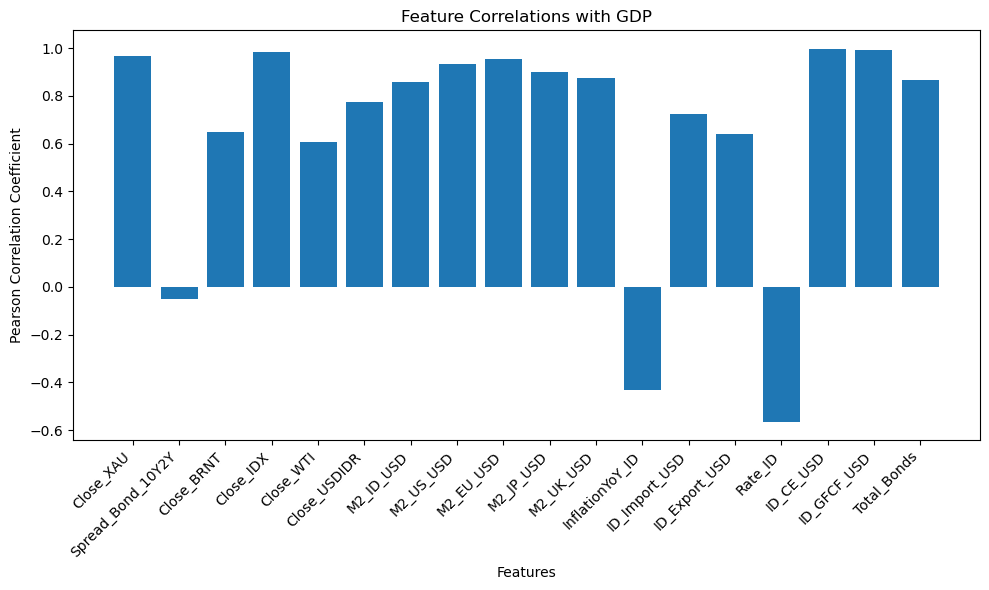

In [22]:
# Extract features and target

data_correlation = data_subset
features = data_correlation.drop(['ID_GDP_USD'], axis=1)
target = data_correlation['ID_GDP_USD']

# Calculate Pearson correlation coefficients
correlations = features.corrwith(target)

# Plot correlations
plt.figure(figsize=(10, 6))
plt.bar(features.columns, correlations)
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.title("Feature Correlations with GDP")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [23]:
data_with_bond

Close_XAU  Spread_Bond_10Y2Y  Close_BRNT    Close_IDX  Close_WTI  \
Date                                                                          
01-2006   585.630000          29.533333   65.920000  1304.481500  67.062500   
02-2006   579.672222          28.857143   62.803158  1292.076000  63.026111   
03-2006   576.908333         -27.935484   64.589167  1328.442727  64.716250   
04-2006   624.444444         -46.866667   70.162105  1440.700526  69.855882   
05-2006   646.940000         -70.451613   68.802000  1400.940000  69.068500   
...              ...                ...         ...          ...        ...   
08-2023  1943.490909          26.565217   83.570909  6894.936667  79.384091   
09-2023  1926.014286          34.380952   89.359524  6903.906000  85.591429   
10-2023  1954.436364          43.545455   86.855000  6815.352273  82.598636   
11-2023  1985.525000          18.272727   81.930909  6929.804545  77.345909   
12-2023  2013.854762          17.428571   79.384500  7056.916000  74.387143   

         Close_USDIDR   M2_ID_USD  M2_US_USD     M2_EU_USD    M2_JP_USD  \
Date                                                                      
01-2006   9308.928571  128.364826     6724.3   7571.994733  6130.578198   
02-2006   9237.950000  129.657770     6748.6   7470.628129  6022.892767   
03-2006   9137.333333  131.192325     6762.9   7584.603150  6034.779574   
04-2006   8979.400000  133.318707     6800.1   7895.056665  6142.924845   
05-2006   9196.380952  135.038447     6806.9   8068.260020  6274.797948   
...               ...         ...        ...           ...          ...   
08-2023  15264.172727  301.982170    20763.4  16289.039344  8590.628984   
09-2023  15352.666667  304.247666    20710.1  16108.033126  8522.884023   
10-2023  15605.409091  300.610639    20698.7  16001.764705  8488.143345   
11-2023  15425.500000  306.359146    20724.9  16362.080543  8475.408559   
12-2023  15370.714286  321.099261    20786.1  16611.457238  8777.638422   

           M2_UK_USD  InflationYoY_ID  ID_Import_USD  ID_Export_USD  Rate_ID  \
Date                                                                           
01-2006  2405.009055           17.110       0.000471       0.000812    12.75   
02-2006  2391.532002           17.030       0.000490       0.000801    12.75   
03-2006  2412.923736           17.920       0.000483       0.000820    12.75   
04-2006  2497.809283           15.740       0.000532       0.000851    12.75   
05-2006  2586.568717           15.400       0.000554       0.000910    12.50   
...              ...              ...            ...            ...      ...   
08-2023  3798.653240            3.175       0.001237       0.001441     5.75   
09-2023  3669.632442            2.280       0.001130       0.001351     5.75   
10-2023  3654.982574            2.280       0.001197       0.001419     6.00   
11-2023  3734.008014            2.710       0.001270       0.001426     6.00   
12-2023  3781.982653            2.610       0.001243       0.001457     6.00   

          ID_CE_USD  ID_GFCF_USD  ID_GDP_USD  Total_Bonds  
Date                                                       
01-2006   60.336661    19.695142   82.347572        90.98  
02-2006   60.173235    20.005232   83.856303        93.68  
03-2006   60.201919    20.386035   85.665366        95.73  
04-2006   62.252675    21.124277   88.285297       101.30  
05-2006   61.752372    20.996593   87.289229        97.75  
...             ...          ...         ...          ...  
08-2023  211.647325   100.500326  345.325670       405.34  
09-2023  210.139064   102.394394  344.890052       403.43  
10-2023  211.570978   101.783554  339.465799       397.90  
11-2023  218.930235   104.030404  343.588430       416.23  
12-2023  224.619685   105.464715  344.977071       427.71  

[216 rows x 19 columns]

In [24]:
print("COUNT NAN",data_with_bond.isnull().sum())

COUNT NAN Close_XAU            0
Spread_Bond_10Y2Y    0
Close_BRNT           0
Close_IDX            0
Close_WTI            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
InflationYoY_ID      0
ID_Import_USD        0
ID_Export_USD        0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
dtype: int64


                   Close_XAU  Spread_Bond_10Y2Y  Close_BRNT  Close_IDX  \
Close_XAU           1.000000           0.140799    0.714929   0.924470   
Spread_Bond_10Y2Y   0.140799           1.000000    0.103932  -0.126467   
Close_BRNT          0.714929           0.103932    1.000000   0.590968   
Close_IDX           0.924470          -0.126467    0.590968   1.000000   
Close_WTI           0.669117           0.151082    0.990159   0.549633   
Close_USDIDR        0.695527          -0.117291    0.286987   0.815349   
M2_ID_USD           0.822305           0.113472    0.516465   0.845694   
M2_US_USD           0.890229           0.077705    0.466621   0.930648   
M2_EU_USD           0.950273           0.260977    0.702946   0.929697   
M2_JP_USD           0.941051           0.256178    0.689853   0.852954   
M2_UK_USD           0.904215           0.470411    0.817429   0.837255   
InflationYoY_ID    -0.407756          -0.397265   -0.364540  -0.400360   
ID_Import_USD       0.771657          

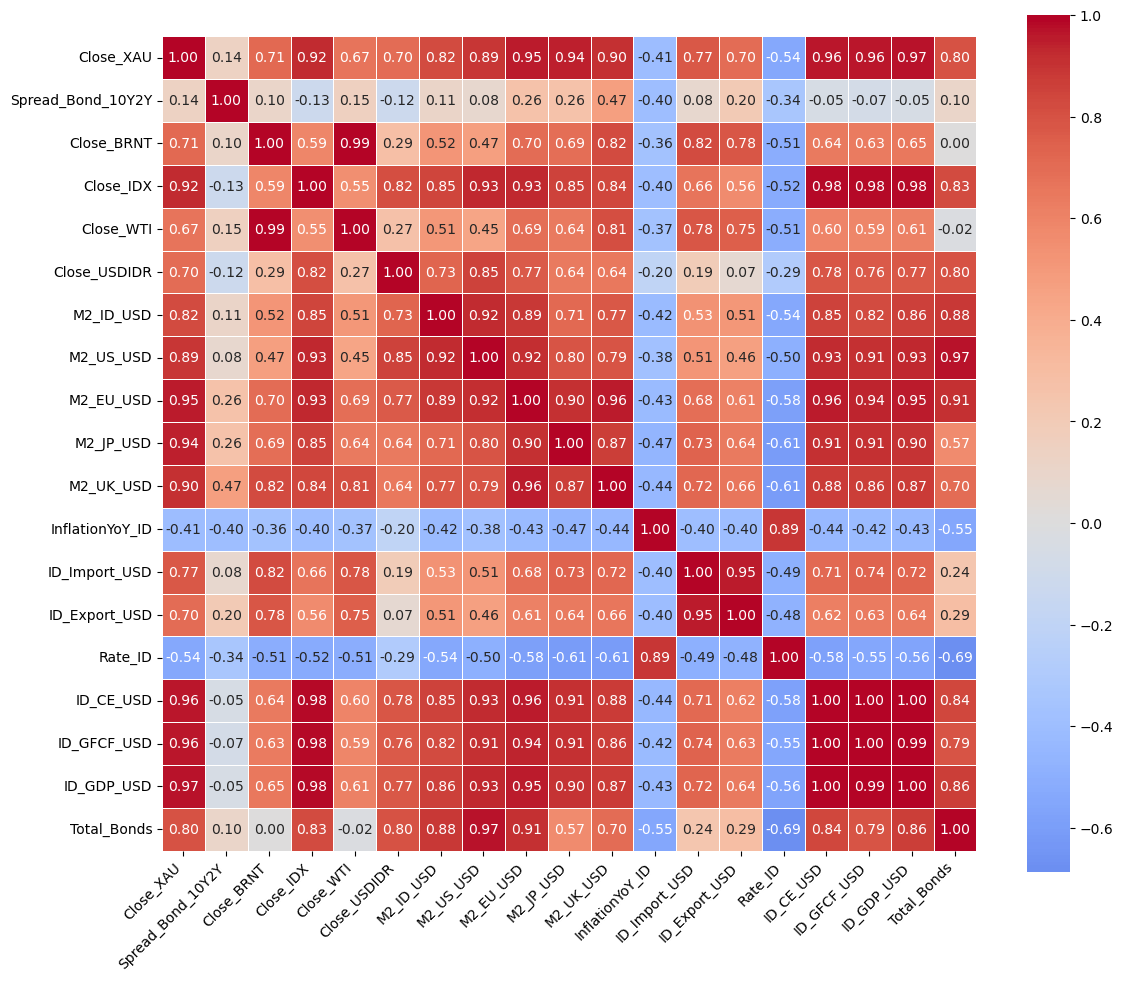

In [25]:
# Assuming 'data' is your DataFrame and 'ID_GDP_USD' is your target variable
correlation_matrix = data_correlation.corr()

# Display the correlation matrix
print(correlation_matrix)
      
      # Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=.5)

# Adjust layout to make room for the rotated x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


Index(['01-1997', '02-1997', '03-1997', '04-1997', '05-1997', '06-1997',
       '07-1997', '08-1997', '09-1997', '10-1997',
       ...
       '03-2023', '04-2023', '05-2023', '06-2023', '07-2023', '08-2023',
       '09-2023', '10-2023', '11-2023', '12-2023'],
      dtype='object', name='Date', length=324)


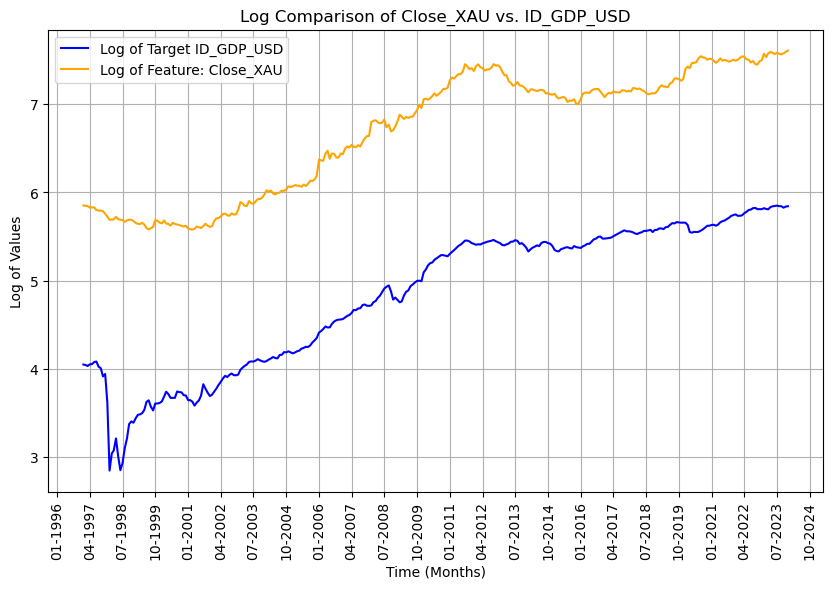

C:\Users\ITSEC\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


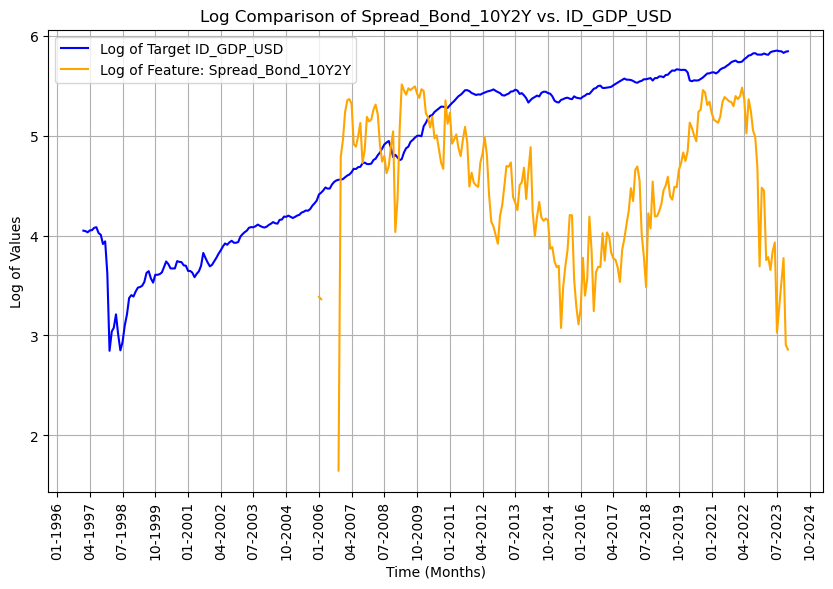

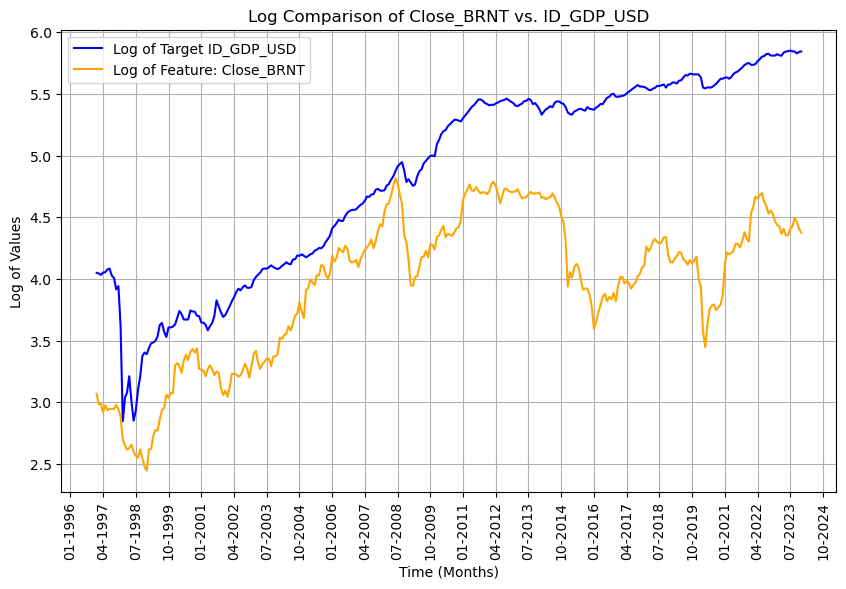

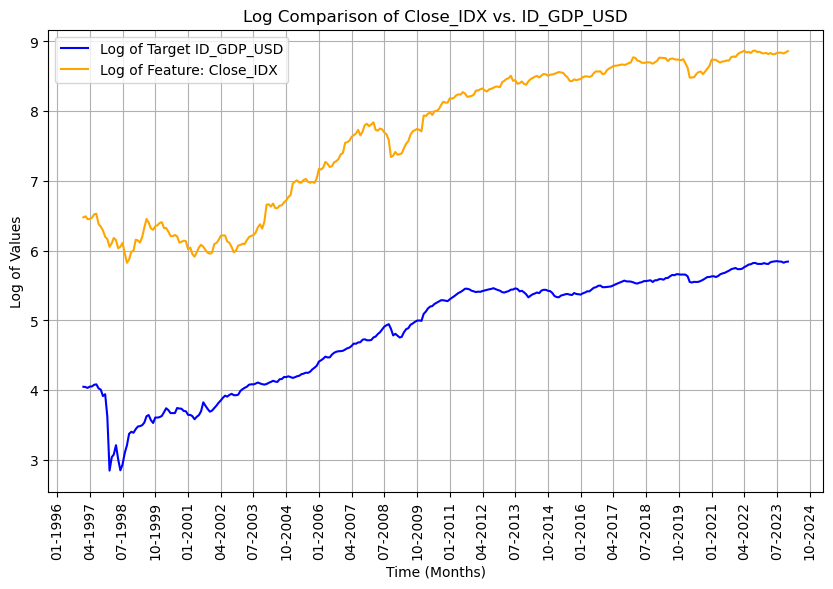

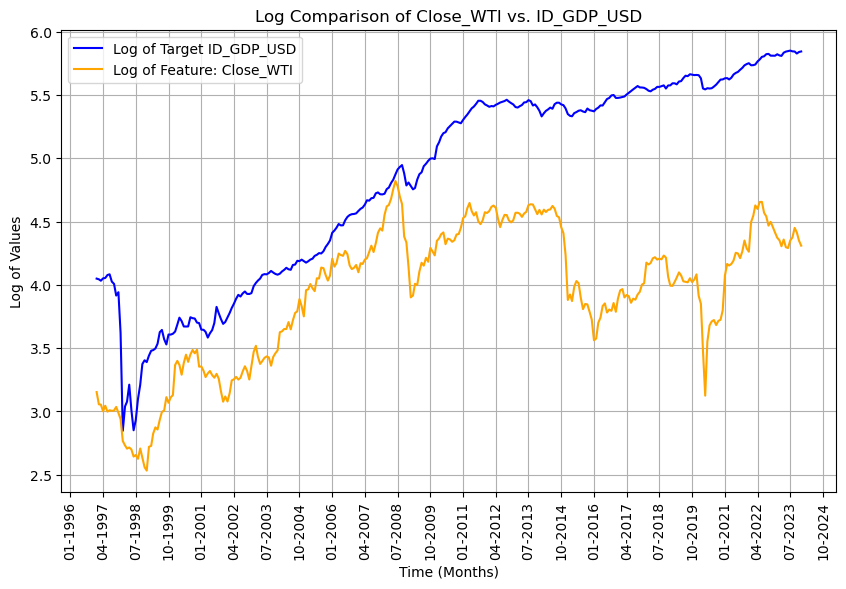

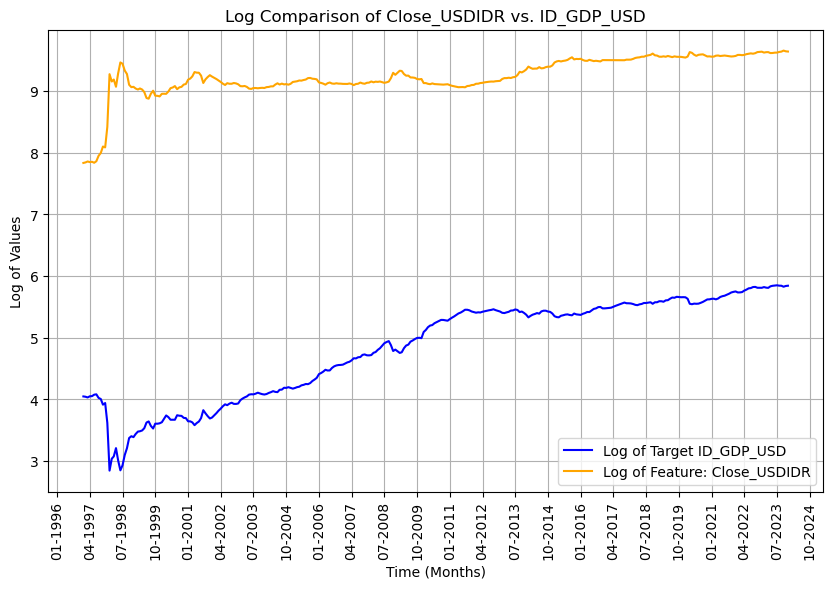

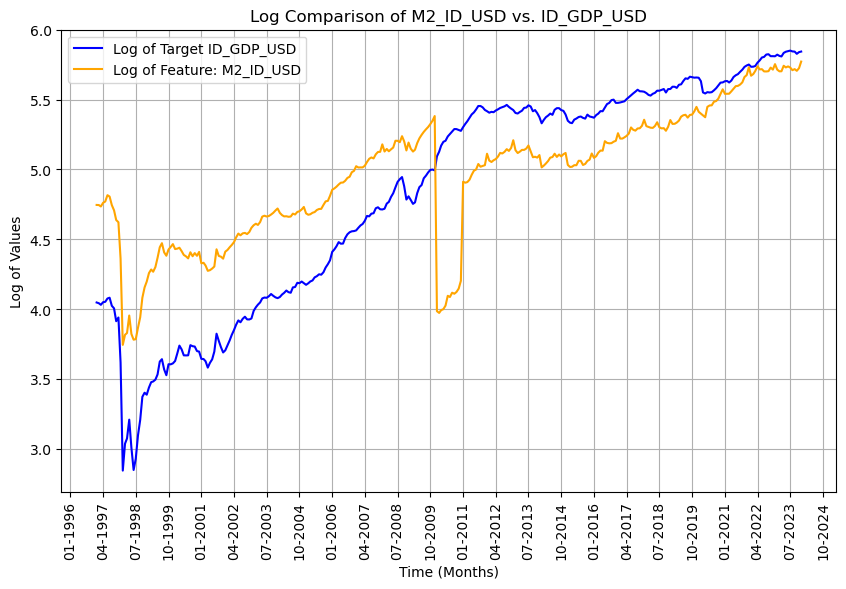

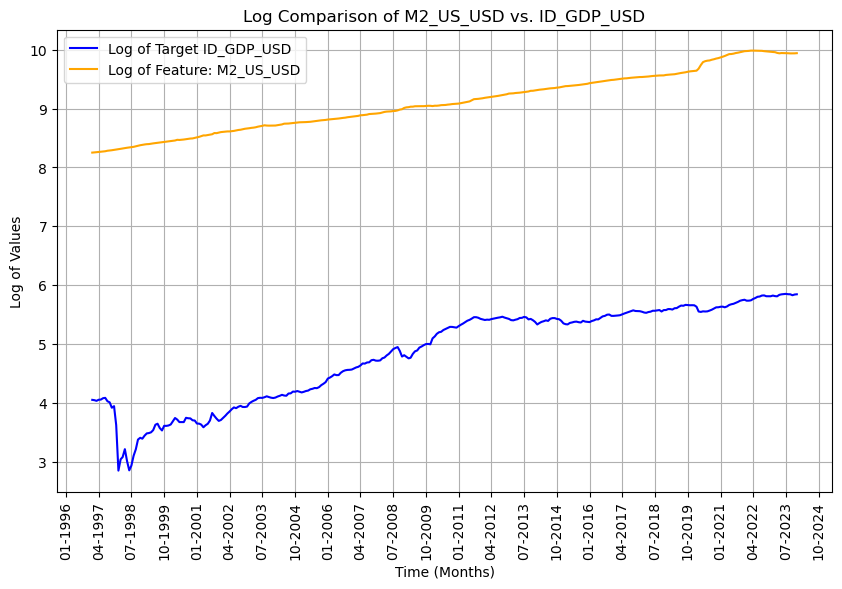

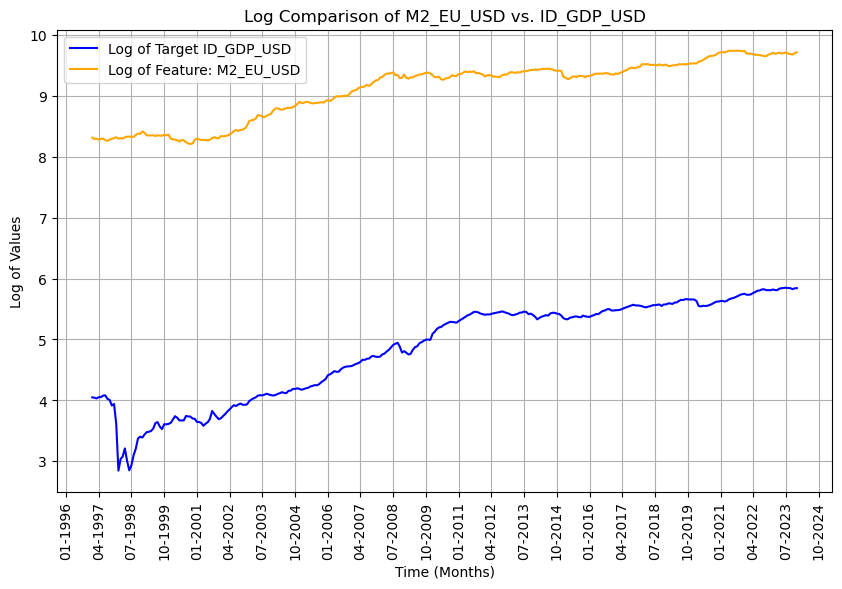

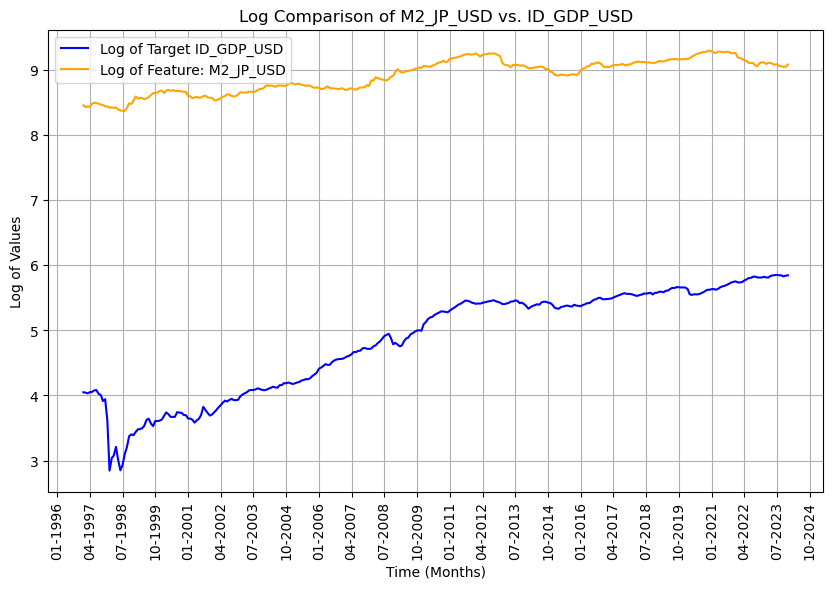

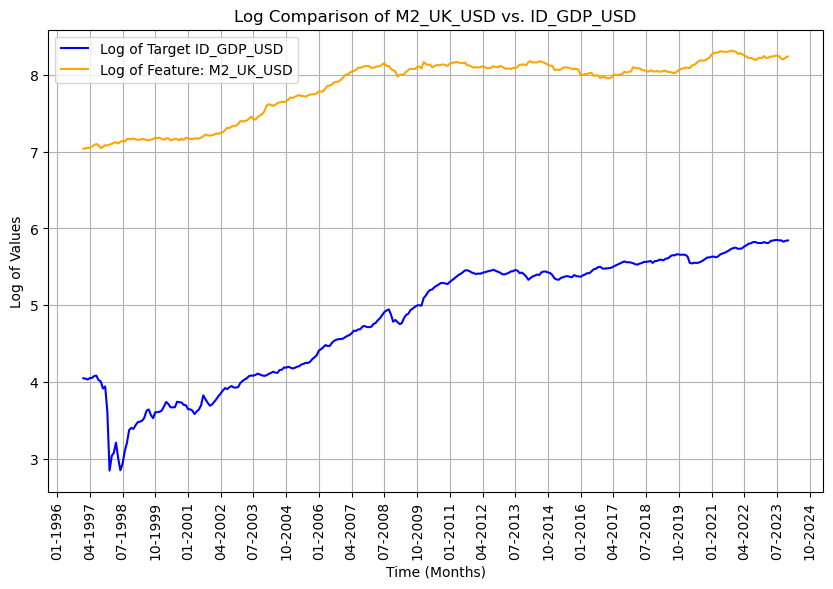

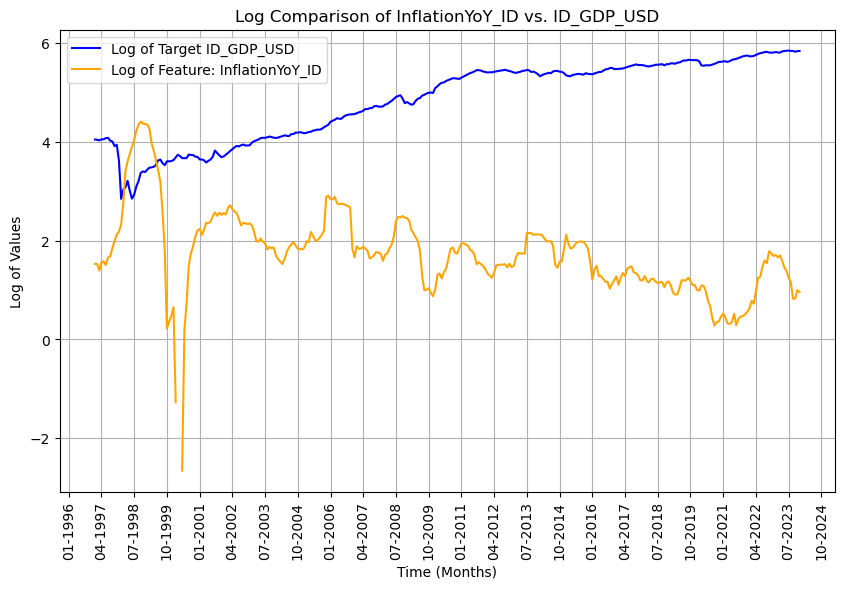

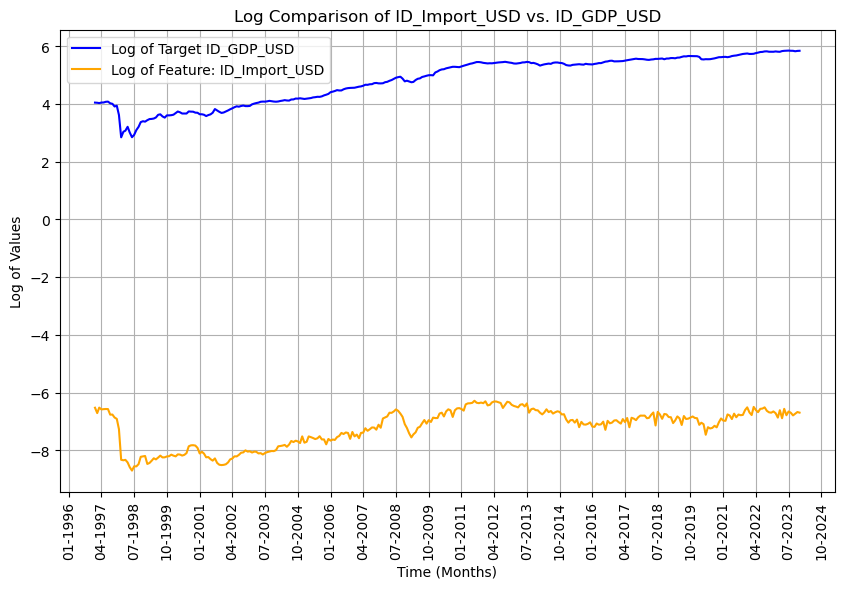

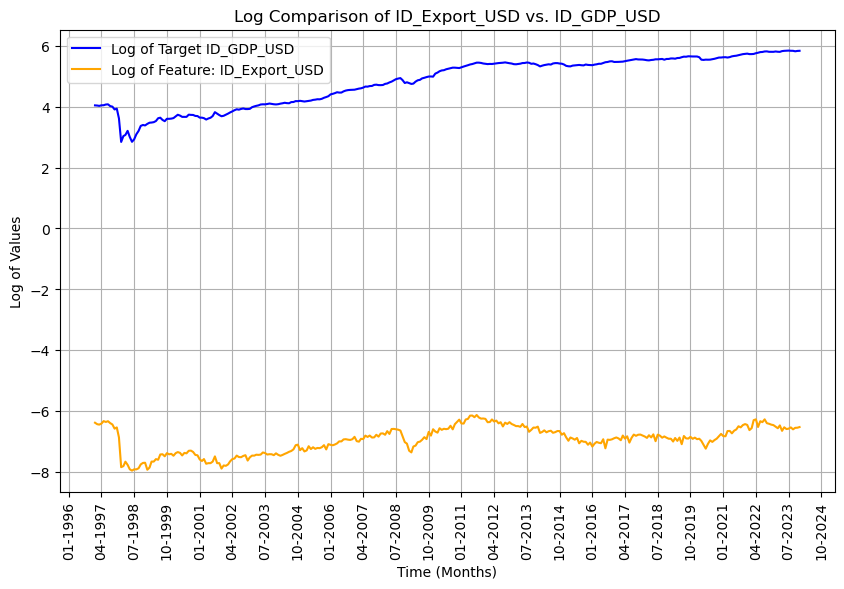

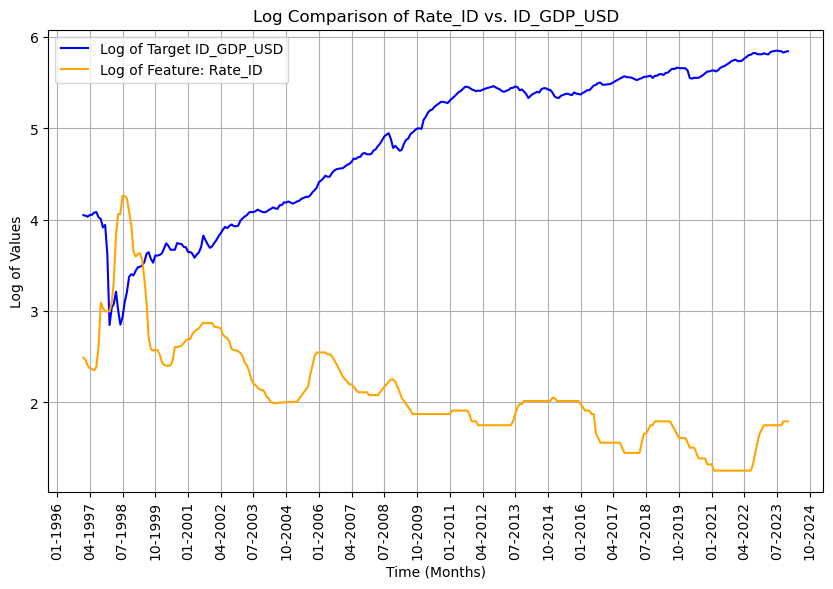

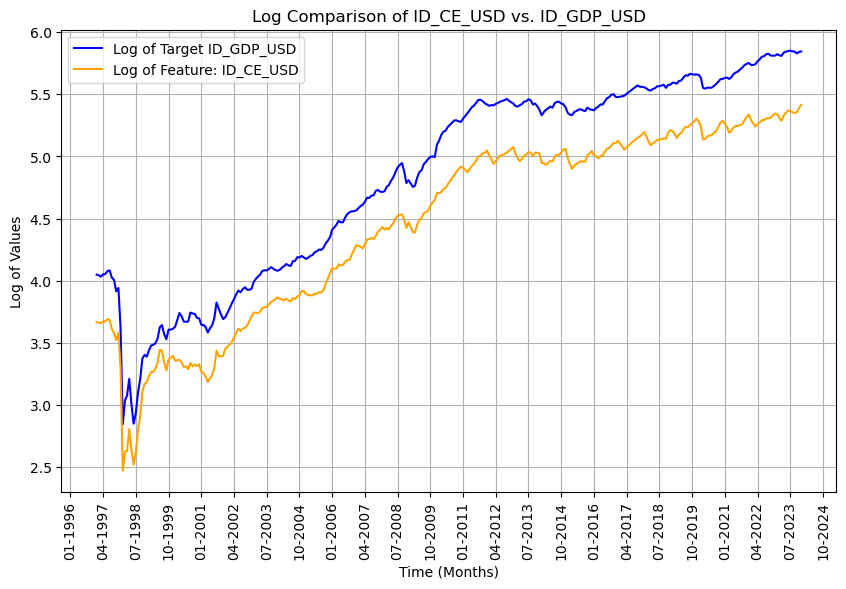

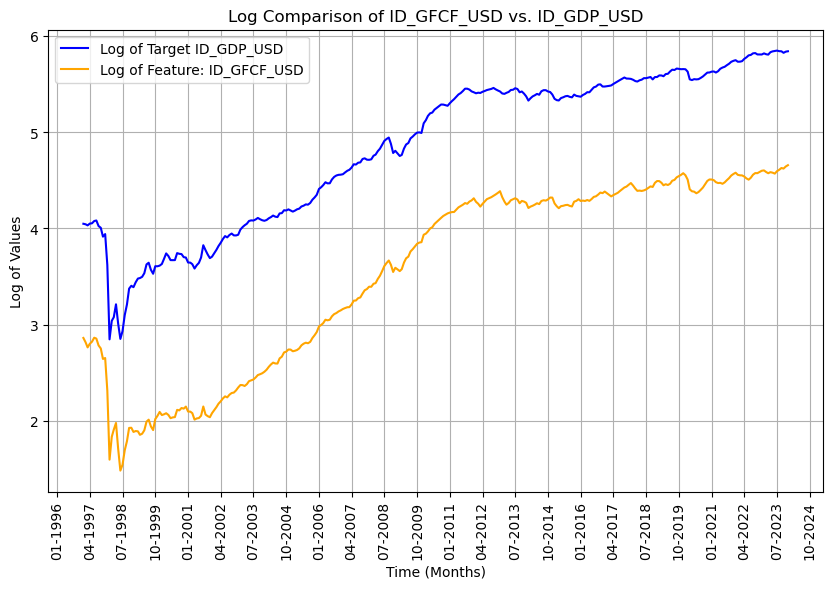

In [15]:
# Assuming 'data' is your DataFrame, and the index is already datetime
data_visualize = data_subset
target = 'ID_GDP_USD'
features = data_visualize.columns.drop(target)  # Exclude the target from features
print(data_visualize.index)
date_visualize = [datetime.strptime(date, '%m-%Y') for date in data_visualize.index]
# Loop through each feature and create a plot with log-transformed data
for feature in features:
    plt.figure(figsize=(10, 6))
    
    # Apply log transformation to target and feature avoiding log(0) by adding a small constant (1e-9 if zeros are expected)
    log_target = np.log(data_visualize[target] + 1e-9)
    log_feature = np.log(data_visualize[feature] + 1e-9)

    plt.plot(date_visualize, log_target, label="Log of Target " + target, color="blue")
    plt.plot(date_visualize, log_feature, label="Log of Feature: " + feature, color="orange")

    # Formatting the date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Adjust interval as needed
    plt.xticks(rotation=90)
    plt.xlabel("Time (Months)")
    plt.ylabel("Log of Values")
    plt.title(f"Log Comparison of {feature} vs. {target}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
List_of_Top_Models = []
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
n_prev_days = 9

data_DL = data_with_bond
PCA_Enable_DL = False

target_DL = data_DL['ID_GDP_USD'].values
features_DL = data_DL.drop(['ID_GDP_USD'], axis=1)

numeric_features_DL = np.array(features_DL.values, dtype=np.float64)
scaled_features_DL = features_scaler.fit_transform(numeric_features_DL)
target_DL = target_scaler.fit_transform(np.array(target_DL.reshape(-1, 1), dtype=np.float64))


if PCA_Enable_DL == True:
    pca = PCA(n_components=0.90)  # retains 95% of the variance
    print("NaN in each column:\n", np.isnan(scaled_features_DL).sum(axis=0))
    scaled_features_DL = pca.fit_transform(scaled_features_DL)
    print("PCA ENABLED")
    
print("Scaled Values: ", len(scaled_features_DL))
# Prepare input sequences for training/validation
input_sequences_DL = [scaled_features_DL[i-n_prev_days:i, :] for i in range(n_prev_days, len(scaled_features_DL))]
input_sequences_DL = np.array(input_sequences_DL)
input_sequences_DL.shape

Scaled Values:  216


(207, 9, 18)

In [27]:
def LSTM_process(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['ID_GDP_USD'].values
    features = data.drop(['ID_GDP_USD'], axis=1)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    print(target.shape)
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 15

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units= 48, recurrent_dropout=0.2, return_sequences = True, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 12, recurrent_dropout=0.2))
        
        model.add(Dense(3))
        model.add(Dense(1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('GDP_LSTM_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=10000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['LSTM', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)
    
    return model_performance

In [28]:
model_performance_LSTM = LSTM_process(data_with_bond, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_IDX',
       'Close_WTI', 'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
       'M2_JP_USD', 'M2_UK_USD', 'InflationYoY_ID', 'ID_Import_USD',
       'ID_Export_USD', 'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD',
       'Total_Bonds'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_BRNT           0
Close_IDX            0
Close_WTI            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
InflationYoY_ID      0
ID_Import_USD        0
ID_Export_USD        0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
dtype: int64
(216, 18)
(216, 1)
(216, 18)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.5288 - mean_absolute_error: 0.2801 - val_loss: 3.6294 - val_mean_absolute_error: 0.4143 - learning_rate: 0.0010
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.3952 - mean_absolute_error: 0.1801 - val_loss: 3.4726 - val_mean_absolute_error: 0.2908 - learning_rate: 0.0010
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 3.2987 - mean_absolute_error: 0.1170 - val_loss: 3.3184 - val_mean_absolute_error: 0.1701 - learning_rate: 0.0010
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.2275 - mean_absolute_error: 0.0792 - val_loss: 3.1869 - val_mean_absolute_error: 0.0728 - learning_rate: 0.0010
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 3.2279 - mean_absolute_error: 0.1138 - val_loss: 3.1289 - val_mean_absolute_error: 0.0493 - learning_rate: 0.0010
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 3.2103 - mean_absolute_error: 0.1306 - val_loss: 3.0935 - val_mean_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.0523 - mean_absolute_error: 0.0163 - val_loss: 2.0692 - val_mean_absolute_error: 0.0605 - learning_rate: 0.0010
Epoch 41/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.0282 - mean_absolute_error: 0.0195 - val_loss: 2.0417 - val_mean_absolute_error: 0.0600 - learning_rate: 0.0010
Epoch 42/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 1.9961 - mean_absolute_error: 0.0144 - val_loss: 2.0163 - val_mean_absolute_error: 0.0614 - learning_rate: 0.0010
Epoch 43/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.9724 - mean_absolute_error: 0.0175 - val_loss: 1.9947 - val_mean_absolute_error: 0.0664 - learning_rate: 0.0010
Epoch 44/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 1.9457 - mean_absolute_error: 0.0174 - val_loss: 1.9745 - val_mean_absolute_error: 0.0726 - learning_rate: 0.0010
Epoch 45/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.9180 - mean_absolute_error: 0.0161 - val_loss: 1.9504 - val_mean_absolut

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.1492 - mean_absolute_error: 0.0156 - val_loss: 1.1655 - val_mean_absolute_error: 0.0507 - learning_rate: 0.0010
Epoch 80/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.1227 - mean_absolute_error: 0.0080 - val_loss: 1.1415 - val_mean_absolute_error: 0.0453 - learning_rate: 0.0010
Epoch 81/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.1082 - mean_absolute_error: 0.0120 - val_loss: 1.1206 - val_mean_absolute_error: 0.0428 - learning_rate: 0.0010
Epoch 82/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.0896 - mean_absolute_error: 0.0118 - val_loss: 1.1038 - val_mean_absolute_error: 0.0442 - learning_rate: 0.0010
Epoch 83/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.0723 - mean_absolute_error: 0.0127 - val_loss: 1.0916 - val_mean_absolute_error: 0.0501 - learning_rate: 0.0010
Epoch 84/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.0486 - mean_absolute_error: 0.0070 - val_loss: 1.0828 - val_mean_absolu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.5448 - mean_absolute_error: 0.0075 - val_loss: 0.5716 - val_mean_absolute_error: 0.0459 - learning_rate: 0.0010
Epoch 119/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.5309 - mean_absolute_error: 0.0053 - val_loss: 0.5663 - val_mean_absolute_error: 0.0520 - learning_rate: 0.0010
Epoch 120/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.5219 - mean_absolute_error: 0.0075 - val_loss: 0.5559 - val_mean_absolute_error: 0.0529 - learning_rate: 0.0010
Epoch 121/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.5100 - mean_absolute_error: 0.0070 - val_loss: 0.5423 - val_mean_absolute_error: 0.0504 - learning_rate: 0.0010
Epoch 122/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.4967 - mean_absolute_error: 0.0048 - val_loss: 0.5269 - val_mean_absolute_error: 0.0458 - learning_rate: 0.0010
Epoch 123/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.4837 - mean_absolute_error: 0.0027 - val_loss: 0.5147 - val_mean_ab

Epoch 157/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2237 - mean_absolute_error: 0.0057 - val_loss: 0.2502 - val_mean_absolute_error: 0.0370 - learning_rate: 0.0010
Epoch 158/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2214 - mean_absolute_error: 0.0082 - val_loss: 0.2452 - val_mean_absolute_error: 0.0367 - learning_rate: 0.0010
Epoch 159/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2143 - mean_absolute_error: 0.0059 - val_loss: 0.2418 - val_mean_absolute_error: 0.0378 - learning_rate: 0.0010
Epoch 160/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2096 - mean_absolute_error: 0.0056 - val_loss: 0.2421 - val_mean_absolute_error: 0.0425 - learning_rate: 0.0010
Epoch 161/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2046 - mean_absolute_error: 0.0050 - val_loss: 0.2407 - val_mean_absolute_error: 0.0452 - learning_rate: 0.0010
Epoch 162/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1995 - mean_absolute_error: 0.0040 - val_loss: 0.23

Epoch 196/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1270 - mean_absolute_error: 0.0047 - val_loss: 0.1573 - val_mean_absolute_error: 0.0363 - learning_rate: 0.0010
Epoch 197/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1265 - mean_absolute_error: 0.0054 - val_loss: 0.1535 - val_mean_absolute_error: 0.0336 - learning_rate: 0.0010
Epoch 198/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1252 - mean_absolute_error: 0.0053 - val_loss: 0.1513 - val_mean_absolute_error: 0.0327 - learning_rate: 0.0010
Epoch 199/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1254 - mean_absolute_error: 0.0067 - val_loss: 0.1515 - val_mean_absolute_error: 0.0341 - learning_rate: 0.0010
Epoch 200/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1228 - mean_absolute_error: 0.0054 - val_loss: 0.1549 - val_mean_absolute_error: 0.0385 - learning_rate: 0.0010
Epoch 201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1214 - mean_absolute_error: 0.0051 - val_loss: 0.155

Epoch 234/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0950 - mean_absolute_error: 0.0037 - val_loss: 0.1244 - val_mean_absolute_error: 0.0334 - learning_rate: 1.0000e-04
Epoch 235/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0973 - mean_absolute_error: 0.0063 - val_loss: 0.1246 - val_mean_absolute_error: 0.0338 - learning_rate: 1.0000e-04
Epoch 236/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0947 - mean_absolute_error: 0.0039 - val_loss: 0.1248 - val_mean_absolute_error: 0.0341 - learning_rate: 1.0000e-04
Epoch 237/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0947 - mean_absolute_error: 0.0040 - val_loss: 0.1250 - val_mean_absolute_error: 0.0344 - learning_rate: 1.0000e-04
Epoch 238/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0950 - mean_absolute_error: 0.0044
Epoch 238: ReduceLROnPlateau reducing learning rate to 0.0001.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0950 - mean_absolute_error: 0.0044 - val_loss: 0.1250 - val_mean_absol

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0911 - mean_absolute_error: 0.0039 - val_loss: 0.1196 - val_mean_absolute_error: 0.0325 - learning_rate: 1.0000e-04
Epoch 272/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0909 - mean_absolute_error: 0.0038 - val_loss: 0.1196 - val_mean_absolute_error: 0.0325 - learning_rate: 1.0000e-04
Epoch 273/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0908 - mean_absolute_error: 0.0038 - val_loss: 0.1194 - val_mean_absolute_error: 0.0325 - learning_rate: 1.0000e-04
Epoch 274/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0903 - mean_absolute_error: 0.0033 - val_loss: 0.1192 - val_mean_absolute_error: 0.0324 - learning_rate: 1.0000e-04
Epoch 275/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0903 - mean_absolute_error: 0.0035 - val_loss: 0.1190 - val_mean_absolute_error: 0.0322 - learning_rate: 1.0000e-04
Epoch 276/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0903 - mean_absolute_error: 0.0035 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0879 - mean_absolute_error: 0.0034 - val_loss: 0.1165 - val_mean_absolute_error: 0.0321 - learning_rate: 1.0000e-04
Epoch 310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0882 - mean_absolute_error: 0.0037 - val_loss: 0.1164 - val_mean_absolute_error: 0.0320 - learning_rate: 1.0000e-04
Epoch 311/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0885 - mean_absolute_error: 0.0041 - val_loss: 0.1162 - val_mean_absolute_error: 0.0319 - learning_rate: 1.0000e-04
Epoch 312/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0886 - mean_absolute_error: 0.0043 - val_loss: 0.1160 - val_mean_absolute_error: 0.0318 - learning_rate: 1.0000e-04
Epoch 313/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0888 - mean_absolute_error: 0.0045 - val_loss: 0.1158 - val_mean_absolute_error: 0.0317 - learning_rate: 1.0000e-04
Epoch 314/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0875 - mean_absolute_error: 0.0034 - val_loss: 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 3.4727 - mean_absolute_error: 0.2618 - val_loss: 3.4559 - val_mean_absolute_error: 0.2808 - learning_rate: 0.0010
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.3922 - mean_absolute_error: 0.2171 - val_loss: 3.3632 - val_mean_absolute_error: 0.2235 - learning_rate: 0.0010
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 3.3057 - mean_absolute_error: 0.1660 - val_loss: 3.2710 - val_mean_absolute_error: 0.1665 - learning_rate: 0.0010
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 3.2202 - mean_absolute_error: 0.1157 - val_loss: 3.1795 - val_mean_absolute_error: 0.1097 - learning_rate: 0.0010
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 3.1529 - mean_absolute_error: 0.0832 - val_loss: 3.0903 - val_mean_absolute_error: 0.0552 - learning_rate: 0.0010
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 3.1028 - mean_absolute_error: 0.0677 - val_loss: 3.0311 - val_mean_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.9738 - mean_absolute_error: 0.0129 - val_loss: 1.9703 - val_mean_absolute_error: 0.0371 - learning_rate: 0.0010
Epoch 41/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.9493 - mean_absolute_error: 0.0160 - val_loss: 1.9419 - val_mean_absolute_error: 0.0362 - learning_rate: 0.0010
Epoch 42/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.9189 - mean_absolute_error: 0.0132 - val_loss: 1.9135 - val_mean_absolute_error: 0.0351 - learning_rate: 0.0010
Epoch 43/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.8927 - mean_absolute_error: 0.0143 - val_loss: 1.8851 - val_mean_absolute_error: 0.0338 - learning_rate: 0.0010
Epoch 44/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.8652 - mean_absolute_error: 0.0140 - val_loss: 1.8578 - val_mean_absolute_error: 0.0334 - learning_rate: 0.0010
Epoch 45/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.8383 - mean_absolute_error: 0.0139 - val_loss: 1.8315 - val_mean_absolu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.0623 - mean_absolute_error: 0.0115 - val_loss: 1.0731 - val_mean_absolute_error: 0.0412 - learning_rate: 0.0010
Epoch 80/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.0393 - mean_absolute_error: 0.0074 - val_loss: 1.0567 - val_mean_absolute_error: 0.0434 - learning_rate: 0.0010
Epoch 81/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.0201 - mean_absolute_error: 0.0069 - val_loss: 1.0402 - val_mean_absolute_error: 0.0454 - learning_rate: 0.0010
Epoch 82/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.0026 - mean_absolute_error: 0.0078 - val_loss: 1.0241 - val_mean_absolute_error: 0.0476 - learning_rate: 0.0010
Epoch 83/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.9887 - mean_absolute_error: 0.0123 - val_loss: 1.0051 - val_mean_absolute_error: 0.0468 - learning_rate: 0.0010
Epoch 84/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.9703 - mean_absolute_error: 0.0120 - val_loss: 0.9845 - val_mean_absolu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.4761 - mean_absolute_error: 0.0090 - val_loss: 0.5032 - val_mean_absolute_error: 0.0471 - learning_rate: 0.0010
Epoch 119/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4693 - mean_absolute_error: 0.0132 - val_loss: 0.4904 - val_mean_absolute_error: 0.0452 - learning_rate: 0.0010
Epoch 120/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.4566 - mean_absolute_error: 0.0114 - val_loss: 0.4767 - val_mean_absolute_error: 0.0423 - learning_rate: 0.0010
Epoch 121/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4401 - mean_absolute_error: 0.0057 - val_loss: 0.4642 - val_mean_absolute_error: 0.0402 - learning_rate: 0.0010
Epoch 122/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4321 - mean_absolute_error: 0.0081 - val_loss: 0.4533 - val_mean_absolute_error: 0.0397 - learning_rate: 0.0010
Epoch 123/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.4269 - mean_absolute_error: 0.0133 - val_loss: 0.4429 - val_mean_a

Epoch 157/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1667 - mean_absolute_error: 0.0055 - val_loss: 0.1999 - val_mean_absolute_error: 0.0430 - learning_rate: 0.0010
Epoch 158/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1627 - mean_absolute_error: 0.0058 - val_loss: 0.1960 - val_mean_absolute_error: 0.0434 - learning_rate: 0.0010
Epoch 159/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1584 - mean_absolute_error: 0.0058 - val_loss: 0.1912 - val_mean_absolute_error: 0.0429 - learning_rate: 0.0010
Epoch 160/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1531 - mean_absolute_error: 0.0047 - val_loss: 0.1865 - val_mean_absolute_error: 0.0421 - learning_rate: 0.0010
Epoch 161/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1496 - mean_absolute_error: 0.0052 - val_loss: 0.1824 - val_mean_absolute_error: 0.0418 - learning_rate: 0.0010
Epoch 162/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1457 - mean_absolute_error: 0.0052 - val_loss: 0.1

Epoch 196/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0821 - mean_absolute_error: 0.0047 - val_loss: 0.1170 - val_mean_absolute_error: 0.0406 - learning_rate: 0.0010
Epoch 197/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0828 - mean_absolute_error: 0.0065 - val_loss: 0.1161 - val_mean_absolute_error: 0.0406 - learning_rate: 0.0010
Epoch 198/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0813 - mean_absolute_error: 0.0058 - val_loss: 0.1153 - val_mean_absolute_error: 0.0406 - learning_rate: 0.0010
Epoch 199/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0791 - mean_absolute_error: 0.0044 - val_loss: 0.1144 - val_mean_absolute_error: 0.0407 - learning_rate: 0.0010
Epoch 200/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0794 - mean_absolute_error: 0.0056 - val_loss: 0.1135 - val_mean_absolute_error: 0.0407 - learning_rate: 0.0010
Epoch 201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0771 - mean_absolute_error: 0.0043 - val_loss: 0.1

Epoch 235/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0576 - mean_absolute_error: 0.0048 - val_loss: 0.0938 - val_mean_absolute_error: 0.0414 - learning_rate: 0.0010
Epoch 236/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0571 - mean_absolute_error: 0.0047 - val_loss: 0.0932 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 237/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0562 - mean_absolute_error: 0.0043 - val_loss: 0.0927 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 238/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0549 - mean_absolute_error: 0.0035 - val_loss: 0.0923 - val_mean_absolute_error: 0.0414 - learning_rate: 0.0010
Epoch 239/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0553 - mean_absolute_error: 0.0044 - val_loss: 0.0923 - val_mean_absolute_error: 0.0418 - learning_rate: 0.0010
Epoch 240/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0551 - mean_absolute_error: 0.0045 - val_loss: 0.0

Epoch 274/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0460 - mean_absolute_error: 0.0071 - val_loss: 0.0795 - val_mean_absolute_error: 0.0410 - learning_rate: 0.0010
Epoch 275/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0438 - mean_absolute_error: 0.0053 - val_loss: 0.0795 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 276/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0422 - mean_absolute_error: 0.0040 - val_loss: 0.0798 - val_mean_absolute_error: 0.0417 - learning_rate: 0.0010
Epoch 277/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0437 - mean_absolute_error: 0.0056 - val_loss: 0.0795 - val_mean_absolute_error: 0.0418 - learning_rate: 0.0010
Epoch 278/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0427 - mean_absolute_error: 0.0050 - val_loss: 0.0787 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 279/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0429 - mean_absolute_error: 0.0056 - val_loss: 0.07

Epoch 313/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0352 - mean_absolute_error: 0.0061 - val_loss: 0.0717 - val_mean_absolute_error: 0.0426 - learning_rate: 0.0010
Epoch 314/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0364 - mean_absolute_error: 0.0073 - val_loss: 0.0701 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 315/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0334 - mean_absolute_error: 0.0046 - val_loss: 0.0693 - val_mean_absolute_error: 0.0407 - learning_rate: 0.0010
Epoch 316/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0348 - mean_absolute_error: 0.0063 - val_loss: 0.0690 - val_mean_absolute_error: 0.0406 - learning_rate: 0.0010
Epoch 317/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0332 - mean_absolute_error: 0.0049 - val_loss: 0.0692 - val_mean_absolute_error: 0.0411 - learning_rate: 0.0010
Epoch 318/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0330 - mean_absolute_error: 0.0049 - val_loss: 0.0690

Epoch 352/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0277 - mean_absolute_error: 0.0047 - val_loss: 0.0649 - val_mean_absolute_error: 0.0420 - learning_rate: 0.0010
Epoch 353/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0267 - mean_absolute_error: 0.0038 - val_loss: 0.0639 - val_mean_absolute_error: 0.0412 - learning_rate: 0.0010
Epoch 354/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0287 - mean_absolute_error: 0.0060 - val_loss: 0.0637 - val_mean_absolute_error: 0.0412 - learning_rate: 0.0010
Epoch 355/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0272 - mean_absolute_error: 0.0046 - val_loss: 0.0635 - val_mean_absolute_error: 0.0410 - learning_rate: 0.0010
Epoch 356/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0274 - mean_absolute_error: 0.0050 - val_loss: 0.0636 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 357/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0264 - mean_absolute_error: 0.0041 - val_loss: 0.0637

Epoch 390/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0226 - mean_absolute_error: 0.0052 - val_loss: 0.0590 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 391/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0215 - mean_absolute_error: 0.0041 - val_loss: 0.0590 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 392/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0216 - mean_absolute_error: 0.0042 - val_loss: 0.0590 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 393/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0225 - mean_absolute_error: 0.0052 - val_loss: 0.0589 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 394/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0230 - mean_absolute_error: 0.0058 - val_loss: 0.0589 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 395/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0216 - mean_absolute_error: 0.004

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0203 - mean_absolute_error: 0.0043 - val_loss: 0.0580 - val_mean_absolute_error: 0.0420 - learning_rate: 1.0000e-04
Epoch 428/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0210 - mean_absolute_error: 0.0049 - val_loss: 0.0581 - val_mean_absolute_error: 0.0421 - learning_rate: 1.0000e-04
Epoch 429/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0196 - mean_absolute_error: 0.0035 - val_loss: 0.0581 - val_mean_absolute_error: 0.0421 - learning_rate: 1.0000e-04
Epoch 430/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0202 - mean_absolute_error: 0.0042 - val_loss: 0.0581 - val_mean_absolute_error: 0.0421 - learning_rate: 1.0000e-04
Epoch 431/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0200 - mean_absolute_error: 0.0040 - val_loss: 0.0580 - val_mean_absolute_error: 0.0420 - learning_rate: 1.0000e-04
Epoch 432/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0202 - mean_absolute_error: 0.0042 - val_loss: 0.05

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 787ms/step - loss: 3.5049 - mean_absolute_error: 0.2677 - val_loss: 3.3930 - val_mean_absolute_error: 0.2178 - learning_rate: 0.0010
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 3.2821 - mean_absolute_error: 0.1130 - val_loss: 3.1781 - val_mean_absolute_error: 0.0706 - learning_rate: 0.0010
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 3.1692 - mean_absolute_error: 0.0679 - val_loss: 3.0963 - val_mean_absolute_error: 0.0582 - learning_rate: 0.0010
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.1224 - mean_absolute_error: 0.0906 - val_loss: 3.0211 - val_mean_absolute_error: 0.0517 - learning_rate: 0.0010
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.0298 - mean_absolute_error: 0.0666 - val_loss: 2.9868 - val_mean_absolute_error: 0.0848 - learning_rate: 0.0010
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.9362 - mean_absolute_error: 0.0403 - val_loss: 2.9720 - val_mean_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.1239 - mean_absolute_error: 0.0183 - val_loss: 1.1729 - val_mean_absolute_error: 0.1022 - learning_rate: 0.0010
Epoch 41/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 1.0871 - mean_absolute_error: 0.0197 - val_loss: 1.1299 - val_mean_absolute_error: 0.0966 - learning_rate: 0.0010
Epoch 42/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.0470 - mean_absolute_error: 0.0170 - val_loss: 1.0858 - val_mean_absolute_error: 0.0893 - learning_rate: 0.0010
Epoch 43/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.0121 - mean_absolute_error: 0.0189 - val_loss: 1.0503 - val_mean_absolute_error: 0.0901 - learning_rate: 0.0010
Epoch 44/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.9736 - mean_absolute_error: 0.0167 - val_loss: 1.0202 - val_mean_absolute_error: 0.0953 - learning_rate: 0.0010
Epoch 45/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.9382 - mean_absolute_error: 0.0165 - val_loss: 0.9896 - val_mean_absolut

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2054 - mean_absolute_error: 0.0200 - val_loss: 0.2838 - val_mean_absolute_error: 0.1068 - learning_rate: 0.0010
Epoch 80/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1947 - mean_absolute_error: 0.0185 - val_loss: 0.2735 - val_mean_absolute_error: 0.1055 - learning_rate: 0.0010
Epoch 81/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1858 - mean_absolute_error: 0.0184 - val_loss: 0.2528 - val_mean_absolute_error: 0.0925 - learning_rate: 0.0010
Epoch 82/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1778 - mean_absolute_error: 0.0181 - val_loss: 0.2435 - val_mean_absolute_error: 0.0909 - learning_rate: 0.0010
Epoch 83/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1699 - mean_absolute_error: 0.0180 - val_loss: 0.2484 - val_mean_absolute_error: 0.1030 - learning_rate: 0.0010
Epoch 84/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1624 - mean_absolute_error: 0.0175 - val_loss: 0.2518 - val_mean_absolute_err

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0874 - mean_absolute_error: 0.0226 - val_loss: 0.1804 - val_mean_absolute_error: 0.1171 - learning_rate: 0.0010
Epoch 119/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0806 - mean_absolute_error: 0.0173 - val_loss: 0.1660 - val_mean_absolute_error: 0.1036 - learning_rate: 0.0010
Epoch 120/10000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0808 - mean_absolute_error: 0.0184
Epoch 120: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0810 - mean_absolute_error: 0.0186 - val_loss: 0.1715 - val_mean_absolute_error: 0.1103 - learning_rate: 0.0010
Epoch 121/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0769 - mean_absolute_error: 0.0157 - val_loss: 0.1728 - val_mean_absolute_error: 0.1123 - learning_rate: 1.0000e-04
Epoch 122/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0765 - mean_absolute_error: 0.0160 - val_loss: 0.1737 - val_mean_absolute_error: 0

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 818ms/step - loss: 3.3282 - mean_absolute_error: 0.0993 - val_loss: 3.5106 - val_mean_absolute_error: 0.3439 - learning_rate: 0.0010
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.2336 - mean_absolute_error: 0.0776 - val_loss: 3.4000 - val_mean_absolute_error: 0.3054 - learning_rate: 0.0010
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.1411 - mean_absolute_error: 0.0570 - val_loss: 3.2553 - val_mean_absolute_error: 0.2318 - learning_rate: 0.0010
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.0572 - mean_absolute_error: 0.0441 - val_loss: 3.1350 - val_mean_absolute_error: 0.1819 - learning_rate: 0.0010
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.9924 - mean_absolute_error: 0.0496 - val_loss: 3.0540 - val_mean_absolute_error: 0.1707 - learning_rate: 0.0010
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.9102 - mean_absolute_error: 0.0372 - val_loss: 2.9839 - val_mean_a

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.0772 - mean_absolute_error: 0.0186 - val_loss: 1.1460 - val_mean_absolute_error: 0.1197 - learning_rate: 0.0010
Epoch 41/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.0371 - mean_absolute_error: 0.0163 - val_loss: 1.1238 - val_mean_absolute_error: 0.1344 - learning_rate: 0.0010
Epoch 42/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.9983 - mean_absolute_error: 0.0142 - val_loss: 1.0914 - val_mean_absolute_error: 0.1375 - learning_rate: 0.0010
Epoch 43/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.9674 - mean_absolute_error: 0.0185 - val_loss: 1.0347 - val_mean_absolute_error: 0.1151 - learning_rate: 0.0010
Epoch 44/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.9333 - mean_absolute_error: 0.0188 - val_loss: 1.0135 - val_mean_absolute_error: 0.1281 - learning_rate: 0.0010
Epoch 45/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.8987 - mean_absolute_error: 0.0182 - val_loss: 0.9970 - val_mean_absolute_e

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1844 - mean_absolute_error: 0.0146 - val_loss: 0.2712 - val_mean_absolute_error: 0.1088 - learning_rate: 0.0010
Epoch 80/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1754 - mean_absolute_error: 0.0143 - val_loss: 0.2760 - val_mean_absolute_error: 0.1225 - learning_rate: 0.0010
Epoch 81/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1704 - mean_absolute_error: 0.0181 - val_loss: 0.2674 - val_mean_absolute_error: 0.1214 - learning_rate: 0.0010
Epoch 82/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1602 - mean_absolute_error: 0.0151 - val_loss: 0.2486 - val_mean_absolute_error: 0.1092 - learning_rate: 0.0010
Epoch 83/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1547 - mean_absolute_error: 0.0162 - val_loss: 0.2638 - val_mean_absolute_error: 0.1308 - learning_rate: 0.0010
Epoch 84/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1496 - mean_absolute_error: 0.0176 - val_loss: 0.2374 - val_mean_absolute_er

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - loss: 3.5909 - mean_absolute_error: 0.3867 - val_loss: 3.3587 - val_mean_absolute_error: 0.2311 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.2028 - mean_absolute_error: 0.0886 - val_loss: 3.0527 - val_mean_absolute_error: 0.0181 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.1380 - mean_absolute_error: 0.1176 - val_loss: 3.0062 - val_mean_absolute_error: 0.0665 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.9954 - mean_absolute_error: 0.0696 - val_loss: 3.0308 - val_mean_absolute_error: 0.1845 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.9056 - mean_absolute_error: 0.0729 - val_loss: 2.9529 - val_mean_absolute_error: 0.1981 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.8185 - mean_absolute_error: 0.0771 - val_loss: 2.7685 - val_mean_ab

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6535 - mean_absolute_error: 0.0169 - val_loss: 0.6648 - val_mean_absolute_error: 0.0564 - learning_rate: 0.0010
Epoch 41/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6221 - mean_absolute_error: 0.0185 - val_loss: 0.6449 - val_mean_absolute_error: 0.0680 - learning_rate: 0.0010
Epoch 42/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5944 - mean_absolute_error: 0.0220 - val_loss: 0.5971 - val_mean_absolute_error: 0.0506 - learning_rate: 0.0010
Epoch 43/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5635 - mean_absolute_error: 0.0212 - val_loss: 0.5483 - val_mean_absolute_error: 0.0304 - learning_rate: 0.0010
Epoch 44/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.5370 - mean_absolute_error: 0.0233 - val_loss: 0.5308 - val_mean_absolute_error: 0.0405 - learning_rate: 0.0010
Epoch 45/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5056 - mean_absolute_error: 0.0193 - val_loss: 0.5225 - val_mean_absolute_err

Epoch 79/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1767 - mean_absolute_error: 0.0180 - val_loss: 0.2227 - val_mean_absolute_error: 0.0651 - learning_rate: 1.0000e-04
Epoch 80/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1754 - mean_absolute_error: 0.0181 - val_loss: 0.2289 - val_mean_absolute_error: 0.0729 - learning_rate: 1.0000e-04
Epoch 81/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1730 - mean_absolute_error: 0.0171 - val_loss: 0.2364 - val_mean_absolute_error: 0.0809 - learning_rate: 1.0000e-04
Epoch 82/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1745 - mean_absolute_error: 0.0191 - val_loss: 0.2387 - val_mean_absolute_error: 0.0838 - learning_rate: 1.0000e-04
Epoch 83/10000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1722 - mean_absolute_error: 0.0172
Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1723 - mean_absolute_error: 0.0174 - val_loss: 0.2353 - val_mean_absolute_er

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - loss: 3.2505 - mean_absolute_error: 0.1137 - val_loss: 3.0732 - val_mean_absolute_error: 0.0251 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.1127 - mean_absolute_error: 0.0843 - val_loss: 2.9682 - val_mean_absolute_error: 0.0251 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.9831 - mean_absolute_error: 0.0589 - val_loss: 2.8657 - val_mean_absolute_error: 0.0254 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.8748 - mean_absolute_error: 0.0532 - val_loss: 2.7710 - val_mean_absolute_error: 0.0317 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.7743 - mean_absolute_error: 0.0536 - val_loss: 2.6709 - val_mean_absolute_error: 0.0312 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.6683 - mean_absolute_error: 0.0465 - val_loss: 2.5894 - val_mean_ab

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4845 - mean_absolute_error: 0.0165 - val_loss: 0.4726 - val_mean_absolute_error: 0.0299 - learning_rate: 0.0010
Epoch 41/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4502 - mean_absolute_error: 0.0132 - val_loss: 0.4503 - val_mean_absolute_error: 0.0374 - learning_rate: 0.0010
Epoch 42/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.4236 - mean_absolute_error: 0.0159 - val_loss: 0.4200 - val_mean_absolute_error: 0.0348 - learning_rate: 0.0010
Epoch 43/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3956 - mean_absolute_error: 0.0154 - val_loss: 0.3849 - val_mean_absolute_error: 0.0264 - learning_rate: 0.0010
Epoch 44/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3684 - mean_absolute_error: 0.0146 - val_loss: 0.3622 - val_mean_absolute_error: 0.0288 - learning_rate: 0.0010
Epoch 45/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3437 - mean_absolute_error: 0.0146 - val_loss: 0.3369 - val_mean_absolute_err

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0869 - mean_absolute_error: 0.0130
Epoch 79: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0886 - mean_absolute_error: 0.0148 - val_loss: 0.1081 - val_mean_absolute_error: 0.0353 - learning_rate: 0.0010
Epoch 80/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0880 - mean_absolute_error: 0.0154 - val_loss: 0.1075 - val_mean_absolute_error: 0.0359 - learning_rate: 1.0000e-04
Epoch 81/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0850 - mean_absolute_error: 0.0137 - val_loss: 0.1099 - val_mean_absolute_error: 0.0398 - learning_rate: 1.0000e-04
Epoch 82/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0831 - mean_absolute_error: 0.0131 - val_loss: 0.1104 - val_mean_absolute_error: 0.0408 - learning_rate: 1.0000e-04
Epoch 83/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0841 - mean_absolute_error: 0.0145 - val_loss: 0.1073 - val_mean_absolute_error

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - loss: 3.4228 - mean_absolute_error: 0.2067 - val_loss: 3.1249 - val_mean_absolute_error: 0.0189 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.1904 - mean_absolute_error: 0.1082 - val_loss: 3.0678 - val_mean_absolute_error: 0.0950 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.0298 - mean_absolute_error: 0.0802 - val_loss: 2.8656 - val_mean_absolute_error: 0.0224 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8940 - mean_absolute_error: 0.0735 - val_loss: 2.7403 - val_mean_absolute_error: 0.0231 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.7525 - mean_absolute_error: 0.0572 - val_loss: 2.6952 - val_mean_absolute_error: 0.1000 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.6345 - mean_absolute_error: 0.0606 - val_loss: 2.5785 - val_mean_ab

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3187 - mean_absolute_error: 0.0239 - val_loss: 0.3169 - val_mean_absolute_error: 0.0366 - learning_rate: 0.0010
Epoch 41/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3041 - mean_absolute_error: 0.0267 - val_loss: 0.2951 - val_mean_absolute_error: 0.0306 - learning_rate: 0.0010
Epoch 42/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2880 - mean_absolute_error: 0.0259 - val_loss: 0.2905 - val_mean_absolute_error: 0.0395 - learning_rate: 0.0010
Epoch 43/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2832 - mean_absolute_error: 0.0345 - val_loss: 0.2673 - val_mean_absolute_error: 0.0277 - learning_rate: 0.0010
Epoch 44/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2648 - mean_absolute_error: 0.0267 - val_loss: 0.2609 - val_mean_absolute_error: 0.0311 - learning_rate: 0.0010
Epoch 45/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2517 - mean_absolute_error: 0.0237 - val_loss: 0.2620 - val_mean_absolute_err

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1307 - mean_absolute_error: 0.0272 - val_loss: 0.1333 - val_mean_absolute_error: 0.0320 - learning_rate: 0.0010
Epoch 80/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1229 - mean_absolute_error: 0.0213 - val_loss: 0.1355 - val_mean_absolute_error: 0.0349 - learning_rate: 0.0010
Epoch 81/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1219 - mean_absolute_error: 0.0219 - val_loss: 0.1311 - val_mean_absolute_error: 0.0328 - learning_rate: 0.0010
Epoch 82/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1193 - mean_absolute_error: 0.0214 - val_loss: 0.1286 - val_mean_absolute_error: 0.0325 - learning_rate: 0.0010
Epoch 83/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1157 - mean_absolute_error: 0.0201 - val_loss: 0.1262 - val_mean_absolute_error: 0.0324 - learning_rate: 0.0010
Epoch 84/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1146 - mean_absolute_error: 0.0209 - val_loss: 0.1258 - val_mean_absolute_err

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0731 - mean_absolute_error: 0.0172 - val_loss: 0.0898 - val_mean_absolute_error: 0.0340 - learning_rate: 1.0000e-04
Epoch 118/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0717 - mean_absolute_error: 0.0160 - val_loss: 0.0901 - val_mean_absolute_error: 0.0346 - learning_rate: 1.0000e-04
Epoch 119/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0748 - mean_absolute_error: 0.0193 - val_loss: 0.0890 - val_mean_absolute_error: 0.0337 - learning_rate: 1.0000e-04
Epoch 120/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0749 - mean_absolute_error: 0.0196 - val_loss: 0.0885 - val_mean_absolute_error: 0.0333 - learning_rate: 1.0000e-04
Epoch 121/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0734 - mean_absolute_error: 0.0183 - val_loss: 0.0889 - val_mean_absolute_error: 0.0339 - learning_rate: 1.0000e-04
Epoch 122/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0748 - mean_absolute_error: 0.0197 - val_loss: 0.090

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - loss: 3.3080 - mean_absolute_error: 0.0706 - val_loss: 3.1459 - val_mean_absolute_error: 0.0168 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.1432 - mean_absolute_error: 0.0414 - val_loss: 3.0843 - val_mean_absolute_error: 0.0898 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0095 - mean_absolute_error: 0.0415 - val_loss: 2.8813 - val_mean_absolute_error: 0.0175 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.8808 - mean_absolute_error: 0.0432 - val_loss: 2.7741 - val_mean_absolute_error: 0.0392 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7406 - mean_absolute_error: 0.0313 - val_loss: 2.6765 - val_mean_absolute_error: 0.0670 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.6197 - mean_absolute_error: 0.0347 - val_loss: 2.5107 - val_mean_ab

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2609 - mean_absolute_error: 0.0221 - val_loss: 0.2637 - val_mean_absolute_error: 0.0410 - learning_rate: 0.0010
Epoch 41/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2404 - mean_absolute_error: 0.0212 - val_loss: 0.2419 - val_mean_absolute_error: 0.0368 - learning_rate: 0.0010
Epoch 42/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2205 - mean_absolute_error: 0.0186 - val_loss: 0.2389 - val_mean_absolute_error: 0.0491 - learning_rate: 0.0010
Epoch 43/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2075 - mean_absolute_error: 0.0203 - val_loss: 0.2163 - val_mean_absolute_error: 0.0391 - learning_rate: 0.0010
Epoch 44/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1958 - mean_absolute_error: 0.0209 - val_loss: 0.2061 - val_mean_absolute_error: 0.0392 - learning_rate: 0.0010
Epoch 45/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1871 - mean_absolute_error: 0.0215 - val_loss: 0.2039 - val_mean_absolute_err

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0818 - mean_absolute_error: 0.0249 - val_loss: 0.1023 - val_mean_absolute_error: 0.0459 - learning_rate: 0.0010
Epoch 80/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0773 - mean_absolute_error: 0.0214 - val_loss: 0.1083 - val_mean_absolute_error: 0.0534 - learning_rate: 0.0010
Epoch 81/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0773 - mean_absolute_error: 0.0226 - val_loss: 0.1145 - val_mean_absolute_error: 0.0609 - learning_rate: 0.0010
Epoch 82/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0730 - mean_absolute_error: 0.0198 - val_loss: 0.1125 - val_mean_absolute_error: 0.0605 - learning_rate: 0.0010
Epoch 83/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0721 - mean_absolute_error: 0.0204 - val_loss: 0.1154 - val_mean_absolute_error: 0.0647 - learning_rate: 0.0010
Epoch 84/10000
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0704 - mean_absolute_error: 0.0197
Epoch 84: ReduceLROnPlateau reducing learn

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - loss: 3.3194 - mean_absolute_error: 0.1288 - val_loss: 3.1232 - val_mean_absolute_error: 0.0331 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1242 - mean_absolute_error: 0.0624 - val_loss: 2.9928 - val_mean_absolute_error: 0.0305 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.0003 - mean_absolute_error: 0.0658 - val_loss: 2.8726 - val_mean_absolute_error: 0.0358 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.8670 - mean_absolute_error: 0.0575 - val_loss: 2.7409 - val_mean_absolute_error: 0.0277 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7391 - mean_absolute_error: 0.0527 - val_loss: 2.6213 - val_mean_absolute_error: 0.0289 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.6154 - mean_absolute_error: 0.0492 - val_loss: 2.5081 - val_mean_ab

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3231 - mean_absolute_error: 0.0206 - val_loss: 0.3271 - val_mean_absolute_error: 0.0402 - learning_rate: 0.0010
Epoch 41/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3063 - mean_absolute_error: 0.0233 - val_loss: 0.3009 - val_mean_absolute_error: 0.0314 - learning_rate: 0.0010
Epoch 42/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2881 - mean_absolute_error: 0.0220 - val_loss: 0.2885 - val_mean_absolute_error: 0.0346 - learning_rate: 0.0010
Epoch 43/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2688 - mean_absolute_error: 0.0181 - val_loss: 0.2694 - val_mean_absolute_error: 0.0291 - learning_rate: 0.0010
Epoch 44/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2577 - mean_absolute_error: 0.0201 - val_loss: 0.2660 - val_mean_absolute_error: 0.0372 - learning_rate: 0.0010
Epoch 45/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2511 - mean_absolute_error: 0.0243 - val_loss: 0.2622 - val_mean_absolute_err

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1139 - mean_absolute_error: 0.0200 - val_loss: 0.1293 - val_mean_absolute_error: 0.0369 - learning_rate: 0.0010
Epoch 80/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1106 - mean_absolute_error: 0.0185 - val_loss: 0.1291 - val_mean_absolute_error: 0.0383 - learning_rate: 0.0010
Epoch 81/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1098 - mean_absolute_error: 0.0193 - val_loss: 0.1224 - val_mean_absolute_error: 0.0330 - learning_rate: 0.0010
Epoch 82/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1107 - mean_absolute_error: 0.0217 - val_loss: 0.1352 - val_mean_absolute_error: 0.0475 - learning_rate: 0.0010
Epoch 83/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1120 - mean_absolute_error: 0.0245 - val_loss: 0.1285 - val_mean_absolute_error: 0.0424 - learning_rate: 0.0010
Epoch 84/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1076 - mean_absolute_error: 0.0216 - val_loss: 0.1187 - val_mean_absolute_err

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0827 - mean_absolute_error: 0.0170 - val_loss: 0.1004 - val_mean_absolute_error: 0.0348 - learning_rate: 1.0000e-04
Epoch 117/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0829 - mean_absolute_error: 0.0173 - val_loss: 0.1018 - val_mean_absolute_error: 0.0363 - learning_rate: 1.0000e-04
Epoch 118/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0829 - mean_absolute_error: 0.0174 - val_loss: 0.1011 - val_mean_absolute_error: 0.0357 - learning_rate: 1.0000e-04
Epoch 119/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0836 - mean_absolute_error: 0.0182 - val_loss: 0.0998 - val_mean_absolute_error: 0.0346 - learning_rate: 1.0000e-04
Epoch 120/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0821 - mean_absolute_error: 0.0169 - val_loss: 0.1016 - val_mean_absolute_error: 0.0364 - learning_rate: 1.0000e-04
Epoch 121/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0851 - mean_absolute_error: 0.0200 - val_loss: 0.101

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0804 - mean_absolute_error: 0.0185 - val_loss: 0.0982 - val_mean_absolute_error: 0.0364 - learning_rate: 1.0000e-04
Epoch 155/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0805 - mean_absolute_error: 0.0187 - val_loss: 0.0969 - val_mean_absolute_error: 0.0352 - learning_rate: 1.0000e-04
Epoch 156/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0801 - mean_absolute_error: 0.0184 - val_loss: 0.0961 - val_mean_absolute_error: 0.0345 - learning_rate: 1.0000e-04
Epoch 157/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0803 - mean_absolute_error: 0.0187 - val_loss: 0.0976 - val_mean_absolute_error: 0.0361 - learning_rate: 1.0000e-04
Epoch 158/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0790 - mean_absolute_error: 0.0175 - val_loss: 0.0976 - val_mean_absolute_error: 0.0363 - learning_rate: 1.0000e-04
Epoch 159/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0791 - mean_absolute_error: 0.0178 - val_loss: 0.095

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 3.5951 - mean_absolute_error: 0.4114 - val_loss: 3.0909 - val_mean_absolute_error: 0.0254 - learning_rate: 0.0010
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.1360 - mean_absolute_error: 0.1031 - val_loss: 2.9522 - val_mean_absolute_error: 0.0413 - learning_rate: 0.0010
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.9696 - mean_absolute_error: 0.0907 - val_loss: 2.8643 - val_mean_absolute_error: 0.1047 - learning_rate: 0.0010
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.8093 - mean_absolute_error: 0.0810 - val_loss: 2.6929 - val_mean_absolute_error: 0.0808 - learning_rate: 0.0010
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.6428 - mean_absolute_error: 0.0610 - val_loss: 2.4842 - val_mean_absolute_error: 0.0152 - learning_rate: 0.0010
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4938 - mean_absolute_error: 0.0546 - val_loss: 2.3775 - val_mean_ab

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2064 - mean_absolute_error: 0.0288 - val_loss: 0.2631 - val_mean_absolute_error: 0.0925 - learning_rate: 0.0010
Epoch 41/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1993 - mean_absolute_error: 0.0301 - val_loss: 0.2171 - val_mean_absolute_error: 0.0537 - learning_rate: 0.0010
Epoch 42/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1905 - mean_absolute_error: 0.0286 - val_loss: 0.1961 - val_mean_absolute_error: 0.0386 - learning_rate: 0.0010
Epoch 43/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1854 - mean_absolute_error: 0.0295 - val_loss: 0.2256 - val_mean_absolute_error: 0.0757 - learning_rate: 0.0010
Epoch 44/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1754 - mean_absolute_error: 0.0267 - val_loss: 0.2115 - val_mean_absolute_error: 0.0677 - learning_rate: 0.0010
Epoch 45/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1672 - mean_absolute_error: 0.0246 - val_loss: 0.1905 - val_mean_absolute_err

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0736 - mean_absolute_error: 0.0226 - val_loss: 0.0759 - val_mean_absolute_error: 0.0260 - learning_rate: 0.0010
Epoch 80/10000
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0738 - mean_absolute_error: 0.0239
Epoch 80: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0744 - mean_absolute_error: 0.0248 - val_loss: 0.0790 - val_mean_absolute_error: 0.0304 - learning_rate: 0.0010
Epoch 81/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0736 - mean_absolute_error: 0.0253 - val_loss: 0.0837 - val_mean_absolute_error: 0.0372 - learning_rate: 1.0000e-04
Epoch 82/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0676 - mean_absolute_error: 0.0214 - val_loss: 0.0918 - val_mean_absolute_error: 0.0460 - learning_rate: 1.0000e-04
Epoch 83/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0675 - mean_absolute_error: 0.0219 - val_loss: 0.0858 - val_mean_absolute_error: 0.

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - loss: 3.6749 - mean_absolute_error: 0.4508 - val_loss: 3.5434 - val_mean_absolute_error: 0.4488 - learning_rate: 0.0010
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2620 - mean_absolute_error: 0.2047 - val_loss: 3.1078 - val_mean_absolute_error: 0.1781 - learning_rate: 0.0010
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.0183 - mean_absolute_error: 0.1261 - val_loss: 2.8541 - val_mean_absolute_error: 0.0907 - learning_rate: 0.0010
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.8256 - mean_absolute_error: 0.0986 - val_loss: 2.7598 - val_mean_absolute_error: 0.1571 - learning_rate: 0.0010
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.6417 - mean_absolute_error: 0.0742 - val_loss: 2.5856 - val_mean_absolute_error: 0.1381 - learning_rate: 0.0010
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.4685 - mean_absolute_error: 0.0546 - val_loss: 2.3727 - val_mean_ab

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1424 - mean_absolute_error: 0.0264 - val_loss: 0.1505 - val_mean_absolute_error: 0.0393 - learning_rate: 0.0010
Epoch 41/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1360 - mean_absolute_error: 0.0261 - val_loss: 0.1552 - val_mean_absolute_error: 0.0500 - learning_rate: 0.0010
Epoch 42/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1289 - mean_absolute_error: 0.0250 - val_loss: 0.1473 - val_mean_absolute_error: 0.0479 - learning_rate: 0.0010
Epoch 43/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1250 - mean_absolute_error: 0.0266 - val_loss: 0.1616 - val_mean_absolute_error: 0.0669 - learning_rate: 0.0010
Epoch 44/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1262 - mean_absolute_error: 0.0324 - val_loss: 0.1519 - val_mean_absolute_error: 0.0617 - learning_rate: 0.0010
Epoch 45/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1170 - mean_absolute_error: 0.0277 - val_loss: 0.1245 - val_mean_absolute_err

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 3.5307 - mean_absolute_error: 0.3059 - val_loss: 3.5135 - val_mean_absolute_error: 0.4418 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.1961 - mean_absolute_error: 0.1660 - val_loss: 3.2746 - val_mean_absolute_error: 0.3915 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.9570 - mean_absolute_error: 0.1141 - val_loss: 3.0062 - val_mean_absolute_error: 0.3064 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7435 - mean_absolute_error: 0.0828 - val_loss: 2.6966 - val_mean_absolute_error: 0.1745 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5583 - mean_absolute_error: 0.0738 - val_loss: 2.5321 - val_mean_absolute_error: 0.1807 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 2.3845 - mean_absolute_error: 0.0687 - val_loss: 2.3110 - val_mean_a

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1859 - mean_absolute_error: 0.0299 - val_loss: 0.1801 - val_mean_absolute_error: 0.0282 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1768 - mean_absolute_error: 0.0263 - val_loss: 0.1927 - val_mean_absolute_error: 0.0471 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1700 - mean_absolute_error: 0.0256 - val_loss: 0.1771 - val_mean_absolute_error: 0.0374 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1615 - mean_absolute_error: 0.0230 - val_loss: 0.1874 - val_mean_absolute_error: 0.0531 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1595 - mean_absolute_error: 0.0264 - val_loss: 0.1577 - val_mean_absolute_error: 0.0281 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1538 - mean_absolute_error: 0.0252 - val_loss: 0.1568 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0810 - mean_absolute_error: 0.0267 - val_loss: 0.0817 - val_mean_absolute_error: 0.0280 - learning_rate: 0.0010
Epoch 80/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0788 - mean_absolute_error: 0.0252 - val_loss: 0.0787 - val_mean_absolute_error: 0.0257 - learning_rate: 0.0010
Epoch 81/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0775 - mean_absolute_error: 0.0248 - val_loss: 0.0789 - val_mean_absolute_error: 0.0270 - learning_rate: 0.0010
Epoch 82/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0748 - mean_absolute_error: 0.0231 - val_loss: 0.0798 - val_mean_absolute_error: 0.0289 - learning_rate: 0.0010
Epoch 83/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0759 - mean_absolute_error: 0.0252 - val_loss: 0.0781 - val_mean_absolute_error: 0.0277 - learning_rate: 0.0010
Epoch 84/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0734 - mean_absolute_error: 0.0232 - val_loss: 0.1053 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0560 - mean_absolute_error: 0.0229 - val_loss: 0.0633 - val_mean_absolute_error: 0.0302 - learning_rate: 1.0000e-04
Epoch 117/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0555 - mean_absolute_error: 0.0224 - val_loss: 0.0643 - val_mean_absolute_error: 0.0313 - learning_rate: 1.0000e-04
Epoch 118/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0565 - mean_absolute_error: 0.0234 - val_loss: 0.0644 - val_mean_absolute_error: 0.0315 - learning_rate: 1.0000e-04
Epoch 119/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0560 - mean_absolute_error: 0.0230 - val_loss: 0.0632 - val_mean_absolute_error: 0.0303 - learning_rate: 1.0000e-04
Epoch 120/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0565 - mean_absolute_error: 0.0237 - val_loss: 0.0641 - val_mean_absolute_error: 0.0313 - learning_rate: 1.0000e-04
Epoch 121/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0561 - mean_absolute_error: 0.0233 - val_loss: 0.067

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 3.6760 - mean_absolute_error: 0.4853 - val_loss: 3.5094 - val_mean_absolute_error: 0.4606 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.1989 - mean_absolute_error: 0.1921 - val_loss: 3.0045 - val_mean_absolute_error: 0.1419 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.9811 - mean_absolute_error: 0.1614 - val_loss: 2.8907 - val_mean_absolute_error: 0.2143 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7482 - mean_absolute_error: 0.1129 - val_loss: 2.6660 - val_mean_absolute_error: 0.1679 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.5322 - mean_absolute_error: 0.0732 - val_loss: 2.3440 - val_mean_absolute_error: 0.0153 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3490 - mean_absolute_error: 0.0585 - val_loss: 2.1977 - val_mean_ab

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1371 - mean_absolute_error: 0.0241 - val_loss: 0.1238 - val_mean_absolute_error: 0.0152 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1327 - mean_absolute_error: 0.0252 - val_loss: 0.1186 - val_mean_absolute_error: 0.0145 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1307 - mean_absolute_error: 0.0279 - val_loss: 0.1179 - val_mean_absolute_error: 0.0184 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1269 - mean_absolute_error: 0.0288 - val_loss: 0.1065 - val_mean_absolute_error: 0.0126 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1170 - mean_absolute_error: 0.0241 - val_loss: 0.1028 - val_mean_absolute_error: 0.0129 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1167 - mean_absolute_error: 0.0274 - val_loss: 0.1046 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0638 - mean_absolute_error: 0.0249 - val_loss: 0.0511 - val_mean_absolute_error: 0.0125 - learning_rate: 1.0000e-04
Epoch 79/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0630 - mean_absolute_error: 0.0245 - val_loss: 0.0519 - val_mean_absolute_error: 0.0137 - learning_rate: 1.0000e-04
Epoch 80/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0600 - mean_absolute_error: 0.0219 - val_loss: 0.0521 - val_mean_absolute_error: 0.0141 - learning_rate: 1.0000e-04
Epoch 81/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0614 - mean_absolute_error: 0.0235 - val_loss: 0.0518 - val_mean_absolute_error: 0.0140 - learning_rate: 1.0000e-04
Epoch 82/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0619 - mean_absolute_error: 0.0241 - val_loss: 0.0514 - val_mean_absolute_error: 0.0137 - learning_rate: 1.0000e-04
Epoch 83/10000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0630 - mean_absolute_error: 0.0253
Epoch 83: ReduceLROnPl

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 3.5393 - mean_absolute_error: 0.2784 - val_loss: 3.2613 - val_mean_absolute_error: 0.1394 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.2368 - mean_absolute_error: 0.1585 - val_loss: 3.0569 - val_mean_absolute_error: 0.1171 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9940 - mean_absolute_error: 0.0967 - val_loss: 2.8183 - val_mean_absolute_error: 0.0558 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7753 - mean_absolute_error: 0.0537 - val_loss: 2.6423 - val_mean_absolute_error: 0.0519 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.6099 - mean_absolute_error: 0.0600 - val_loss: 2.4559 - val_mean_absolute_error: 0.0350 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4285 - mean_absolute_error: 0.0468 - val_loss: 2.2803 - val_mean_ab

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1718 - mean_absolute_error: 0.0299 - val_loss: 0.1588 - val_mean_absolute_error: 0.0218 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1601 - mean_absolute_error: 0.0244 - val_loss: 0.1596 - val_mean_absolute_error: 0.0285 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1520 - mean_absolute_error: 0.0221 - val_loss: 0.1636 - val_mean_absolute_error: 0.0383 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1476 - mean_absolute_error: 0.0232 - val_loss: 0.1557 - val_mean_absolute_error: 0.0349 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1440 - mean_absolute_error: 0.0243 - val_loss: 0.1404 - val_mean_absolute_error: 0.0245 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1410 - mean_absolute_error: 0.0259 - val_loss: 0.1270 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0731 - mean_absolute_error: 0.0218 - val_loss: 0.0839 - val_mean_absolute_error: 0.0327 - learning_rate: 1.0000e-04
Epoch 78/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0721 - mean_absolute_error: 0.0210 - val_loss: 0.0832 - val_mean_absolute_error: 0.0324 - learning_rate: 1.0000e-04
Epoch 79/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0715 - mean_absolute_error: 0.0207 - val_loss: 0.0862 - val_mean_absolute_error: 0.0356 - learning_rate: 1.0000e-04
Epoch 80/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0728 - mean_absolute_error: 0.0222 - val_loss: 0.0823 - val_mean_absolute_error: 0.0318 - learning_rate: 1.0000e-04
Epoch 81/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0718 - mean_absolute_error: 0.0214 - val_loss: 0.0858 - val_mean_absolute_error: 0.0356 - learning_rate: 1.0000e-04
Epoch 82/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0706 - mean_absolute_error: 0.0204 - val_loss: 0.0841 - v

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 9, 48)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,835 (61.86 KB)

 Trainable params: 15,835 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 3.4331 - mean_absolute_error: 0.2762 - val_loss: 3.0157 - val_mean_absolute_error: 0.0324 - learning_rate: 0.0010
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.0593 - mean_absolute_error: 0.1281 - val_loss: 2.9229 - val_mean_absolute_error: 0.1627 - learning_rate: 0.0010
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8013 - mean_absolute_error: 0.0908 - val_loss: 2.5817 - val_mean_absolute_error: 0.0334 - learning_rate: 0.0010
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5594 - mean_absolute_error: 0.0584 - val_loss: 2.4167 - val_mean_absolute_error: 0.0717 - learning_rate: 0.0010
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3425 - mean_absolute_error: 0.0428 - val_loss: 2.2146 - val_mean_absolute_error: 0.0647 - learning_rate: 0.0010
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1436 - mean_absolute_error: 0.0371 - val_loss: 2.0174 - val_mean_ab

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0915 - mean_absolute_error: 0.0211 - val_loss: 0.1253 - val_mean_absolute_error: 0.0574 - learning_rate: 0.0010
Epoch 41/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0921 - mean_absolute_error: 0.0247 - val_loss: 0.1196 - val_mean_absolute_error: 0.0544 - learning_rate: 0.0010
Epoch 42/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0916 - mean_absolute_error: 0.0273 - val_loss: 0.1204 - val_mean_absolute_error: 0.0579 - learning_rate: 0.0010
Epoch 43/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0853 - mean_absolute_error: 0.0233 - val_loss: 0.1157 - val_mean_absolute_error: 0.0557 - learning_rate: 0.0010
Epoch 44/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0850 - mean_absolute_error: 0.0255 - val_loss: 0.1033 - val_mean_absolute_error: 0.0448 - learning_rate: 0.0010
Epoch 45/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0883 - mean_absolute_error: 0.0308 - val_loss: 0.1040 - val_mean_absolute_err

Epoch 78/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0598 - mean_absolute_error: 0.0204 - val_loss: 0.0959 - val_mean_absolute_error: 0.0566 - learning_rate: 1.0000e-04
Epoch 79/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0620 - mean_absolute_error: 0.0227 - val_loss: 0.0981 - val_mean_absolute_error: 0.0590 - learning_rate: 1.0000e-04
Epoch 80/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0609 - mean_absolute_error: 0.0218 - val_loss: 0.0981 - val_mean_absolute_error: 0.0591 - learning_rate: 1.0000e-04
Epoch 81/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0622 - mean_absolute_error: 0.0232 - val_loss: 0.0948 - val_mean_absolute_error: 0.0559 - learning_rate: 1.0000e-04
Epoch 82/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0598 - mean_absolute_error: 0.0210 - val_loss: 0.0992 - val_mean_absolute_error: 0.0604 - learning_rate: 1.0000e-04
Epoch 83/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0618 - mean_absolute_error: 0.0231 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0559 - mean_absolute_error: 0.0214 - val_loss: 0.0913 - val_mean_absolute_error: 0.0570 - learning_rate: 1.0000e-04
Epoch 116/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0552 - mean_absolute_error: 0.0209 - val_loss: 0.0904 - val_mean_absolute_error: 0.0562 - learning_rate: 1.0000e-04
Epoch 117/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0546 - mean_absolute_error: 0.0204 - val_loss: 0.0920 - val_mean_absolute_error: 0.0580 - learning_rate: 1.0000e-04
Epoch 118/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0559 - mean_absolute_error: 0.0219 - val_loss: 0.0917 - val_mean_absolute_error: 0.0577 - learning_rate: 1.0000e-04
Epoch 119/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0558 - mean_absolute_error: 0.0218 - val_loss: 0.0911 - val_mean_absolute_error: 0.0573 - learning_rate: 1.0000e-04
Epoch 120/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0546 - mean_absolute_error: 0.0208 - val_loss: 0.092

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0509 - mean_absolute_error: 0.0208 - val_loss: 0.0854 - val_mean_absolute_error: 0.0554 - learning_rate: 1.0000e-04
Epoch 154/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0512 - mean_absolute_error: 0.0212 - val_loss: 0.0859 - val_mean_absolute_error: 0.0560 - learning_rate: 1.0000e-04
Epoch 155/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0524 - mean_absolute_error: 0.0225 - val_loss: 0.0887 - val_mean_absolute_error: 0.0589 - learning_rate: 1.0000e-04
Epoch 156/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0522 - mean_absolute_error: 0.0223 - val_loss: 0.0846 - val_mean_absolute_error: 0.0548 - learning_rate: 1.0000e-04
Epoch 157/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0519 - mean_absolute_error: 0.0222 - val_loss: 0.0886 - val_mean_absolute_error: 0.0590 - learning_rate: 1.0000e-04
Epoch 158/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0502 - mean_absolute_error: 0.0207 - val_loss: 0.086

In [29]:
#LSTM
top_models_LSTM = sorted(model_performance_LSTM, key=lambda x: x[2])[:3]
print("Top Model Performance:", top_models_LSTM)
print("Len Sequences: ", len(input_sequences_DL))
top_model_ids_LSTM = [model[1] for model in top_models_LSTM]
List_of_Top_Models.append(top_models_LSTM)
predicted_values_LSTM = []
for id in top_model_ids_LSTM:
    model_LSTM = load_model('GDP_LSTM_'+str(id)+'.keras')
    predicted_value_LSTM = model_LSTM.predict(input_sequences_DL)
    predicted_value_LSTM = target_scaler.inverse_transform(predicted_value_LSTM)
    predicted_values_LSTM.append(predicted_value_LSTM)

final_predicted_values_LSTM = sum(predicted_values_LSTM) / len(predicted_values_LSTM)
rmse_LSTM = np.sqrt(np.mean(((final_predicted_values_LSTM[-120:] - data_DL['ID_GDP_USD'][-120:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_LSTM)
print("Length Prediction:", len(final_predicted_values_LSTM))
print("Length Actual:", len(data_DL['ID_GDP_USD'].values))

Top Model Performance: [['LSTM', 13, 0.14803193509578705, 0.09660787135362625], ['LSTM', 14, 0.1495181918144226, 0.12128333002328873], ['LSTM', 11, 0.17337989807128906, 0.1405375897884369]]
Len Sequences:  207
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
RMSE on Last 10 Year Data: 51.201059137150146
Length Prediction: 207
Length Actual: 216


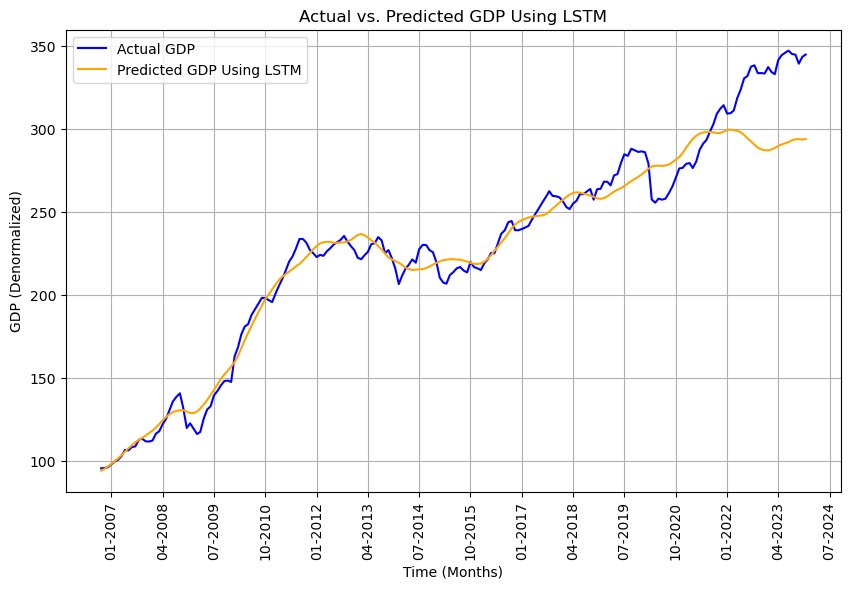

In [30]:
# Plot actual vs. predicted GDP
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['ID_GDP_USD'].values[n_prev_days:], label="Actual GDP", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_LSTM, label="Predicted GDP Using LSTM", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("Actual vs. Predicted GDP Using LSTM")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def GRU_process(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['ID_GDP_USD'].values
    features = data.drop(['ID_GDP_USD'], axis=1)
    #large_features = data[['M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD', 'ID_Import_USD', 'ID_Export_USD', 'ID_CE_USD', 'ID_GFCF_USD']].values

    #log_transformed_features = np.log1p(np.array(large_features, dtype=np.float64))
    #target = np.log1p(np.array(target, dtype=np.float64))
    #numeric_features = np.array(features.drop(['M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD', 'ID_Import_USD', 'ID_Export_USD', 'ID_CE_USD', 'ID_GFCF_USD'], axis=1).values, dtype=np.float64)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    #print(log_transformed_features.shape)
    print(target.shape)
    #scaled_features = np.concatenate((scaled_features, log_transformed_features), axis=1)  # Concatenate along the columns
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 10

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.001, l2=0.002)))
        model.add(MaxPooling1D(pool_size=2))        
        # First Bidirectional GRU Layer
        model.add(GRU(units= 60, recurrent_dropout=0.2,return_sequences = True))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(GRU(units = 48, recurrent_dropout=0.2, return_sequences = True))
        model.add(GRU(units = 16, recurrent_dropout=0.2))

        # Dense Layers for Prediction
        model.add(Dense(4, activation='linear'))
        model.add(Dense(1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('GDP_GRU_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=10000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['GRU', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)

   
    return model_performance

In [32]:
model_performance_GRU = GRU_process(data_with_bond, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_IDX',
       'Close_WTI', 'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
       'M2_JP_USD', 'M2_UK_USD', 'InflationYoY_ID', 'ID_Import_USD',
       'ID_Export_USD', 'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD',
       'Total_Bonds'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_BRNT           0
Close_IDX            0
Close_WTI            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
InflationYoY_ID      0
ID_Import_USD        0
ID_Export_USD        0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
dtype: int64
(216, 18)
(216, 1)
(216, 18)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3846 - mean_absolute_error: 0.1661 - val_loss: 0.2795 - val_mean_absolute_error: 0.0614 - learning_rate: 0.0010
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2720 - mean_absolute_error: 0.0539 - val_loss: 0.2931 - val_mean_absolute_error: 0.0756 - learning_rate: 0.0010
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3119 - mean_absolute_error: 0.0945 - val_loss: 0.2836 - val_mean_absolute_error: 0.0669 - learning_rate: 0.0010
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2925 - mean_absolute_error: 0.0758 - val_loss: 0.2824 - val_mean_absolute_error: 0.0665 - learning_rate: 0.0010
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2528 - mean_absolute_error: 0.0369 - val_loss: 0.3494 - val_mean_absolute_error: 0.1343 - learning_rate: 0.0010
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2982 - mean_absolute_error: 0.0831
Epoch 6: ReduceLROnPlateau red

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.3126 - mean_absolute_error: 0.0962 - val_loss: 0.4537 - val_mean_absolute_error: 0.2380 - learning_rate: 0.0010
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2685 - mean_absolute_error: 0.0530 - val_loss: 0.4968 - val_mean_absolute_error: 0.2826 - learning_rate: 0.0010
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2624 - mean_absolute_error: 0.0483 - val_loss: 0.4742 - val_mean_absolute_error: 0.2614 - learning_rate: 0.0010
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2519 - mean_absolute_error: 0.0393 - val_loss: 0.4050 - val_mean_absolute_error: 0.1935 - learning_rate: 0.0010
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2449 - mean_absolute_error: 0.0337 - val_loss: 0.3820 - val_mean_absolute_error: 0.1720 - learning_rate: 0.0010
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2390 - mean_absolute_error: 0.0292 - val_loss: 0.4181 - val_mean_ab

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 590ms/step - loss: 0.3872 - mean_absolute_error: 0.1709 - val_loss: 0.4986 - val_mean_absolute_error: 0.2835 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3033 - mean_absolute_error: 0.0885 - val_loss: 0.5141 - val_mean_absolute_error: 0.3013 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2849 - mean_absolute_error: 0.0723 - val_loss: 0.4606 - val_mean_absolute_error: 0.2500 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2631 - mean_absolute_error: 0.0528 - val_loss: 0.3543 - val_mean_absolute_error: 0.1459 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2704 - mean_absolute_error: 0.0623 - val_loss: 0.3357 - val_mean_absolute_error: 0.1297 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2583 - mean_absolute_error: 0.0527 - val_loss: 0.3815 - val_mean_a

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3102 - mean_absolute_error: 0.1425
3


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - loss: 0.4384 - mean_absolute_error: 0.2207 - val_loss: 0.3655 - val_mean_absolute_error: 0.1481 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3357 - mean_absolute_error: 0.1185 - val_loss: 0.2585 - val_mean_absolute_error: 0.0423 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3314 - mean_absolute_error: 0.1155 - val_loss: 0.2869 - val_mean_absolute_error: 0.0724 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2889 - mean_absolute_error: 0.0747 - val_loss: 0.3187 - val_mean_absolute_error: 0.1057 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2905 - mean_absolute_error: 0.0778 - val_loss: 0.2552 - val_mean_absolute_error: 0.0435 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2526 - mean_absolute_error: 0.0412 - val_loss: 0.3097 - val_mean_a

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1799 - mean_absolute_error: 0.0246 - val_loss: 0.1810 - val_mean_absolute_error: 0.0269 - learning_rate: 0.0010
Epoch 41/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1796 - mean_absolute_error: 0.0258 - val_loss: 0.1726 - val_mean_absolute_error: 0.0200 - learning_rate: 0.0010
Epoch 42/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1764 - mean_absolute_error: 0.0240 - val_loss: 0.1757 - val_mean_absolute_error: 0.0246 - learning_rate: 0.0010
Epoch 43/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1698 - mean_absolute_error: 0.0190 - val_loss: 0.1741 - val_mean_absolute_error: 0.0245 - learning_rate: 0.0010
Epoch 44/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1723 - mean_absolute_error: 0.0229 - val_loss: 0.1711 - val_mean_absolute_error: 0.0229 - learning_rate: 0.0010
Epoch 45/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1700 - mean_absolute_error: 0.0221 - val_loss: 0.1662 - val_mean_absolute_err

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1222 - mean_absolute_error: 0.0167 - val_loss: 0.1489 - val_mean_absolute_error: 0.0440 - learning_rate: 0.0010
Epoch 80/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1214 - mean_absolute_error: 0.0168 - val_loss: 0.1268 - val_mean_absolute_error: 0.0230 - learning_rate: 0.0010
Epoch 81/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1195 - mean_absolute_error: 0.0159 - val_loss: 0.1215 - val_mean_absolute_error: 0.0187 - learning_rate: 0.0010
Epoch 82/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1218 - mean_absolute_error: 0.0191 - val_loss: 0.1207 - val_mean_absolute_error: 0.0189 - learning_rate: 0.0010
Epoch 83/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1172 - mean_absolute_error: 0.0156 - val_loss: 0.1309 - val_mean_absolute_error: 0.0300 - learning_rate: 0.0010
Epoch 84/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1186 - mean_absolute_error: 0.0179 - val_loss: 0.1202 - val_mean_absolute_err

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0900 - mean_absolute_error: 0.0151 - val_loss: 0.0944 - val_mean_absolute_error: 0.0199 - learning_rate: 0.0010
Epoch 119/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0916 - mean_absolute_error: 0.0173 - val_loss: 0.0983 - val_mean_absolute_error: 0.0245 - learning_rate: 0.0010
Epoch 120/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0924 - mean_absolute_error: 0.0187 - val_loss: 0.0957 - val_mean_absolute_error: 0.0224 - learning_rate: 0.0010
Epoch 121/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0900 - mean_absolute_error: 0.0168 - val_loss: 0.0947 - val_mean_absolute_error: 0.0221 - learning_rate: 0.0010
Epoch 122/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0888 - mean_absolute_error: 0.0162 - val_loss: 0.0919 - val_mean_absolute_error: 0.0198 - learning_rate: 0.0010
Epoch 123/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0873 - mean_absolute_error: 0.0152 - val_loss: 0.0901 - val_mean_absolut

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0768 - mean_absolute_error: 0.0206
Epoch 157: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0746 - mean_absolute_error: 0.0185 - val_loss: 0.0847 - val_mean_absolute_error: 0.0290 - learning_rate: 0.0010
Epoch 158/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0769 - mean_absolute_error: 0.0212 - val_loss: 0.0810 - val_mean_absolute_error: 0.0254 - learning_rate: 1.0000e-04
Epoch 159/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0703 - mean_absolute_error: 0.0147 - val_loss: 0.0739 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 160/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0685 - mean_absolute_error: 0.0129 - val_loss: 0.0759 - val_mean_absolute_error: 0.0203 - learning_rate: 1.0000e-04
Epoch 161/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0711 - mean_absolute_error: 0.0155 - val_loss: 0.0778 - val_mean_absolute_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0655 - mean_absolute_error: 0.0114 - val_loss: 0.0724 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 195/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0646 - mean_absolute_error: 0.0105 - val_loss: 0.0723 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 196/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0670 - mean_absolute_error: 0.0130 - val_loss: 0.0723 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 197/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0666 - mean_absolute_error: 0.0126 - val_loss: 0.0722 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 198/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0660 - mean_absolute_error: 0.0120 - val_loss: 0.0724 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 199/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0667 - mean_absolute_error: 0.0128 - val_loss: 0.072

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0633 - mean_absolute_error: 0.0108 - val_loss: 0.0708 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 233/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0641 - mean_absolute_error: 0.0116 - val_loss: 0.0708 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 234/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0654 - mean_absolute_error: 0.0129 - val_loss: 0.0708 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 235/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0651 - mean_absolute_error: 0.0127 - val_loss: 0.0707 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 236/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0634 - mean_absolute_error: 0.0111 - val_loss: 0.0706 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 237/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0645 - mean_absolute_error: 0.0122 - val_loss: 0.070

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0639 - mean_absolute_error: 0.0130 - val_loss: 0.0691 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 271/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0627 - mean_absolute_error: 0.0119 - val_loss: 0.0690 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 272/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0624 - mean_absolute_error: 0.0116 - val_loss: 0.0690 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 273/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0634 - mean_absolute_error: 0.0126 - val_loss: 0.0689 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 274/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0640 - mean_absolute_error: 0.0133 - val_loss: 0.0689 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 275/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0623 - mean_absolute_error: 0.0116 - val_loss: 0.068

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0605 - mean_absolute_error: 0.0112 - val_loss: 0.0676 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 308/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0607 - mean_absolute_error: 0.0115 - val_loss: 0.0675 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 309/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0612 - mean_absolute_error: 0.0119 - val_loss: 0.0675 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 310/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0613 - mean_absolute_error: 0.0121 - val_loss: 0.0674 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 311/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0620 - mean_absolute_error: 0.0129 - val_loss: 0.0673 - val_mean_absolute_error: 0.0182 - learning_rate: 1.0000e-04
Epoch 312/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0616 - mean_absolute_error: 0.0125 - val_loss: 0.067

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0596 - mean_absolute_error: 0.0120 - val_loss: 0.0659 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 346/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0585 - mean_absolute_error: 0.0109 - val_loss: 0.0659 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 347/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0601 - mean_absolute_error: 0.0125 - val_loss: 0.0659 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 348/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0583 - mean_absolute_error: 0.0108 - val_loss: 0.0658 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 349/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0587 - mean_absolute_error: 0.0112 - val_loss: 0.0658 - val_mean_absolute_error: 0.0183 - learning_rate: 1.0000e-04
Epoch 350/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0582 - mean_absolute_error: 0.0108 - val_loss: 0.065

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0585 - mean_absolute_error: 0.0125 - val_loss: 0.0644 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 384/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0563 - mean_absolute_error: 0.0103 - val_loss: 0.0643 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 385/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0558 - mean_absolute_error: 0.0099 - val_loss: 0.0651 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 386/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0577 - mean_absolute_error: 0.0118 - val_loss: 0.0642 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 387/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0569 - mean_absolute_error: 0.0110 - val_loss: 0.0642 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 388/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0577 - mean_absolute_error: 0.0119 - val_loss: 0.064

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0573 - mean_absolute_error: 0.0128 - val_loss: 0.0627 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 422/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0566 - mean_absolute_error: 0.0122 - val_loss: 0.0627 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 423/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0564 - mean_absolute_error: 0.0120 - val_loss: 0.0627 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 424/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0564 - mean_absolute_error: 0.0121 - val_loss: 0.0633 - val_mean_absolute_error: 0.0190 - learning_rate: 1.0000e-04
Epoch 425/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0541 - mean_absolute_error: 0.0098 - val_loss: 0.0627 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 426/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0550 - mean_absolute_error: 0.0108 - val_loss: 0.062

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0550 - mean_absolute_error: 0.0121 - val_loss: 0.0612 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 460/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0551 - mean_absolute_error: 0.0123 - val_loss: 0.0612 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 461/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0543 - mean_absolute_error: 0.0115 - val_loss: 0.0612 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 462/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0524 - mean_absolute_error: 0.0096 - val_loss: 0.0612 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 463/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0535 - mean_absolute_error: 0.0108 - val_loss: 0.0612 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 464/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0544 - mean_absolute_error: 0.0117 - val_loss: 0.061

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0533 - mean_absolute_error: 0.0119 - val_loss: 0.0599 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 498/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0529 - mean_absolute_error: 0.0116 - val_loss: 0.0598 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 499/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0526 - mean_absolute_error: 0.0112 - val_loss: 0.0598 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 500/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0527 - mean_absolute_error: 0.0114 - val_loss: 0.0598 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 501/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0531 - mean_absolute_error: 0.0118 - val_loss: 0.0597 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 502/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0521 - mean_absolute_error: 0.0108 - val_loss: 0.059

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0505 - mean_absolute_error: 0.0105 - val_loss: 0.0585 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 536/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0502 - mean_absolute_error: 0.0103 - val_loss: 0.0586 - val_mean_absolute_error: 0.0187 - learning_rate: 1.0000e-04
Epoch 537/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0505 - mean_absolute_error: 0.0106 - val_loss: 0.0585 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 538/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0504 - mean_absolute_error: 0.0105 - val_loss: 0.0584 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 539/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0508 - mean_absolute_error: 0.0109 - val_loss: 0.0584 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 540/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0516 - mean_absolute_error: 0.0118 - val_loss: 0.058

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0494 - mean_absolute_error: 0.0107 - val_loss: 0.0571 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 574/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0502 - mean_absolute_error: 0.0116 - val_loss: 0.0571 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 575/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0493 - mean_absolute_error: 0.0108 - val_loss: 0.0571 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 576/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0489 - mean_absolute_error: 0.0104 - val_loss: 0.0570 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 577/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0500 - mean_absolute_error: 0.0115 - val_loss: 0.0570 - val_mean_absolute_error: 0.0185 - learning_rate: 1.0000e-04
Epoch 578/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0491 - mean_absolute_error: 0.0107 - val_loss: 0.057

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0484 - mean_absolute_error: 0.0110 - val_loss: 0.0559 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 612/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0484 - mean_absolute_error: 0.0111 - val_loss: 0.0559 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 613/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0481 - mean_absolute_error: 0.0108 - val_loss: 0.0559 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 614/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0469 - mean_absolute_error: 0.0096 - val_loss: 0.0558 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 615/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0493 - mean_absolute_error: 0.0120 - val_loss: 0.0558 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 616/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0490 - mean_absolute_error: 0.0119 - val_loss: 0.055

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0462 - mean_absolute_error: 0.0101 - val_loss: 0.0547 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 650/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0477 - mean_absolute_error: 0.0116 - val_loss: 0.0547 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 651/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0458 - mean_absolute_error: 0.0097 - val_loss: 0.0551 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 652/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0467 - mean_absolute_error: 0.0106 - val_loss: 0.0546 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 653/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0470 - mean_absolute_error: 0.0110 - val_loss: 0.0546 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 654/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0470 - mean_absolute_error: 0.0110 - val_loss: 0.054

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0456 - mean_absolute_error: 0.0106 - val_loss: 0.0535 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 688/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0465 - mean_absolute_error: 0.0116 - val_loss: 0.0534 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 689/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0460 - mean_absolute_error: 0.0111 - val_loss: 0.0534 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 690/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0464 - mean_absolute_error: 0.0115 - val_loss: 0.0534 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 691/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0461 - mean_absolute_error: 0.0113 - val_loss: 0.0533 - val_mean_absolute_error: 0.0186 - learning_rate: 1.0000e-04
Epoch 692/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0460 - mean_absolute_error: 0.0112 - val_loss: 0.053

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0444 - mean_absolute_error: 0.0106 - val_loss: 0.0525 - val_mean_absolute_error: 0.0187 - learning_rate: 1.0000e-04
Epoch 726/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0443 - mean_absolute_error: 0.0105 - val_loss: 0.0525 - val_mean_absolute_error: 0.0187 - learning_rate: 1.0000e-04
Epoch 727/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0444 - mean_absolute_error: 0.0106 - val_loss: 0.0532 - val_mean_absolute_error: 0.0195 - learning_rate: 1.0000e-04
Epoch 728/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0443 - mean_absolute_error: 0.0106 - val_loss: 0.0536 - val_mean_absolute_error: 0.0198 - learning_rate: 1.0000e-04
Epoch 729/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0434 - mean_absolute_error: 0.0097 - val_loss: 0.0524 - val_mean_absolute_error: 0.0187 - learning_rate: 1.0000e-04
Epoch 730/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0442 - mean_absolute_error: 0.0105 - val_loss: 0.052

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0428 - mean_absolute_error: 0.0100 - val_loss: 0.0516 - val_mean_absolute_error: 0.0188 - learning_rate: 1.0000e-04
Epoch 764/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0436 - mean_absolute_error: 0.0108 - val_loss: 0.0516 - val_mean_absolute_error: 0.0188 - learning_rate: 1.0000e-04
Epoch 765/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0431 - mean_absolute_error: 0.0103 - val_loss: 0.0520 - val_mean_absolute_error: 0.0192 - learning_rate: 1.0000e-04
Epoch 766/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0438 - mean_absolute_error: 0.0111 - val_loss: 0.0517 - val_mean_absolute_error: 0.0190 - learning_rate: 1.0000e-04
Epoch 767/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0440 - mean_absolute_error: 0.0113 - val_loss: 0.0515 - val_mean_absolute_error: 0.0188 - learning_rate: 1.0000e-04
Epoch 768/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0437 - mean_absolute_error: 0.0110 - val_loss: 0.051

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0438 - mean_absolute_error: 0.0119 - val_loss: 0.0568 - val_mean_absolute_error: 0.0250 - learning_rate: 1.0000e-04
Epoch 802/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0443 - mean_absolute_error: 0.0125 - val_loss: 0.0539 - val_mean_absolute_error: 0.0220 - learning_rate: 1.0000e-04
Epoch 803/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0427 - mean_absolute_error: 0.0109 - val_loss: 0.0507 - val_mean_absolute_error: 0.0189 - learning_rate: 1.0000e-04
Epoch 804/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0428 - mean_absolute_error: 0.0109 - val_loss: 0.0507 - val_mean_absolute_error: 0.0189 - learning_rate: 1.0000e-04
Epoch 805/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0417 - mean_absolute_error: 0.0099 - val_loss: 0.0507 - val_mean_absolute_error: 0.0189 - learning_rate: 1.0000e-04
Epoch 806/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0420 - mean_absolute_error: 0.0103 - val_loss: 0.050

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0410 - mean_absolute_error: 0.0100 - val_loss: 0.0510 - val_mean_absolute_error: 0.0201 - learning_rate: 1.0000e-04
Epoch 840/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0421 - mean_absolute_error: 0.0112 - val_loss: 0.0499 - val_mean_absolute_error: 0.0190 - learning_rate: 1.0000e-04
Epoch 841/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0420 - mean_absolute_error: 0.0111 - val_loss: 0.0499 - val_mean_absolute_error: 0.0190 - learning_rate: 1.0000e-04
Epoch 842/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0410 - mean_absolute_error: 0.0101 - val_loss: 0.0506 - val_mean_absolute_error: 0.0198 - learning_rate: 1.0000e-04
Epoch 843/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0410 - mean_absolute_error: 0.0102 - val_loss: 0.0499 - val_mean_absolute_error: 0.0190 - learning_rate: 1.0000e-04
Epoch 844/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0411 - mean_absolute_error: 0.0102 - val_loss: 0.049

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0416 - mean_absolute_error: 0.0114 - val_loss: 0.0509 - val_mean_absolute_error: 0.0207 - learning_rate: 1.0000e-04
Epoch 878/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0402 - mean_absolute_error: 0.0101 - val_loss: 0.0493 - val_mean_absolute_error: 0.0192 - learning_rate: 1.0000e-04
Epoch 879/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0403 - mean_absolute_error: 0.0103 - val_loss: 0.0492 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 880/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0410 - mean_absolute_error: 0.0109 - val_loss: 0.0491 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 881/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0395 - mean_absolute_error: 0.0095 - val_loss: 0.0491 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 882/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0389 - mean_absolute_error: 0.0089 - val_loss: 0.049

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0391 - mean_absolute_error: 0.0098 - val_loss: 0.0484 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 916/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0393 - mean_absolute_error: 0.0100 - val_loss: 0.0484 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 917/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0397 - mean_absolute_error: 0.0104 - val_loss: 0.0483 - val_mean_absolute_error: 0.0191 - learning_rate: 1.0000e-04
Epoch 918/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0397 - mean_absolute_error: 0.0104 - val_loss: 0.0486 - val_mean_absolute_error: 0.0194 - learning_rate: 1.0000e-04
Epoch 919/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0390 - mean_absolute_error: 0.0098 - val_loss: 0.0496 - val_mean_absolute_error: 0.0204 - learning_rate: 1.0000e-04
Epoch 920/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0401 - mean_absolute_error: 0.0109 - val_loss: 0.049

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - loss: 0.5089 - mean_absolute_error: 0.2905 - val_loss: 0.3584 - val_mean_absolute_error: 0.1412 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3313 - mean_absolute_error: 0.1145 - val_loss: 0.2331 - val_mean_absolute_error: 0.0184 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3029 - mean_absolute_error: 0.0888 - val_loss: 0.3492 - val_mean_absolute_error: 0.1373 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2798 - mean_absolute_error: 0.0684 - val_loss: 0.3015 - val_mean_absolute_error: 0.0922 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2612 - mean_absolute_error: 0.0524 - val_loss: 0.2419 - val_mean_absolute_error: 0.0352 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2725 - mean_absolute_error: 0.0662 - val_loss: 0.3028 - val_mean_a

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - loss: 0.4568 - mean_absolute_error: 0.2375 - val_loss: 0.3291 - val_mean_absolute_error: 0.1108 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3670 - mean_absolute_error: 0.1491 - val_loss: 0.3227 - val_mean_absolute_error: 0.1062 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2876 - mean_absolute_error: 0.0715 - val_loss: 0.3573 - val_mean_absolute_error: 0.1426 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2896 - mean_absolute_error: 0.0753 - val_loss: 0.2426 - val_mean_absolute_error: 0.0297 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2791 - mean_absolute_error: 0.0666 - val_loss: 0.2545 - val_mean_absolute_error: 0.0436 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2574 - mean_absolute_error: 0.0470 - val_loss: 0.3263 - val_mean_a

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - loss: 0.5413 - mean_absolute_error: 0.3237 - val_loss: 0.4172 - val_mean_absolute_error: 0.2009 - learning_rate: 0.0010
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3338 - mean_absolute_error: 0.1180 - val_loss: 0.4213 - val_mean_absolute_error: 0.2077 - learning_rate: 0.0010
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3049 - mean_absolute_error: 0.0920 - val_loss: 0.4252 - val_mean_absolute_error: 0.2145 - learning_rate: 0.0010
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2841 - mean_absolute_error: 0.0740 - val_loss: 0.3717 - val_mean_absolute_error: 0.1638 - learning_rate: 0.0010
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2604 - mean_absolute_error: 0.0531 - val_loss: 0.3790 - val_mean_absolute_error: 0.1739 - learning_rate: 0.0010
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2489 - mean_absolute_error: 0.0444 - val_loss: 0.3094 - val_mean_a

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1423 - mean_absolute_error: 0.0240
Epoch 40: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1468 - mean_absolute_error: 0.0289 - val_loss: 0.1683 - val_mean_absolute_error: 0.0518 - learning_rate: 0.0010
Epoch 41/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1426 - mean_absolute_error: 0.0262 - val_loss: 0.1655 - val_mean_absolute_error: 0.0492 - learning_rate: 1.0000e-04
Epoch 42/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1407 - mean_absolute_error: 0.0245 - val_loss: 0.1650 - val_mean_absolute_error: 0.0489 - learning_rate: 1.0000e-04
Epoch 43/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1389 - mean_absolute_error: 0.0229 - val_loss: 0.1688 - val_mean_absolute_error: 0.0529 - learning_rate: 1.0000e-04
Epoch 44/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1393 - mean_absolute_error: 0.0235 - val_loss: 0.1749 - val_mean_absolute_error

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_22 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.5902 - mean_absolute_error: 0.3717 - val_loss: 0.2709 - val_mean_absolute_error: 0.0535 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3313 - mean_absolute_error: 0.1142 - val_loss: 0.4403 - val_mean_absolute_error: 0.2247 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3044 - mean_absolute_error: 0.0891 - val_loss: 0.2500 - val_mean_absolute_error: 0.0359 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2816 - mean_absolute_error: 0.0678 - val_loss: 0.3569 - val_mean_absolute_error: 0.1444 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2784 - mean_absolute_error: 0.0663 - val_loss: 0.2453 - val_mean_absolute_error: 0.0344 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2673 - mean_absolute_error: 0.0567 - val_loss: 0.3432 - val_mean_a

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1960 - mean_absolute_error: 0.0361 - val_loss: 0.2168 - val_mean_absolute_error: 0.0580 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1905 - mean_absolute_error: 0.0320 - val_loss: 0.1862 - val_mean_absolute_error: 0.0288 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1880 - mean_absolute_error: 0.0309 - val_loss: 0.2237 - val_mean_absolute_error: 0.0677 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1871 - mean_absolute_error: 0.0314 - val_loss: 0.1806 - val_mean_absolute_error: 0.0259 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1947 - mean_absolute_error: 0.0403 - val_loss: 0.2372 - val_mean_absolute_error: 0.0838 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2048 - mean_absolute_error: 0.0517 - val_loss: 0.1786 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1433 - mean_absolute_error: 0.0311 - val_loss: 0.1532 - val_mean_absolute_error: 0.0420 - learning_rate: 0.0010
Epoch 80/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1445 - mean_absolute_error: 0.0335 - val_loss: 0.1413 - val_mean_absolute_error: 0.0311 - learning_rate: 0.0010
Epoch 81/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1427 - mean_absolute_error: 0.0326 - val_loss: 0.1368 - val_mean_absolute_error: 0.0275 - learning_rate: 0.0010
Epoch 82/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1445 - mean_absolute_error: 0.0356 - val_loss: 0.1587 - val_mean_absolute_error: 0.0506 - learning_rate: 0.0010
Epoch 83/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1362 - mean_absolute_error: 0.0282 - val_loss: 0.1405 - val_mean_absolute_error: 0.0333 - learning_rate: 0.0010
Epoch 84/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1332 - mean_absolute_error: 0.0263 - val_loss: 0.1370 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1090 - mean_absolute_error: 0.0325 - val_loss: 0.1062 - val_mean_absolute_error: 0.0303 - learning_rate: 0.0010
Epoch 119/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1101 - mean_absolute_error: 0.0343 - val_loss: 0.1513 - val_mean_absolute_error: 0.0763 - learning_rate: 0.0010
Epoch 120/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1173 - mean_absolute_error: 0.0424 - val_loss: 0.1419 - val_mean_absolute_error: 0.0675 - learning_rate: 0.0010
Epoch 121/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1058 - mean_absolute_error: 0.0316 - val_loss: 0.0981 - val_mean_absolute_error: 0.0243 - learning_rate: 0.0010
Epoch 122/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1044 - mean_absolute_error: 0.0309 - val_loss: 0.1418 - val_mean_absolute_error: 0.0689 - learning_rate: 0.0010
Epoch 123/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1014 - mean_absolute_error: 0.0286 - val_loss: 0.0984 - val_mean_absolut

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - loss: 0.5040 - mean_absolute_error: 0.2889 - val_loss: 0.2237 - val_mean_absolute_error: 0.0097 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3217 - mean_absolute_error: 0.1083 - val_loss: 0.3543 - val_mean_absolute_error: 0.1425 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2929 - mean_absolute_error: 0.0815 - val_loss: 0.3099 - val_mean_absolute_error: 0.0999 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2750 - mean_absolute_error: 0.0655 - val_loss: 0.2408 - val_mean_absolute_error: 0.0329 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2553 - mean_absolute_error: 0.0479 - val_loss: 0.2367 - val_mean_absolute_error: 0.0309 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2534 - mean_absolute_error: 0.0481 - val_loss: 0.2196 - val_mean_a

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1747 - mean_absolute_error: 0.0244 - val_loss: 0.1676 - val_mean_absolute_error: 0.0175 - learning_rate: 1.0000e-04
Epoch 40/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1766 - mean_absolute_error: 0.0265 - val_loss: 0.1659 - val_mean_absolute_error: 0.0160 - learning_rate: 1.0000e-04
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1770 - mean_absolute_error: 0.0271 - val_loss: 0.1665 - val_mean_absolute_error: 0.0168 - learning_rate: 1.0000e-04
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1771 - mean_absolute_error: 0.0274 - val_loss: 0.1650 - val_mean_absolute_error: 0.0155 - learning_rate: 1.0000e-04
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1739 - mean_absolute_error: 0.0244 - val_loss: 0.1670 - val_mean_absolute_error: 0.0177 - learning_rate: 1.0000e-04
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1741 - mean_absolute_error: 0.0249 - val_loss: 0.1754 - v

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_27 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 0.3760 - mean_absolute_error: 0.1583 - val_loss: 0.3012 - val_mean_absolute_error: 0.0853 - learning_rate: 0.0010
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2967 - mean_absolute_error: 0.0814 - val_loss: 0.2936 - val_mean_absolute_error: 0.0800 - learning_rate: 0.0010
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2827 - mean_absolute_error: 0.0695 - val_loss: 0.3892 - val_mean_absolute_error: 0.1777 - learning_rate: 0.0010
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2873 - mean_absolute_error: 0.0762 - val_loss: 0.2798 - val_mean_absolute_error: 0.0703 - learning_rate: 0.0010
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2602 - mean_absolute_error: 0.0512 - val_loss: 0.2413 - val_mean_absolute_error: 0.0340 - learning_rate: 0.0010
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2656 - mean_absolute_error: 0.0589 - val_loss: 0.2755 - val_mean_a

In [33]:
#GRU
top_models_GRU = sorted(model_performance_GRU, key=lambda x: x[3])[:3]
print("Len Sequences: ", len(input_sequences_DL))
top_model_ids_GRU = [model[1] for model in top_models_GRU]
List_of_Top_Models.append(top_models_GRU)
predicted_values_GRU = []
for id in top_model_ids_GRU:
    model_GRU = load_model('GDP_GRU_'+str(id)+'.keras')
    predicted_value_GRU = model_GRU.predict(input_sequences_DL)
    predicted_value_GRU = target_scaler.inverse_transform(predicted_value_GRU)
    predicted_values_GRU.append(predicted_value_GRU)

predicted_values_GRU = np.array(predicted_values_GRU)

final_predicted_values_GRU = np.median(predicted_values_GRU, axis=0)
rmse_GRU = np.sqrt(np.mean(((final_predicted_values_GRU[-60:] - data_DL['ID_GDP_USD'][-60:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_GRU)
print("Length Prediction:", len(final_predicted_values_GRU))
print("Length Actual:", len(data_DL['ID_GDP_USD'].values))

Len Sequences:  207
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
RMSE on Last 10 Year Data: 35.59451023118407
Length Prediction: 207
Length Actual: 216


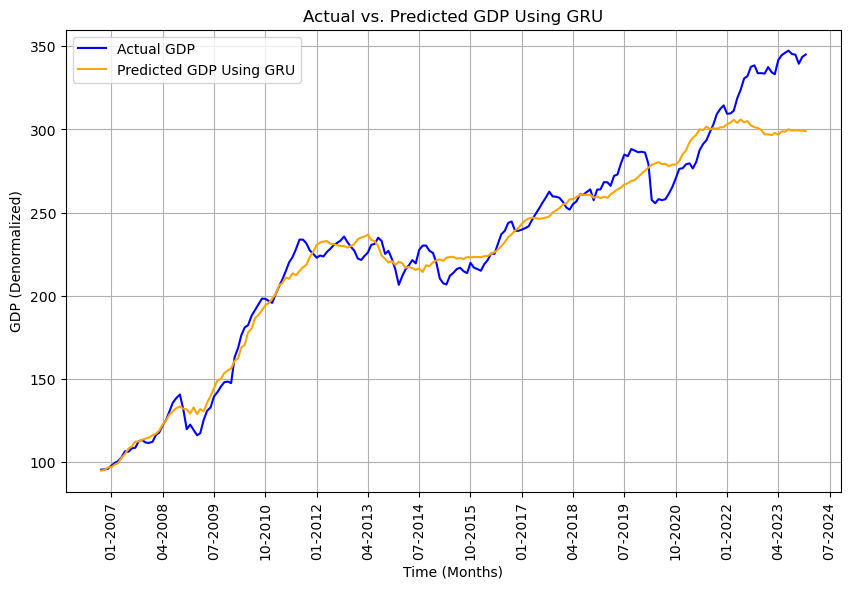

In [34]:
# Plot actual vs. predicted GDP
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['ID_GDP_USD'].values[n_prev_days:], label="Actual GDP", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_GRU, label="Predicted GDP Using GRU", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("Actual vs. Predicted GDP Using GRU")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
def CNNLSTM_process(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['ID_GDP_USD'].values
    features = data.drop(['ID_GDP_USD'], axis=1)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    #print(log_transformed_features.shape)
    print(target.shape)
    #scaled_features = np.concatenate((scaled_features, log_transformed_features), axis=1)  # Concatenate along the columns
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 10

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        # Adding the 1D Convolutional layer
        model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
        model.add(MaxPooling1D(pool_size=2))

       # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units= 64, recurrent_dropout=0.2, return_sequences = True))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 32, return_sequences = True, recurrent_dropout=0.2))
        model.add(LSTM(units = 16, recurrent_dropout=0.2))
        model.add(Dense(units=4, activation='linear'))
        model.add(Dense(units=1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('GDP_CNN_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=1000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['CNNLSTM', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)
    return model_performance

In [36]:
model_performance_CNNLSTM = CNNLSTM_process(data_with_bond, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_IDX',
       'Close_WTI', 'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
       'M2_JP_USD', 'M2_UK_USD', 'InflationYoY_ID', 'ID_Import_USD',
       'ID_Export_USD', 'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD',
       'Total_Bonds'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_BRNT           0
Close_IDX            0
Close_WTI            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
InflationYoY_ID      0
ID_Import_USD        0
ID_Export_USD        0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
dtype: int64
(216, 18)
(216, 1)
(216, 18)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3122 - mean_absolute_error: 0.1166 - val_loss: 0.3617 - val_mean_absolute_error: 0.1672 - learning_rate: 0.0010
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2855 - mean_absolute_error: 0.0910 - val_loss: 0.3316 - val_mean_absolute_error: 0.1381 - learning_rate: 0.0010
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2593 - mean_absolute_error: 0.0658 - val_loss: 0.3004 - val_mean_absolute_error: 0.1080 - learning_rate: 0.0010
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2371 - mean_absolute_error: 0.0447 - val_loss: 0.2685 - val_mean_absolute_error: 0.0772 - learning_rate: 0.0010
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2241 - mean_absolute_error: 0.0327 - val_loss: 0.2435 - val_mean_absolute_error: 0.0533 - learning_rate: 0.0010
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2247 - mean_absolute_error: 0.0345 - val_loss: 0.2369 - val_mean_absolu

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.3238 - mean_absolute_error: 0.1302 - val_loss: 0.4990 - val_mean_absolute_error: 0.3072 - learning_rate: 0.0010
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2722 - mean_absolute_error: 0.0807 - val_loss: 0.4384 - val_mean_absolute_error: 0.2486 - learning_rate: 0.0010
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2352 - mean_absolute_error: 0.0456 - val_loss: 0.3837 - val_mean_absolute_error: 0.1961 - learning_rate: 0.0010
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2318 - mean_absolute_error: 0.0444 - val_loss: 0.3595 - val_mean_absolute_error: 0.1744 - learning_rate: 0.0010
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2333 - mean_absolute_error: 0.0485 - val_loss: 0.3662 - val_mean_absolute_error: 0.1837 - learning_rate: 0.0010
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2233 - mean_absolute_error: 0.0411 - val_loss: 0.3852 - val_mean_absolute

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - loss: 0.4011 - mean_absolute_error: 0.2079 - val_loss: 0.6545 - val_mean_absolute_error: 0.4645 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3488 - mean_absolute_error: 0.1593 - val_loss: 0.5879 - val_mean_absolute_error: 0.4015 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2973 - mean_absolute_error: 0.1113 - val_loss: 0.5026 - val_mean_absolute_error: 0.3194 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2715 - mean_absolute_error: 0.0888 - val_loss: 0.4231 - val_mean_absolute_error: 0.2436 - learning_rate: 0.0010
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2698 - mean_absolute_error: 0.0908 - val_loss: 0.4080 - val_mean_absolute_error: 0.2323 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2596 - mean_absolute_error: 0.0845 - val_loss: 0.4380 - val_mean_absolut

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1048 - mean_absolute_error: 0.0139 - val_loss: 0.1140 - val_mean_absolute_error: 0.0245 - learning_rate: 0.0010
Epoch 41/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1021 - mean_absolute_error: 0.0128 - val_loss: 0.1109 - val_mean_absolute_error: 0.0230 - learning_rate: 0.0010
Epoch 42/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1028 - mean_absolute_error: 0.0151 - val_loss: 0.1156 - val_mean_absolute_error: 0.0292 - learning_rate: 0.0010
Epoch 43/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0991 - mean_absolute_error: 0.0129 - val_loss: 0.1117 - val_mean_absolute_error: 0.0268 - learning_rate: 0.0010
Epoch 44/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0963 - mean_absolute_error: 0.0117 - val_loss: 0.1076 - val_mean_absolute_error: 0.0241 - learning_rate: 0.0010
Epoch 45/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0952 - mean_absolute_error: 0.0120 - val_loss: 0.1047 - val_mean_absolute_error: 0

Epoch 78/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0683 - mean_absolute_error: 0.0115 - val_loss: 0.0854 - val_mean_absolute_error: 0.0287 - learning_rate: 1.0000e-04
Epoch 79/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0701 - mean_absolute_error: 0.0134 - val_loss: 0.0895 - val_mean_absolute_error: 0.0328 - learning_rate: 1.0000e-04
Epoch 80/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0709 - mean_absolute_error: 0.0143 - val_loss: 0.0821 - val_mean_absolute_error: 0.0255 - learning_rate: 1.0000e-04
Epoch 81/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0685 - mean_absolute_error: 0.0120 - val_loss: 0.0819 - val_mean_absolute_error: 0.0254 - learning_rate: 1.0000e-04
Epoch 82/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0688 - mean_absolute_error: 0.0123 - val_loss: 0.0846 - val_mean_absolute_error: 0.0282 - learning_rate: 1.0000e-04
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 72.
2/2 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - loss: 0.4403 - mean_absolute_error: 0.2460 - val_loss: 0.6342 - val_mean_absolute_error: 0.4418 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3658 - mean_absolute_error: 0.1737 - val_loss: 0.5217 - val_mean_absolute_error: 0.3313 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3188 - mean_absolute_error: 0.1289 - val_loss: 0.4017 - val_mean_absolute_error: 0.2137 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3035 - mean_absolute_error: 0.1161 - val_loss: 0.3004 - val_mean_absolute_error: 0.1152 - learning_rate: 0.0010
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2961 - mean_absolute_error: 0.1114 - val_loss: 0.2363 - val_mean_absolute_error: 0.0538 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2797 - mean_absolute_error: 0.0977 - val_loss: 0.2127 - val_mean_absolute

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - loss: 0.4867 - mean_absolute_error: 0.2918 - val_loss: 0.5903 - val_mean_absolute_error: 0.3979 - learning_rate: 0.0010
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3997 - mean_absolute_error: 0.2078 - val_loss: 0.4323 - val_mean_absolute_error: 0.2427 - learning_rate: 0.0010
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3354 - mean_absolute_error: 0.1464 - val_loss: 0.2409 - val_mean_absolute_error: 0.0544 - learning_rate: 0.0010
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2957 - mean_absolute_error: 0.1100 - val_loss: 0.2058 - val_mean_absolute_error: 0.0230 - learning_rate: 0.0010
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2731 - mean_absolute_error: 0.0912 - val_loss: 0.2629 - val_mean_absolute_error: 0.0840 - learning_rate: 0.0010
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2616 - mean_absolute_error: 0.0833 - val_loss: 0.2418 - val_mean_absolute

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - loss: 0.5518 - mean_absolute_error: 0.3560 - val_loss: 0.6080 - val_mean_absolute_error: 0.4147 - learning_rate: 0.0010
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.4474 - mean_absolute_error: 0.2547 - val_loss: 0.4587 - val_mean_absolute_error: 0.2680 - learning_rate: 0.0010
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3493 - mean_absolute_error: 0.1591 - val_loss: 0.2624 - val_mean_absolute_error: 0.0742 - learning_rate: 0.0010
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2866 - mean_absolute_error: 0.0990 - val_loss: 0.2356 - val_mean_absolute_error: 0.0504 - learning_rate: 0.0010
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2752 - mean_absolute_error: 0.0907 - val_loss: 0.2343 - val_mean_absolute_error: 0.0523 - learning_rate: 0.0010
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2581 - mean_absolute_error: 0.0768 - val_loss: 0.2683 - val_mean_absolute

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1199 - mean_absolute_error: 0.0160 - val_loss: 0.1353 - val_mean_absolute_error: 0.0329 - learning_rate: 0.0010
Epoch 41/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1176 - mean_absolute_error: 0.0155 - val_loss: 0.1333 - val_mean_absolute_error: 0.0327 - learning_rate: 0.0010
Epoch 42/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1163 - mean_absolute_error: 0.0161 - val_loss: 0.1346 - val_mean_absolute_error: 0.0357 - learning_rate: 0.0010
Epoch 43/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1148 - mean_absolute_error: 0.0163 - val_loss: 0.1275 - val_mean_absolute_error: 0.0303 - learning_rate: 0.0010
Epoch 44/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1126 - mean_absolute_error: 0.0158 - val_loss: 0.1288 - val_mean_absolute_error: 0.0334 - learning_rate: 0.0010
Epoch 45/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1096 - mean_absolute_error: 0.0146 - val_loss: 0.1258 - val_mean_absolute_error: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0667 - mean_absolute_error: 0.0138 - val_loss: 0.0855 - val_mean_absolute_error: 0.0333 - learning_rate: 0.0010
Epoch 80/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0667 - mean_absolute_error: 0.0146 - val_loss: 0.0836 - val_mean_absolute_error: 0.0323 - learning_rate: 0.0010
Epoch 81/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0652 - mean_absolute_error: 0.0140 - val_loss: 0.0801 - val_mean_absolute_error: 0.0295 - learning_rate: 0.0010
Epoch 82/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0642 - mean_absolute_error: 0.0138 - val_loss: 0.0876 - val_mean_absolute_error: 0.0378 - learning_rate: 0.0010
Epoch 83/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0670 - mean_absolute_error: 0.0173 - val_loss: 0.0812 - val_mean_absolute_error: 0.0321 - learning_rate: 0.0010
Epoch 84/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0633 - mean_absolute_error: 0.0145 - val_loss: 0.0777 - val_mean_absolute_error: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0479 - mean_absolute_error: 0.0124 - val_loss: 0.0679 - val_mean_absolute_error: 0.0324 - learning_rate: 1.0000e-04
Epoch 117/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0475 - mean_absolute_error: 0.0121 - val_loss: 0.0686 - val_mean_absolute_error: 0.0332 - learning_rate: 1.0000e-04
Epoch 118/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0476 - mean_absolute_error: 0.0122 - val_loss: 0.0681 - val_mean_absolute_error: 0.0328 - learning_rate: 1.0000e-04
Epoch 118: early stopping
Restoring model weights from the end of the best epoch: 108.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.3604 - mean_absolute_error: 0.3245  
6


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - loss: 0.5241 - mean_absolute_error: 0.3302 - val_loss: 0.6265 - val_mean_absolute_error: 0.4359 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4059 - mean_absolute_error: 0.2161 - val_loss: 0.4628 - val_mean_absolute_error: 0.2755 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3019 - mean_absolute_error: 0.1154 - val_loss: 0.2779 - val_mean_absolute_error: 0.0941 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2984 - mean_absolute_error: 0.1155 - val_loss: 0.3729 - val_mean_absolute_error: 0.1931 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2757 - mean_absolute_error: 0.0967 - val_loss: 0.3756 - val_mean_absolute_error: 0.1993 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2512 - mean_absolute_error: 0.0757 - val_loss: 0.2976 - val_mean_absolute

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.5832 - mean_absolute_error: 0.3884 - val_loss: 0.6417 - val_mean_absolute_error: 0.4492 - learning_rate: 0.0010
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3893 - mean_absolute_error: 0.1973 - val_loss: 0.3589 - val_mean_absolute_error: 0.1691 - learning_rate: 0.0010
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2821 - mean_absolute_error: 0.0931 - val_loss: 0.3844 - val_mean_absolute_error: 0.1987 - learning_rate: 0.0010
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2690 - mean_absolute_error: 0.0841 - val_loss: 0.3448 - val_mean_absolute_error: 0.1627 - learning_rate: 0.0010
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2550 - mean_absolute_error: 0.0737 - val_loss: 0.3093 - val_mean_absolute_error: 0.1306 - learning_rate: 0.0010
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2453 - mean_absolute_error: 0.0673 - val_loss: 0.2843 - val_mean_absolute

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1346 - mean_absolute_error: 0.0235 - val_loss: 0.1389 - val_mean_absolute_error: 0.0290 - learning_rate: 0.0010
Epoch 41/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1341 - mean_absolute_error: 0.0245 - val_loss: 0.1417 - val_mean_absolute_error: 0.0332 - learning_rate: 0.0010
Epoch 42/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1305 - mean_absolute_error: 0.0222 - val_loss: 0.1373 - val_mean_absolute_error: 0.0302 - learning_rate: 0.0010
Epoch 43/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1314 - mean_absolute_error: 0.0246 - val_loss: 0.1398 - val_mean_absolute_error: 0.0341 - learning_rate: 0.0010
Epoch 44/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1274 - mean_absolute_error: 0.0219 - val_loss: 0.1357 - val_mean_absolute_error: 0.0314 - learning_rate: 0.0010
Epoch 45/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1283 - mean_absolute_error: 0.0243 - val_loss: 0.1336 - val_mean_absolute_error: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0925 - mean_absolute_error: 0.0236 - val_loss: 0.1087 - val_mean_absolute_error: 0.0405 - learning_rate: 0.0010
Epoch 80/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0893 - mean_absolute_error: 0.0213 - val_loss: 0.0985 - val_mean_absolute_error: 0.0311 - learning_rate: 0.0010
Epoch 81/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0906 - mean_absolute_error: 0.0233 - val_loss: 0.1082 - val_mean_absolute_error: 0.0416 - learning_rate: 0.0010
Epoch 82/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0878 - mean_absolute_error: 0.0212 - val_loss: 0.0987 - val_mean_absolute_error: 0.0328 - learning_rate: 0.0010
Epoch 83/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0888 - mean_absolute_error: 0.0231 - val_loss: 0.0983 - val_mean_absolute_error: 0.0332 - learning_rate: 0.0010
Epoch 84/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0892 - mean_absolute_error: 0.0241 - val_loss: 0.0985 - val_mean_absolute_error: 0

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 0.5672 - mean_absolute_error: 0.3757 - val_loss: 0.6664 - val_mean_absolute_error: 0.4784 - learning_rate: 0.0010
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4080 - mean_absolute_error: 0.2207 - val_loss: 0.3349 - val_mean_absolute_error: 0.1498 - learning_rate: 0.0010
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3208 - mean_absolute_error: 0.1366 - val_loss: 0.3265 - val_mean_absolute_error: 0.1463 - learning_rate: 0.0010
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2853 - mean_absolute_error: 0.1063 - val_loss: 0.3824 - val_mean_absolute_error: 0.2073 - learning_rate: 0.0010
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2810 - mean_absolute_error: 0.1068 - val_loss: 0.2666 - val_mean_absolute_error: 0.0955 - learning_rate: 0.0010
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2546 - mean_absolute_error: 0.0845 - val_loss: 0.2792 - val_mean_absolute

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1017 - mean_absolute_error: 0.0232 - val_loss: 0.0907 - val_mean_absolute_error: 0.0133 - learning_rate: 0.0010
Epoch 41/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0984 - mean_absolute_error: 0.0214 - val_loss: 0.0940 - val_mean_absolute_error: 0.0182 - learning_rate: 0.0010
Epoch 42/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1002 - mean_absolute_error: 0.0247 - val_loss: 0.0908 - val_mean_absolute_error: 0.0165 - learning_rate: 0.0010
Epoch 43/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0967 - mean_absolute_error: 0.0227 - val_loss: 0.0886 - val_mean_absolute_error: 0.0157 - learning_rate: 0.0010
Epoch 44/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0956 - mean_absolute_error: 0.0230 - val_loss: 0.0892 - val_mean_absolute_error: 0.0177 - learning_rate: 0.0010
Epoch 45/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0944 - mean_absolute_error: 0.0232 - val_loss: 0.0852 - val_mean_absolute_error: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0638 - mean_absolute_error: 0.0209 - val_loss: 0.0581 - val_mean_absolute_error: 0.0156 - learning_rate: 0.0010
Epoch 80/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0652 - mean_absolute_error: 0.0228 - val_loss: 0.0571 - val_mean_absolute_error: 0.0150 - learning_rate: 0.0010
Epoch 81/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0649 - mean_absolute_error: 0.0229 - val_loss: 0.0558 - val_mean_absolute_error: 0.0143 - learning_rate: 0.0010
Epoch 82/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0615 - mean_absolute_error: 0.0200 - val_loss: 0.0565 - val_mean_absolute_error: 0.0153 - learning_rate: 0.0010
Epoch 83/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0627 - mean_absolute_error: 0.0216 - val_loss: 0.0548 - val_mean_absolute_error: 0.0141 - learning_rate: 0.0010
Epoch 84/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0624 - mean_absolute_error: 0.0217 - val_loss: 0.0566 - val_mean_absolute_error: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0490 - mean_absolute_error: 0.0192 - val_loss: 0.0594 - val_mean_absolute_error: 0.0298 - learning_rate: 0.0010
Epoch 119/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0476 - mean_absolute_error: 0.0180 - val_loss: 0.0442 - val_mean_absolute_error: 0.0148 - learning_rate: 0.0010
Epoch 120/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0536 - mean_absolute_error: 0.0242 - val_loss: 0.0469 - val_mean_absolute_error: 0.0177 - learning_rate: 0.0010
Epoch 121/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0522 - mean_absolute_error: 0.0231 - val_loss: 0.0461 - val_mean_absolute_error: 0.0172 - learning_rate: 0.0010
Epoch 122/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0474 - mean_absolute_error: 0.0186 - val_loss: 0.0504 - val_mean_absolute_error: 0.0217 - learning_rate: 0.0010
Epoch 123/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0488 - mean_absolute_error: 0.0201 - val_loss: 0.0434 - val_mean_absolute_err

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 7, 32)          │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,217 (164.91 KB)

 Trainable params: 42,217 (164.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 0.5623 - mean_absolute_error: 0.3677 - val_loss: 0.5688 - val_mean_absolute_error: 0.3763 - learning_rate: 0.0010
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3485 - mean_absolute_error: 0.1566 - val_loss: 0.3069 - val_mean_absolute_error: 0.1177 - learning_rate: 0.0010
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3095 - mean_absolute_error: 0.1211 - val_loss: 0.3878 - val_mean_absolute_error: 0.2019 - learning_rate: 0.0010
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2690 - mean_absolute_error: 0.0837 - val_loss: 0.2264 - val_mean_absolute_error: 0.0433 - learning_rate: 0.0010
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2187 - mean_absolute_error: 0.0362 - val_loss: 0.2134 - val_mean_absolute_error: 0.0331 - learning_rate: 0.0010
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2181 - mean_absolute_error: 0.0385 - val_loss: 0.2516 - val_mean_absolute

In [37]:
#CNNLSTM
top_models_CNNLSTM = sorted(model_performance_CNNLSTM, key=lambda x: x[3])[:3]
print("Len Sequences: ", (input_sequences_DL.shape))
top_model_ids_CNN = [model[1] for model in top_models_CNNLSTM]
List_of_Top_Models.append(top_models_CNNLSTM)
predicted_values_CNN = []
for id in top_model_ids_CNN:
    model_CNN = load_model('GDP_CNN_'+str(id)+'.keras')
    predicted_value_CNN = model_CNN.predict(input_sequences_DL)
    predicted_value_CNN = target_scaler.inverse_transform(predicted_value_CNN)
    predicted_values_CNN.append(predicted_value_CNN)

predicted_values_CNN = np.array(predicted_values_CNN)

final_predicted_values_CNN = np.median(predicted_values_CNN, axis=0)
rmse_CNN = np.sqrt(np.mean(((final_predicted_values_CNN[-60:] - data_DL['ID_GDP_USD'][-60:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_CNN)
print("Length Prediction:", len(final_predicted_values_CNN))
print("Length Actual:", len(data_DL['ID_GDP_USD'].values))

Len Sequences:  (207, 9, 18)
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
RMSE on Last 10 Year Data: 37.4732891390247
Length Prediction: 207
Length Actual: 216


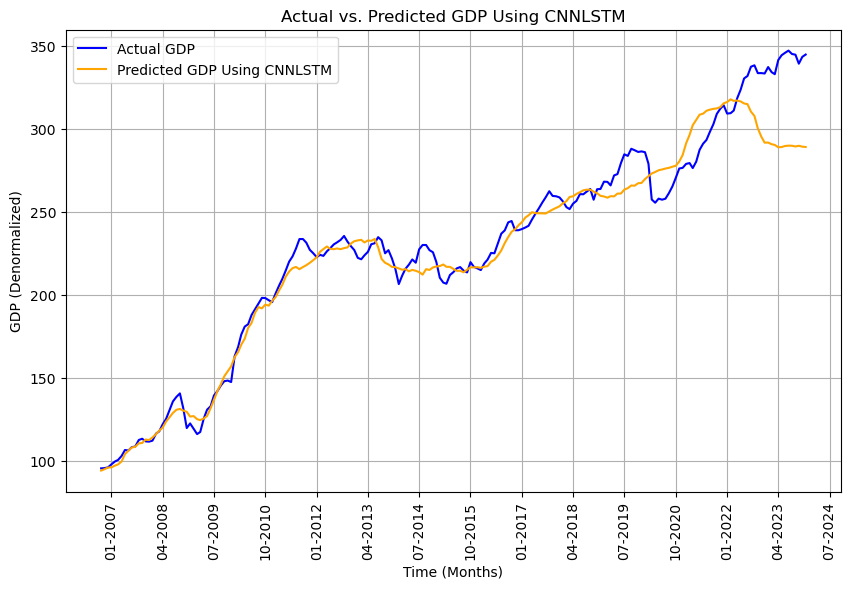

In [38]:
# Plot actual vs. predicted GDP
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['ID_GDP_USD'].values[n_prev_days:], label="Actual GDP", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_CNN, label="Predicted GDP Using CNNLSTM", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("Actual vs. Predicted GDP Using CNNLSTM")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
columns_names_model = ['Model', 'Id', 'Loss', 'MSE']
List_of_Top_Model = [item for sublist in List_of_Top_Models for item in sublist]
top_models_df = pd.DataFrame(List_of_Top_Model, columns=columns_names_model)
top_models_df.to_csv('Model_Performance.csv', index=True)
top_models_df

Model  Id      Loss       MSE
0     LSTM  13  0.148032  0.096608
1     LSTM  14  0.149518  0.121283
2     LSTM  11  0.173380  0.140538
3      GRU   9  0.283846  0.076593
4      GRU   8  0.247228  0.098516
5      GRU   6  0.237693  0.111727
6  CNNLSTM   9  0.249648  0.069423
7  CNNLSTM   8  0.144630  0.117950
8  CNNLSTM   2  0.196325  0.139109

In [40]:
top_models_df = pd.read_csv('Model_Performance.csv')

top_models_df

Unnamed: 0    Model  Id      Loss       MSE
0           0     LSTM  13  0.148032  0.096608
1           1     LSTM  14  0.149518  0.121283
2           2     LSTM  11  0.173380  0.140538
3           3      GRU   9  0.283846  0.076593
4           4      GRU   8  0.247228  0.098516
5           5      GRU   6  0.237693  0.111727
6           6  CNNLSTM   9  0.249648  0.069423
7           7  CNNLSTM   8  0.144630  0.117950
8           8  CNNLSTM   2  0.196325  0.139109

In [41]:
data_ML = data_with_bond
PCA_Enable_ML = False
target_ML = data_ML['ID_GDP_USD'].values
features_ML = data_ML.drop(['ID_GDP_USD'], axis=1)
numeric_features_ML = np.array(features_ML.values, dtype=np.float64)
scaler = MinMaxScaler()
scaled_features_ML = scaler.fit_transform(numeric_features_ML)
target_ML = scaler.fit_transform(np.array(target_ML.reshape(-1, 1), dtype=np.float64))
print(scaled_features_ML.shape)
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]


if PCA_Enable_ML == True:
    pca = PCA(n_components=0.90)  # retains 95% of the variance
    print("NaN in each column:\n", np.isnan(scaled_features_ML).sum(axis=0))
    scaled_features_ML = pca.fit_transform(scaled_features_ML)
    print("PCA ENABLED")

n_splits = 10

split_idx = int(0.8 * len(scaled_features_ML))

# Create training/validation and holdout datasets
train_val_features = scaled_features_ML[:split_idx]
train_val_target = target_ML[:split_idx]
holdout_features = scaled_features_ML[split_idx:]
holdout_target = target_ML[split_idx:]

# Initialize the cross-validation
kfold = TimeSeriesSplit(n_splits=n_splits)
k = 0

(216, 18)


In [43]:
model_performance_SVR = []

# Iterate over the folds
for train_index, test_index in kfold.split(train_val_features):
    X_train, X_test = train_val_features[train_index], train_val_features[test_index]
    y_train, y_test = train_val_target[train_index], train_val_target[test_index]

    model_SVR = SVR(kernel='rbf', C=1e2, gamma=0.008, epsilon=0.002)
    model_SVR.fit(X_train, y_train)
    predictions_SVR = model_SVR.predict(holdout_features)
    mse_SVR = mean_squared_error(holdout_target, predictions_SVR)
    
    model_performance_SVR.append((model_SVR, mse_SVR))
    
    print(f'Train indices: {train_index[0]}-{train_index[-1]}, Test indices: {test_index[0]}-{test_index[-1]}')
    print(f'MSE: {mse_SVR}')

Train indices: 0-21, Test indices: 22-36
MSE: 0.30088463563922757
Train indices: 0-36, Test indices: 37-51
MSE: 0.12114002774402105
Train indices: 0-51, Test indices: 52-66
MSE: 0.06366903359537718
Train indices: 0-66, Test indices: 67-81
MSE: 0.029001162291311385
Train indices: 0-81, Test indices: 82-96
MSE: 0.03034921906584438
Train indices: 0-96, Test indices: 97-111
MSE: 0.004466307743179529
Train indices: 0-111, Test indices: 112-126
MSE: 0.0030168184337152136
Train indices: 0-126, Test indices: 127-141
MSE: 0.014585141861905182
Train indices: 0-141, Test indices: 142-156
MSE: 0.023710918571862947
Train indices: 0-156, Test indices: 157-171
MSE: 0.00962238719420948


C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [44]:
# Sorting models based on MSE
top_models_SVR = sorted(model_performance_SVR, key=lambda x: x[1])[:3]

# Print top model performance
print("Top 3 Model Performances:")
for model, mse in top_models_SVR:
    print(f'MSE: {mse}')
    
    
predictions_SVR = []

for model, _ in top_models_SVR:  # assuming top_models stores (model, mse) tuples
    pred = model.predict(scaled_features_ML)
    pred = scaler.inverse_transform(pred.reshape(-1, 1))
    predictions_SVR.append(pred)

# Convert list of prediction arrays into a NumPy array for easier manipulation
final_predictions_SVR = np.array(predictions_SVR)

# Calculate median along the axis that represents different model predictions
final_predictions_SVR = np.median(final_predictions_SVR, axis=0)

print("Final Prediction by taking the median of predictions from the top 3 models:", final_predictions_SVR[-7:])

rmse_SVR = np.sqrt(mean_squared_error(data_ML['ID_GDP_USD'][-60:].values, final_predictions_SVR[-60:]))

print("RMSE:", rmse_SVR)

Top 3 Model Performances:
MSE: 0.0030168184337152136
MSE: 0.004466307743179529
MSE: 0.00962238719420948
Final Prediction by taking the median of predictions from the top 3 models: [[313.3722342 ]
 [319.28052129]
 [319.90854234]
 [320.35895536]
 [318.28741988]
 [324.75464567]
 [328.09664743]]
RMSE: 14.404849313801067


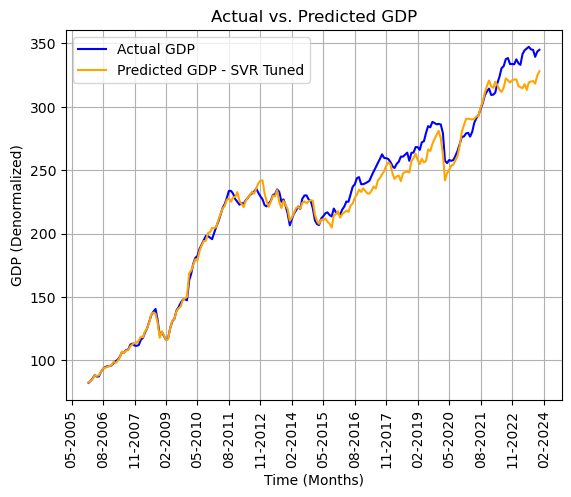

In [45]:
plt.plot(dates, data_ML['ID_GDP_USD'].values, label='Actual GDP', color='blue', linestyle='-')
plt.plot(dates, final_predictions_SVR, label='Predicted GDP - SVR Tuned', color='orange', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#Ridge
model_performance_LRR = []

# Iterate over the folds
for train_index, test_index in kfold.split(train_val_features):
    X_train, X_test = train_val_features[train_index], train_val_features[test_index]
    y_train, y_test = train_val_target[train_index], train_val_target[test_index]

    model_LRR = Ridge(alpha=0.037)  # You can adjust the alpha parameter if needed
    model_LRR.fit(X_train, y_train)
    predictions_LRR = model_LRR.predict(holdout_features)
    mse_LRR = mean_squared_error(holdout_target, predictions_LRR)
    
    model_performance_LRR.append((model_LRR, mse_LRR))
    
    print(f'Train indices: {train_index[0]}-{train_index[-1]}, Test indices: {test_index[0]}-{test_index[-1]}')
    print(f'MSE: {mse_LRR}')

Train indices: 0-21, Test indices: 22-36
MSE: 0.3733827107239182
Train indices: 0-36, Test indices: 37-51
MSE: 0.18879997432009768
Train indices: 0-51, Test indices: 52-66
MSE: 0.09185189426527872
Train indices: 0-66, Test indices: 67-81
MSE: 0.06720186344439444
Train indices: 0-81, Test indices: 82-96
MSE: 0.05591070914877613
Train indices: 0-96, Test indices: 97-111
MSE: 0.003254873143027021
Train indices: 0-111, Test indices: 112-126
MSE: 0.0033671957395283
Train indices: 0-126, Test indices: 127-141
MSE: 0.007663273677515589
Train indices: 0-141, Test indices: 142-156
MSE: 0.00995796610917752
Train indices: 0-156, Test indices: 157-171
MSE: 0.005721032170426805


In [47]:
# Sorting models based on MSE
top_models_LRR = sorted(model_performance_LRR, key=lambda x: x[1])[:3]

# Print top model performance
print("Top 3 Model Performances:")
for model, mse in top_models_LRR:
    print(f'MSE: {mse}')

# Prediction using top models
predictions_LRR = []
for model, _ in top_models_LRR:
    pred = model.predict(scaled_features_ML)
    pred = scaler.inverse_transform(pred.reshape(-1, 1))  # Scale back the prediction
    predictions_LRR.append(pred)

# Calculate the median of predictions from the top 3 models
final_predictions_LRR = np.median(np.array(predictions_LRR), axis=0)
# Compute RMSE for the last 65 entries
rmse_LRR = np.sqrt(mean_squared_error(data_ML['ID_GDP_USD'][-60:].values, final_predictions_LRR[-60:]))
print("RMSE:", rmse_LRR)

Top 3 Model Performances:
MSE: 0.003254873143027021
MSE: 0.0033671957395283
MSE: 0.005721032170426805
RMSE: 13.326816051476387


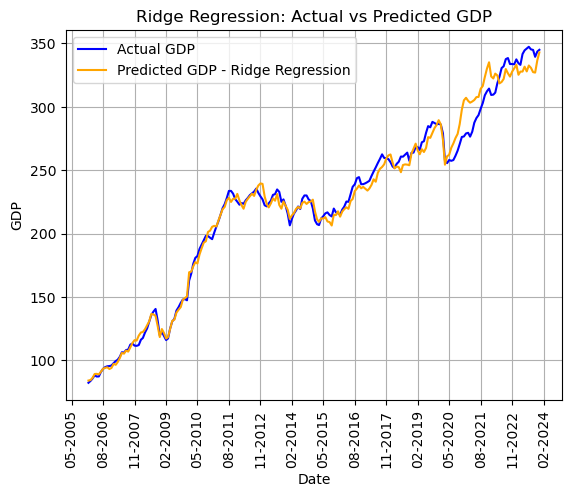

In [48]:
plt.plot(dates, data_ML['ID_GDP_USD'].values, label='Actual GDP', color='blue', linestyle='-')
plt.plot(dates, final_predictions_LRR, label='Predicted GDP - Ridge Regression', color='orange', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))
plt.xticks(rotation=90)
plt.title('Ridge Regression: Actual vs Predicted GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_1 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_1 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_1,
    final_predictions_LRR_1,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])

# Calculate the median across predictions for each instance (axis=1)
predictions_ensemble_median = np.median(predictions_stack, axis=1)

# Assuming 'data['ID_GDP_USD'].values[-65:]' is a 1D array (65,)
true_values = data_DL['ID_GDP_USD'].values[-120:]
rmse = np.sqrt(mean_squared_error(true_values, predictions_ensemble_median))

print("RMSE:", rmse)

RMSE: 14.14345306913413


In [50]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_2 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_2 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_2,
    final_predictions_LRR_2,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])

# Calculate the mean across predictions for each instance (axis=1)
predictions_ensemble_mean = np.mean(predictions_stack, axis=1)

rmse = np.sqrt(mean_squared_error(true_values, predictions_ensemble_mean))

print("RMSE:", rmse)

RMSE: 13.7888430667236


In [51]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_3 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_3 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_3,
    final_predictions_LRR_3,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])


weights = [0.2, 0.2, 0.3, 0.3]  # Ensure these sum to 1

# Calculate weighted average
predictions_ensemble_weighted = np.average(predictions_stack, axis=1, weights=weights)

# Compute RMSE for the weighted average
rmse_weighted = np.sqrt(mean_squared_error(true_values, predictions_ensemble_weighted))
print("Weighted RMSE:", rmse_weighted)

Weighted RMSE: 14.808573889027798


In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)

true_values_train = data_DL['ID_GDP_USD'].values[n_prev_days:-120]


print("SVR Predictions Train Size:", final_predictions_SVR[n_prev_days:-120].shape)
print("LRR Predictions Train Size:", final_predictions_LRR[n_prev_days:-120].shape)
print("CNN Predicted Values Train Size:", final_predicted_values_CNN[:-120].shape)
print("GRU Predicted Values Train Size:", final_predicted_values_GRU[:-120].shape)
print("Size of true_values_train:", true_values_train.shape)

# Stack the predictions for the training set
predictions_stack_train = np.hstack([
    final_predictions_SVR[n_prev_days:-120].reshape(-1, 1),  # Reshape is technically not needed here since they are already (192, 1)
    final_predictions_LRR[n_prev_days:-120].reshape(-1, 1),
    final_predicted_values_CNN[:-120],
    final_predicted_values_GRU[:-120]
])

# Stack the predictions for the test set
predictions_stack_test = np.hstack([
    final_predictions_SVR[-120:].reshape(-1, 1),
    final_predictions_LRR[-120:].reshape(-1, 1),
    final_predicted_values_CNN[-120:],
    final_predicted_values_GRU[-120:]
])

meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(predictions_stack_train.shape[1],)),  # Input layer
    Dropout(0,2),
    Dense(16, activation='linear'),  # Hidden layer
    Dense(1)  # Output layer
])

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
meta_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

meta_model.fit(predictions_stack_train, true_values_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

# Use the trained model to make predictions
predictions_ensemble_stacked = meta_model.predict(predictions_stack_test)

# Compute RMSE for the neural network model
rmse_stacked = np.sqrt(mean_squared_error(true_values, predictions_ensemble_stacked.flatten()))  # Flatten to make sure the shapes align
print("Neural Network Stacked RMSE:", rmse_stacked)

SVR Predictions Train Size: (87, 1)
LRR Predictions Train Size: (87, 1)
CNN Predicted Values Train Size: (87, 1)
GRU Predicted Values Train Size: (87, 1)
Size of true_values_train: (87,)
Epoch 1/100


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 52877.6836 - mean_squared_error: 52877.6836 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 46078.6289 - mean_squared_error: 46078.6289 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39840.1211 - mean_squared_error: 39840.1211 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 34145.5859 - mean_squared_error: 34145.5859 - learning_rate: 0.0010
Epoch 5/100


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)
C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error,learning_rate.
  callback.on_epoch_end(epoch, logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28969.2891 - mean_squared_error: 28969.2891 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 24288.5234 - mean_squared_error: 24288.5234 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 20094.5117 - mean_squared_error: 20094.5117 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 16380.4141 - mean_squared_error: 16380.4141 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 13119.7666 - mean_squared_error: 13119.7666 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10287.6172 - mean_squared_error: 10287.6172 - learning_rate: 0.0010
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7865.1792 - mean_squared_error: 7865.1792 - learning_rate: 0.0010
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 5833.1362 - mean_squared_error: 5833.1362 - learning_rate: 0.0010
Epoch 13/100
3/3 ━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.4211 - mean_squared_error: 17.4211 - learning_rate: 0.0010
Epoch 59/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 17.4184 - mean_squared_error: 17.4184 - learning_rate: 0.0010
Epoch 60/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 17.4168 - mean_squared_error: 17.4168 - learning_rate: 0.0010
Epoch 61/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.4157 - mean_squared_error: 17.4157 - learning_rate: 0.0010
Epoch 62/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 17.4151 - mean_squared_error: 17.4151 - learning_rate: 0.0010
Epoch 63/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 17.4149 - mean_squared_error: 17.4149 - learning_rate: 0.0010
Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.4150 - mean_squared_error: 17.4150 - learning_rate: 0.0010
Epoch 65/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 17.4153 - mean_squared_error: 17.4153 - learning_rate: 0.0010
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1

In [53]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

model = ExponentialSmoothing(predictions_ensemble_stacked, seasonal='add', seasonal_periods=12).fit()
predictions_ensemble_stacked_smoothing = model.fittedvalues
rmse_stacked_smoothing = np.sqrt(mean_squared_error(true_values, predictions_ensemble_stacked_smoothing))
print("Stacked RMSE:", rmse_stacked_smoothing)

Stacked RMSE: 11.834443528033225


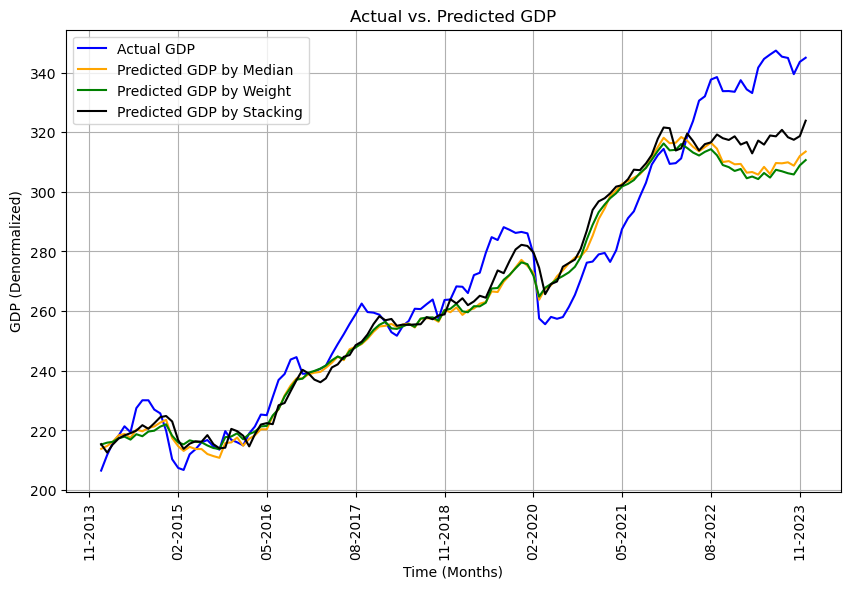

In [54]:
# Plot actual vs. predicted GDP
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
plt.figure(figsize=(10, 6))
plt.plot(dates[-120:], data_ML['ID_GDP_USD'].values[-120:], label="Actual GDP", color="blue")
plt.plot(dates[-120:], predictions_ensemble_median.flatten(), label="Predicted GDP by Median", color="orange")
#plt.plot(dates[-120:], predictions_ensemble_mean.flatten(), label="Predicted GDP by Mean", color="red")
plt.plot(dates[-120:], predictions_ensemble_weighted.flatten(), label="Predicted GDP by Weight", color="green")
plt.plot(dates[-120:], predictions_ensemble_stacked_smoothing.flatten(), label="Predicted GDP by Stacking", color="black")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("Actual vs. Predicted GDP")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
df_stock_esg_id = pd.read_csv('Dataset/Stock_Indonesia.csv')
df_stock_esg_id

Symbol                       Company_Name  Net_income  Price    Volume  \
0    PGEO    PERTAMINA GEOTHERMAL ENERGY TBK       2.492   1215    6.653M   
1    JSMR                         JASA MARGA       6.794   4930    3.003M   
2    BSDE          PT BUMI SERPONG DAMAI TBK       1.945    940    7.796M   
3    UNVR                 UNILEVER INDONESIA       4.801   3080    7.419M   
4    BBRI              BANK RAKYAT INDONESIA      60.100   4510  162.458M   
5    CTRA                CIPUTRA DEVELOPMENT       1.846   1150   14.251M   
6    PWON                    PT PAKUWON JATI       2.105    398    7.434M   
7    MAPI               MITRA ADIPERKASA TBK       1.894   1405   12.961M   
8    BNGA                 BANK CIMB NIAGA TB       6.474   1760    3.008M   
9    BBNI  PT BANK NEGARA INDONESIA(PERSERO)      20.909   4610   28.529M   
10   BBCA                  BANK CENTRAL ASIA      48.639   9475   33.982M   
11   BBTN       BANK TABUNGAN NEGARA PERSERO       3.501   1280   18.919M   
12   BDMN      PT BANK DANAMON INDONESIA TBK       3.504   2620    165.6K   
13   PGAS          PERUSAHAAN GAS NEGARA TBK       4.236   1610   38.775M   
14   AKRA                 AKR CORPORINDO TBK       2.780   1600   11.449M   
15   TOWR                 SARANA MENARA NUSA       3.253    715  145.791M   
16   NISP                 BANK OCBC NISP TBK       4.091   1245    2.805M   
17   BRIS         BANK SYARIAH INDONESIA TBK       5.704   2300   23.965M   
18   TLKM      TELKOM INDONESIA(PERSERO) TBK      24.560   3010   52.957M   
19   INKP            INDAH KIAT PULP & PAPER       6.267   9300    1.032M   
20   BMRI         BANK MANDIRI (PERSERO) TBK      55.060   6200   60.425M   
21   MEDC         MEDCO ENERGI INTERNATIONAL       5.036   1310   57.017M   
22   INTP        INDOCEMENT TUNGGAL PRAKARSA       1.950   7225    5.463M   
23   TKIM          PABRIK KERTAS TJIWI KIMIA       2.620   8775    936.6K   
24   PNBN                 BANK PAN INDONESIA       2.532   1200     1.84M   
25   MYOR                       MAYORA INDAH       3.194   2280    1.324M   
26   HMSP          HANJAYA MANDALA SAMPOERNA       8.097    730    6.124M   
27   SMGR       SEMEN INDONESIA (PERSERO)TBK       2.170   3940   89.728M   
28   AMRT         SUMBER ALFARIA TRIJAYA TBK       3.404   2800    5.932M   
29   ISAT            INDOSAT(PT INDOSAT TBK)       4.506  10600    1.443M   
30   ASII                ASTRA INTERNATIONAL      33.839   4530   32.831M   
31   PTBA                     BUKIT ASAM TBK       6.106   2570    5.524M   
32   KLBF                        KALBE FARMA       2.767   1540    9.293M   
33   INCO                 VALE INDONESIA TBK       4.178   4770   12.355M   
34   INDY                  INDIKA ENERGY TBK       1.823   1365     2.35M   
35   BYAN                BAYAN RESOURCES TBK      18.865  17900       20K   
36   GEMS            GOLDEN ENERGY MINES TBK       7.895   6800    647.9K   
37   INDF      PT INDOFOOD SUKSES MAKMUR TBK       8.147   6075    2.473M   
38   UNTR                    UNITED TRACTORS      20.612  23150    2.154M   
39   ANTM                      ANEKA TAMBANG       3.078   1445   31.874M   
40   CPIN         CHAROEN POKPHAND INDONESIA       2.319   5225    2.246M   
41   NCKL        TRIMEGAH BANGUN PERSADA TBK       5.619    990    4.136M   
42   GGRM                   GUDANG GARAM TBK       5.325  18450    261.9K   
43   ABMM                  ABM INVESTAMA TBK       4.402   3690    1.426M   
44   ICBP  INDOFOOD CBP SUKSES MAKMUR TBK PT       6.991  10375    1.164M   
45   ADRO         ADARO ENERGY INDONESIA TBK      25.000   2930   34.261M   
46   HRUM               HARUM ENERGY TBK. PT       2.301   1355    4.102M   
47   ITMG         INDO TAMBANGRAYA MEGAH TBK       7.620  25450    736.1K   
48   ADMR       ADARO MINERALS INDONESIA TBK       6.717   1365   20.831M   

    Market_cap     PE  EPS_dil                 Sector  ESG_Score  Revenue  \
0       49.172  19.98    60.82              Utilities       9.30    6.241  

In [65]:
stock_data = df_stock_esg_id[['Symbol', 'Company_Name', 'Net_income', 'ESG_Score', 'Revenue']]
stock_data.head()

Symbol                     Company_Name  Net_income  ESG_Score  Revenue
0   PGEO  PERTAMINA GEOTHERMAL ENERGY TBK       2.492       9.30    6.241
1   JSMR                       JASA MARGA       6.794      12.92   22.918
2   BSDE        PT BUMI SERPONG DAMAI TBK       1.945      14.83   12.438
3   UNVR               UNILEVER INDONESIA       4.801      18.80   38.086
4   BBRI            BANK RAKYAT INDONESIA      60.100      18.84  229.218

C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

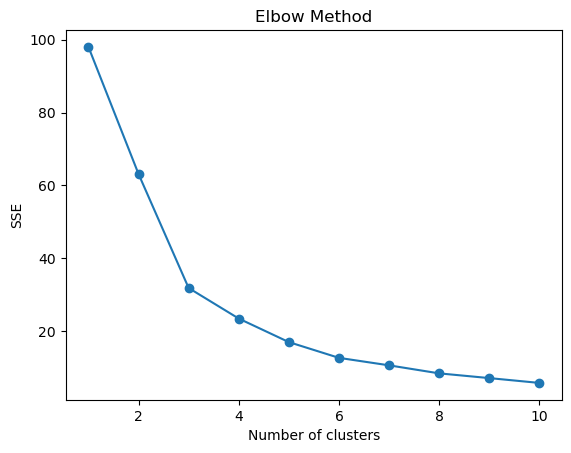

In [67]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


features = stock_data[['Revenue', 'ESG_Score']]

# Normalizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determining the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# Plotting the SSE to find the elbow
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()



In [98]:
# Assuming the optimal number of clusters from the Elbow Method is 3
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster data to the original dataframe
stock_data['Cluster'] = clusters

# Displaying the results
print(stock_data)



C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   Symbol                       Company_Name  Net_income  ESG_Score  Revenue  \
0    PGEO    PERTAMINA GEOTHERMAL ENERGY TBK       2.492       9.30    6.241   
1    JSMR                         JASA MARGA       6.794      12.92   22.918   
2    BSDE          PT BUMI SERPONG DAMAI TBK       1.945      14.83   12.438   
3    UNVR                 UNILEVER INDONESIA       4.801      18.80   38.086   
4    BBRI              BANK RAKYAT INDONESIA      60.100      18.84  229.218   
5    CTRA                CIPUTRA DEVELOPMENT       1.846      18.87    9.597   
6    PWON                    PT PAKUWON JATI       2.105      19.42    6.346   
7    MAPI               MITRA ADIPERKASA TBK       1.894      20.31   34.645   
8    BNGA                 BANK CIMB NIAGA TB       6.474      20.70   27.819   
9    BBNI  PT BANK NEGARA INDONESIA(PERSERO)      20.909      21.35   83.245   
10   BBCA                  BANK CENTRAL ASIA      48.639      22.67  114.338   
11   BBTN       BANK TABUNGAN NEGARA PER

C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\155342303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Cluster'] = clusters


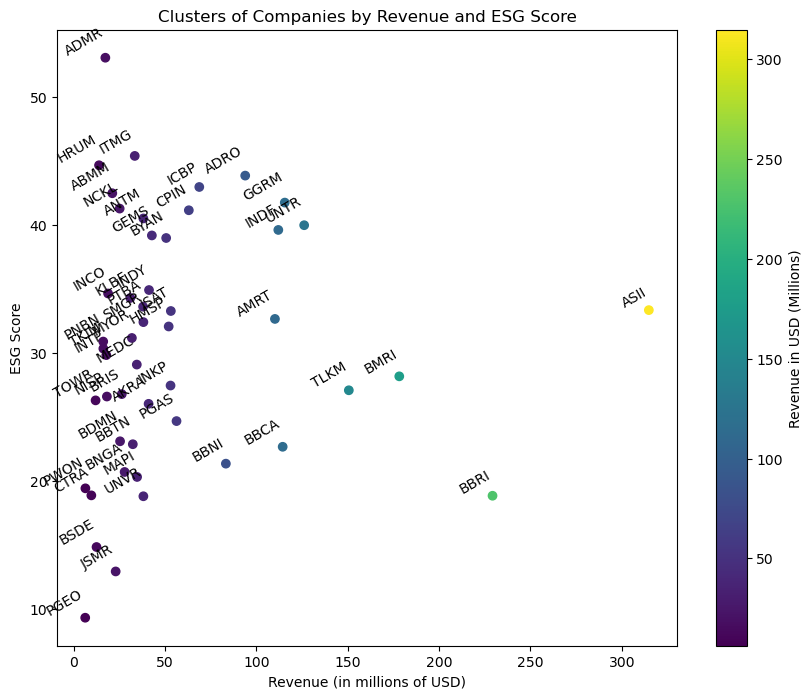

In [87]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has been preprocessed accordingly
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(stock_data['Revenue'], stock_data['ESG_Score'], c=stock_data['Revenue'], cmap='viridis')

# Adding annotations for each point with rotation
for i, txt in enumerate(stock_data['Symbol']):
    ax.annotate(txt, (stock_data['Revenue'].iloc[i], stock_data['ESG_Score'].iloc[i]), rotation=30, verticalalignment='bottom', horizontalalignment='right')

# Color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Revenue in USD (Millions)')

# Labels and title
ax.set_xlabel('Revenue (in millions of USD)')
ax.set_ylabel('ESG Score')
ax.set_title('Clusters of Companies by Revenue and ESG Score')

plt.show()


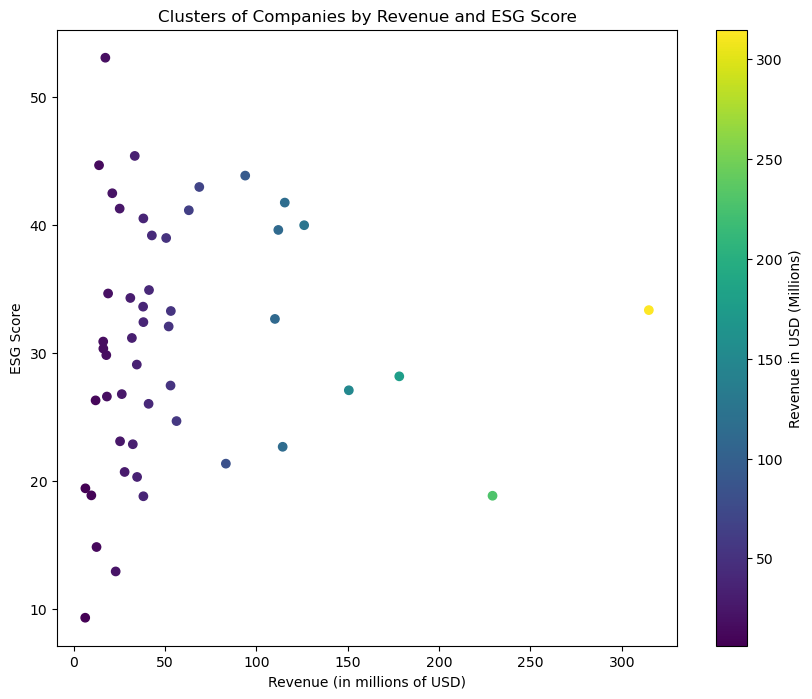

In [89]:
import matplotlib.pyplot as plt

# Assuming 'stock_data' is your DataFrame and it has been preprocessed accordingly
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot without annotations
scatter = ax.scatter(stock_data['Revenue'], stock_data['ESG_Score'], c=stock_data['Revenue'], cmap='viridis')

# Color bar to show the revenue scale
cbar = plt.colorbar(scatter)
cbar.set_label('Revenue in USD (Millions)')

# Set labels and title for clarity
ax.set_xlabel('Revenue (in millions of USD)')
ax.set_ylabel('ESG Score')
ax.set_title('Clusters of Companies by Revenue and ESG Score')

plt.show()


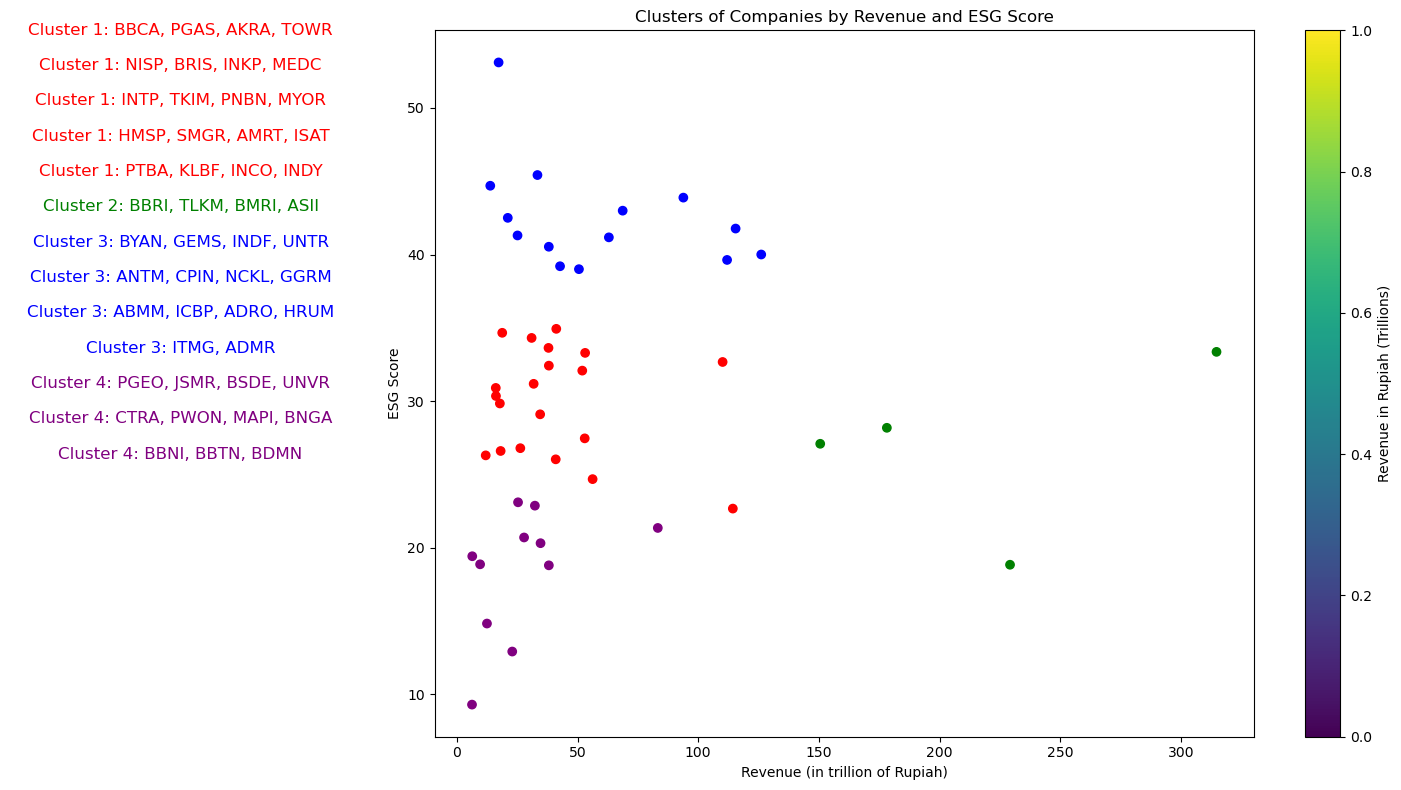

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'stock_data' is your DataFrame and it includes a 'Cluster' column for cluster assignment
fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 3]})

# Function to split list into chunks of up to 4 elements
def chunk_list(lst, n=4):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Grouping by clusters to list symbols
cluster_groups = stock_data.groupby('Cluster')['Symbol'].apply(list).sort_index()

# Left subplot for listing symbols and their cluster colors
text_y_position = 1
for cluster, symbols in cluster_groups.items():
    # Obtain cluster color
    cluster_color = stock_data[stock_data['Cluster'] == cluster]['Cluster'].map({0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}).iloc[0]
    # Split symbols into chunks and print each chunk in a new line
    for chunk in chunk_list(symbols):
        axs[0].text(0.5, text_y_position, f'Cluster {cluster+1}: ' + ', '.join(chunk),
                    verticalalignment='center', horizontalalignment='center', color=cluster_color, transform=axs[0].transAxes, fontsize=12)
        text_y_position -= 0.05  # Adjust this value based on your layout needs

axs[0].axis('off')

# Right subplot for the cluster scatter plot
colors = stock_data['Cluster'].map({0: 'red', 1: 'green', 2: 'blue', 3: 'purple'})  # Example cluster color mapping
scatter = axs[1].scatter(stock_data['Revenue'], stock_data['ESG_Score'], c=colors)
axs[1].set_xlabel('Revenue (in trillion of Rupiah)')
axs[1].set_ylabel('ESG Score')
axs[1].set_title('Clusters of Companies by Revenue and ESG Score')

# Color bar to show the revenue scale
cbar = plt.colorbar(scatter, ax=axs[1])
cbar.set_label('Revenue in Rupiah (Trillions)')

plt.tight_layout()
plt.show()


In [92]:
data_with_bond

Close_XAU  Spread_Bond_10Y2Y  Close_BRNT    Close_IDX  Close_WTI  \
Date                                                                          
01-2006   585.630000          29.533333   65.920000  1304.481500  67.062500   
02-2006   579.672222          28.857143   62.803158  1292.076000  63.026111   
03-2006   576.908333         -27.935484   64.589167  1328.442727  64.716250   
04-2006   624.444444         -46.866667   70.162105  1440.700526  69.855882   
05-2006   646.940000         -70.451613   68.802000  1400.940000  69.068500   
...              ...                ...         ...          ...        ...   
08-2023  1943.490909          26.565217   83.570909  6894.936667  79.384091   
09-2023  1926.014286          34.380952   89.359524  6903.906000  85.591429   
10-2023  1954.436364          43.545455   86.855000  6815.352273  82.598636   
11-2023  1985.525000          18.272727   81.930909  6929.804545  77.345909   
12-2023  2013.854762          17.428571   79.384500  7056.916000  74.387143   

         Close_USDIDR   M2_ID_USD  M2_US_USD     M2_EU_USD    M2_JP_USD  \
Date                                                                      
01-2006   9308.928571  128.364826     6724.3   7571.994733  6130.578198   
02-2006   9237.950000  129.657770     6748.6   7470.628129  6022.892767   
03-2006   9137.333333  131.192325     6762.9   7584.603150  6034.779574   
04-2006   8979.400000  133.318707     6800.1   7895.056665  6142.924845   
05-2006   9196.380952  135.038447     6806.9   8068.260020  6274.797948   
...               ...         ...        ...           ...          ...   
08-2023  15264.172727  301.982170    20763.4  16289.039344  8590.628984   
09-2023  15352.666667  304.247666    20710.1  16108.033126  8522.884023   
10-2023  15605.409091  300.610639    20698.7  16001.764705  8488.143345   
11-2023  15425.500000  306.359146    20724.9  16362.080543  8475.408559   
12-2023  15370.714286  321.099261    20786.1  16611.457238  8777.638422   

           M2_UK_USD  InflationYoY_ID  ID_Import_USD  ID_Export_USD  Rate_ID  \
Date                                                                           
01-2006  2405.009055           17.110       0.000471       0.000812    12.75   
02-2006  2391.532002           17.030       0.000490       0.000801    12.75   
03-2006  2412.923736           17.920       0.000483       0.000820    12.75   
04-2006  2497.809283           15.740       0.000532       0.000851    12.75   
05-2006  2586.568717           15.400       0.000554       0.000910    12.50   
...              ...              ...            ...            ...      ...   
08-2023  3798.653240            3.175       0.001237       0.001441     5.75   
09-2023  3669.632442            2.280       0.001130       0.001351     5.75   
10-2023  3654.982574            2.280       0.001197       0.001419     6.00   
11-2023  3734.008014            2.710       0.001270       0.001426     6.00   
12-2023  3781.982653            2.610       0.001243       0.001457     6.00   

          ID_CE_USD  ID_GFCF_USD  ID_GDP_USD  Total_Bonds  
Date                                                       
01-2006   60.336661    19.695142   82.347572        90.98  
02-2006   60.173235    20.005232   83.856303        93.68  
03-2006   60.201919    20.386035   85.665366        95.73  
04-2006   62.252675    21.124277   88.285297       101.30  
05-2006   61.752372    20.996593   87.289229        97.75  
...             ...          ...         ...          ...  
08-2023  211.647325   100.500326  345.325670       405.34  
09-2023  210.139064   102.394394  344.890052       403.43  
10-2023  211.570978   101.783554  339.465799       397.90  
11-2023  218.930235   104.030404  343.588430       416.23  
12-2023  224.619685   105.464715  344.977071       427.71  

[216 rows x 19 columns]

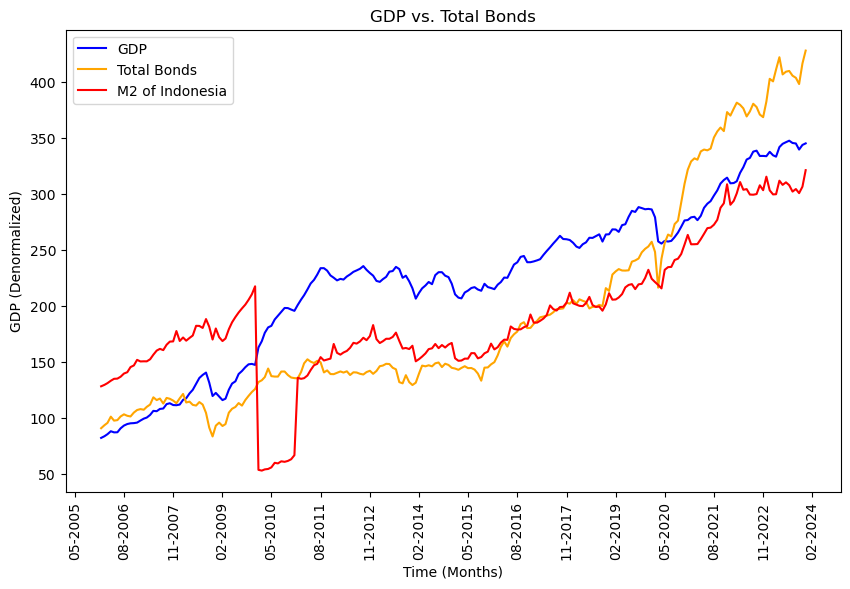

In [117]:
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
plt.figure(figsize=(10, 6))
plt.plot(dates, data_with_bond['ID_GDP_USD'], label="GDP", color="blue")
plt.plot(dates, data_with_bond['Total_Bonds'], label="Total Bonds", color="orange")
plt.plot(dates, data_with_bond['M2_ID_USD'], label="M2 of Indonesia", color="red")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("GDP vs. Total Bonds")
plt.legend()
plt.grid(False)
plt.show()

C:\Users\ITSEC\AppData\Local\Temp\ipykernel_32804\1161488478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_bond['GDP_Growth'] = data_with_bond['ID_GDP_USD'].pct_change() * 100


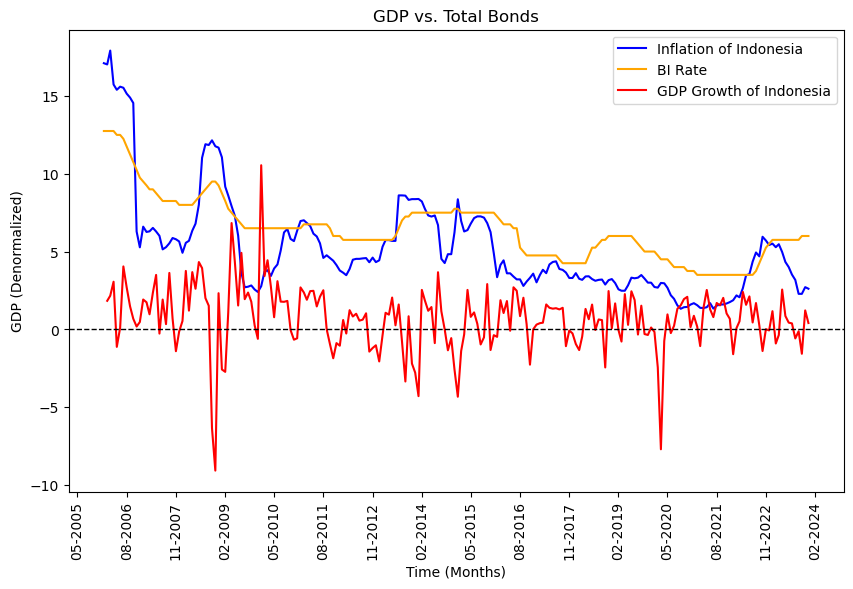

In [133]:
data_with_bond['GDP_Growth'] = data_with_bond['ID_GDP_USD'].pct_change() * 100 

dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
plt.figure(figsize=(10, 6))
plt.plot(dates, data_with_bond['InflationYoY_ID'], label="Inflation of Indonesia", color="blue")
plt.plot(dates, data_with_bond['Rate_ID'], label="BI Rate", color="orange")
plt.plot(dates, data_with_bond['GDP_Growth'], label="GDP Growth of Indonesia", color="red")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("GDP (Denormalized)")
plt.title("GDP vs. Total Bonds")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
#Predictive on Inflation

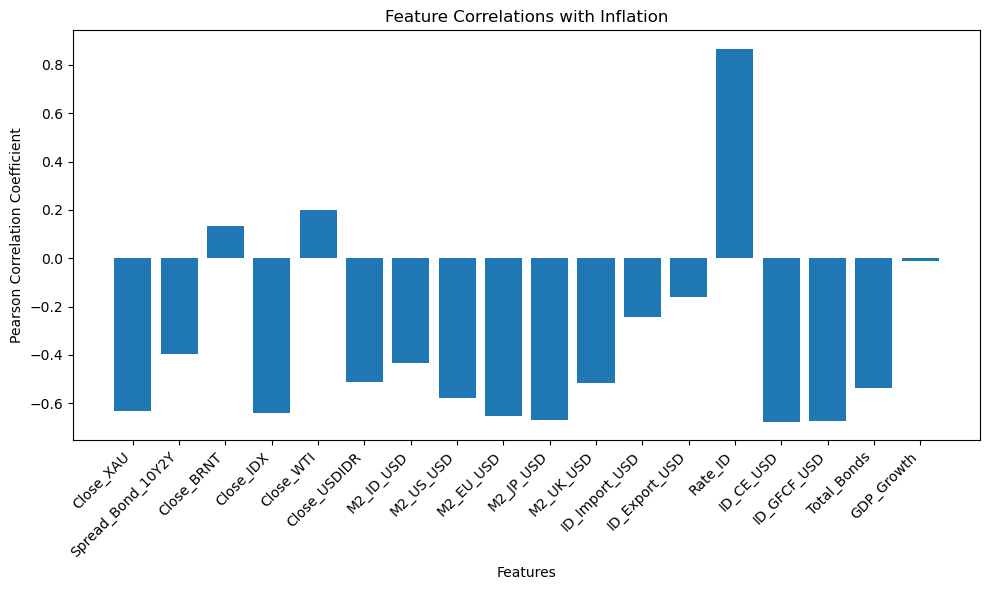

In [136]:
# Extract features and target

data_correlation = data_with_bond.drop(['ID_GDP_USD'], axis=1)
features = data_correlation.drop(['InflationYoY_ID'], axis=1)
target = data_correlation['InflationYoY_ID']

# Calculate Pearson correlation coefficients
correlations = features.corrwith(target)

# Plot correlations
plt.figure(figsize=(10, 6))
plt.bar(features.columns, correlations)
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.title("Feature Correlations with Inflation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [137]:
data_with_bond.columns

Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_BRNT', 'Close_IDX',
       'Close_WTI', 'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
       'M2_JP_USD', 'M2_UK_USD', 'InflationYoY_ID', 'ID_Import_USD',
       'ID_Export_USD', 'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD',
       'Total_Bonds', 'GDP_Growth'],
      dtype='object')

In [139]:
List_of_Top_Models = []
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
n_prev_days = 9


inflation_features = ['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_IDX',
                      'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
                      'M2_JP_USD', 'M2_UK_USD', 'Rate_ID', 'ID_CE_USD', 
                      'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds', 'InflationYoY_ID']

data_DL = data_with_bond[inflation_features]
PCA_Enable_DL = False

target_DL = data_DL['InflationYoY_ID'].values
features_DL = data_DL.drop(['InflationYoY_ID'], axis=1)

numeric_features_DL = np.array(features_DL.values, dtype=np.float64)
scaled_features_DL = features_scaler.fit_transform(numeric_features_DL)
target_DL = target_scaler.fit_transform(np.array(target_DL.reshape(-1, 1), dtype=np.float64))


if PCA_Enable_DL == True:
    pca = PCA(n_components=0.90)  # retains 95% of the variance
    print("NaN in each column:\n", np.isnan(scaled_features_DL).sum(axis=0))
    scaled_features_DL = pca.fit_transform(scaled_features_DL)
    print("PCA ENABLED")
    
print("Scaled Values: ", len(scaled_features_DL))
# Prepare input sequences for training/validation
input_sequences_DL = [scaled_features_DL[i-n_prev_days:i, :] for i in range(n_prev_days, len(scaled_features_DL))]
input_sequences_DL = np.array(input_sequences_DL)
input_sequences_DL.shape

Scaled Values:  216


(207, 9, 14)

In [142]:
def LSTM_process_inflation(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['InflationYoY_ID'].values
    features = data.drop(['InflationYoY_ID'], axis=1)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    print(target.shape)
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 10

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units= 48, recurrent_dropout=0.2, return_sequences = True, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 12, recurrent_dropout=0.2))
        
        model.add(Dense(3))
        model.add(Dense(1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('Inflation_LSTM_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=10000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['LSTM', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)
    
    return model_performance

In [143]:
model_performance_LSTM_Inflation = LSTM_process_inflation(data_DL, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_IDX', 'Close_USDIDR',
       'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD',
       'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds',
       'InflationYoY_ID'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_IDX            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
InflationYoY_ID      0
dtype: int64
(216, 14)
(216, 1)
(216, 14)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_76 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 3.0776 - mean_absolute_error: 0.5500 - val_loss: 3.1718 - val_mean_absolute_error: 0.6706 - learning_rate: 0.0010
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 2.9551 - mean_absolute_error: 0.4539 - val_loss: 3.0372 - val_mean_absolute_error: 0.5622 - learning_rate: 0.0010
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.8430 - mean_absolute_error: 0.3680 - val_loss: 2.9061 - val_mean_absolute_error: 0.4570 - learning_rate: 0.0010
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 2.7258 - mean_absolute_error: 0.2766 - val_loss: 2.7782 - val_mean_absolute_error: 0.3548 - learning_rate: 0.0010
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 2.6124 - mean_absolute_error: 0.1890 - val_loss: 2.6735 - val_mean_absolute_error: 0.2755 - learning_rate: 0.0010
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.5370 - mean_absolute_error: 0.1390 - val_loss: 2.6082 - val_mean_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.6603 - mean_absolute_error: 0.0808 - val_loss: 1.7717 - val_mean_absolute_error: 0.2136 - learning_rate: 0.0010
Epoch 41/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.6434 - mean_absolute_error: 0.0852 - val_loss: 1.7510 - val_mean_absolute_error: 0.2140 - learning_rate: 0.0010
Epoch 42/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.6184 - mean_absolute_error: 0.0814 - val_loss: 1.7300 - val_mean_absolute_error: 0.2139 - learning_rate: 0.0010
Epoch 43/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 1.5899 - mean_absolute_error: 0.0739 - val_loss: 1.7091 - val_mean_absolute_error: 0.2140 - learning_rate: 0.0010
Epoch 44/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.5775 - mean_absolute_error: 0.0823 - val_loss: 1.6878 - val_mean_absolute_error: 0.2134 - learning_rate: 0.0010
Epoch 45/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.5472 - mean_absolute_error: 0.0729 - val_loss: 1.6657 - val_mean_absolu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.9425 - mean_absolute_error: 0.0730 - val_loss: 1.0581 - val_mean_absolute_error: 0.2036 - learning_rate: 0.0010
Epoch 80/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.9232 - mean_absolute_error: 0.0687 - val_loss: 1.0426 - val_mean_absolute_error: 0.2031 - learning_rate: 0.0010
Epoch 81/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.9146 - mean_absolute_error: 0.0750 - val_loss: 1.0279 - val_mean_absolute_error: 0.2030 - learning_rate: 0.0010
Epoch 82/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.8968 - mean_absolute_error: 0.0719 - val_loss: 1.0142 - val_mean_absolute_error: 0.2037 - learning_rate: 0.0010
Epoch 83/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.8845 - mean_absolute_error: 0.0739 - val_loss: 0.9998 - val_mean_absolute_error: 0.2035 - learning_rate: 0.0010
Epoch 84/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.8696 - mean_absolute_error: 0.0733 - val_loss: 0.9860 - val_mean_absolu

Epoch 118/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.4687 - mean_absolute_error: 0.0715 - val_loss: 0.5933 - val_mean_absolute_error: 0.2053 - learning_rate: 0.0010
Epoch 119/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4633 - mean_absolute_error: 0.0754 - val_loss: 0.5851 - val_mean_absolute_error: 0.2062 - learning_rate: 0.0010
Epoch 120/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.4519 - mean_absolute_error: 0.0730 - val_loss: 0.5769 - val_mean_absolute_error: 0.2068 - learning_rate: 0.0010
Epoch 121/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4425 - mean_absolute_error: 0.0724 - val_loss: 0.5684 - val_mean_absolute_error: 0.2068 - learning_rate: 0.0010
Epoch 122/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.4340 - mean_absolute_error: 0.0724 - val_loss: 0.5598 - val_mean_absolute_error: 0.2065 - learning_rate: 0.0010
Epoch 123/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.4234 - mean_absolute_error: 0.0701 - val_loss: 0.5

Epoch 157/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2144 - mean_absolute_error: 0.0703 - val_loss: 0.3402 - val_mean_absolute_error: 0.2000 - learning_rate: 0.0010
Epoch 158/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2087 - mean_absolute_error: 0.0685 - val_loss: 0.3363 - val_mean_absolute_error: 0.1997 - learning_rate: 0.0010
Epoch 159/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2090 - mean_absolute_error: 0.0725 - val_loss: 0.3338 - val_mean_absolute_error: 0.2008 - learning_rate: 0.0010
Epoch 160/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2070 - mean_absolute_error: 0.0740 - val_loss: 0.3318 - val_mean_absolute_error: 0.2024 - learning_rate: 0.0010
Epoch 161/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1990 - mean_absolute_error: 0.0696 - val_loss: 0.3305 - val_mean_absolute_error: 0.2047 - learning_rate: 0.0010
Epoch 162/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1960 - mean_absolute_error: 0.0703 - val_loss: 0.3

Epoch 196/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1397 - mean_absolute_error: 0.0721 - val_loss: 0.2687 - val_mean_absolute_error: 0.2020 - learning_rate: 0.0010
Epoch 197/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1385 - mean_absolute_error: 0.0718 - val_loss: 0.2690 - val_mean_absolute_error: 0.2032 - learning_rate: 0.0010
Epoch 198/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1378 - mean_absolute_error: 0.0720 - val_loss: 0.2683 - val_mean_absolute_error: 0.2033 - learning_rate: 0.0010
Epoch 199/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1392 - mean_absolute_error: 0.0742 - val_loss: 0.2666 - val_mean_absolute_error: 0.2024 - learning_rate: 0.0010
Epoch 200/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1339 - mean_absolute_error: 0.0697 - val_loss: 0.2644 - val_mean_absolute_error: 0.2008 - learning_rate: 0.0010
Epoch 201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1353 - mean_absolute_error: 0.0718 - val_loss: 0.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1251 - mean_absolute_error: 0.0712 - val_loss: 0.2554 - val_mean_absolute_error: 0.2016 - learning_rate: 1.0000e-04
Epoch 233/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1237 - mean_absolute_error: 0.0699 - val_loss: 0.2552 - val_mean_absolute_error: 0.2014 - learning_rate: 1.0000e-04
Epoch 234/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1271 - mean_absolute_error: 0.0734 - val_loss: 0.2548 - val_mean_absolute_error: 0.2012 - learning_rate: 1.0000e-04
Epoch 235/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1248 - mean_absolute_error: 0.0712 - val_loss: 0.2546 - val_mean_absolute_error: 0.2010 - learning_rate: 1.0000e-04
Epoch 236/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1248 - mean_absolute_error: 0.0713 - val_loss: 0.2544 - val_mean_absolute_error: 0.2009 - learning_rate: 1.0000e-04
Epoch 237/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1255 - mean_absolute_error: 0.0721 - val_loss:

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 912ms/step - loss: 2.9596 - mean_absolute_error: 0.4526 - val_loss: 2.7169 - val_mean_absolute_error: 0.2591 - learning_rate: 0.0010
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.8176 - mean_absolute_error: 0.3663 - val_loss: 2.5634 - val_mean_absolute_error: 0.1603 - learning_rate: 0.0010
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.6794 - mean_absolute_error: 0.2825 - val_loss: 2.4303 - val_mean_absolute_error: 0.0807 - learning_rate: 0.0010
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 2.5492 - mean_absolute_error: 0.2057 - val_loss: 2.3855 - val_mean_absolute_error: 0.0887 - learning_rate: 0.0010
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.4281 - mean_absolute_error: 0.1374 - val_loss: 2.3857 - val_mean_absolute_error: 0.1419 - learning_rate: 0.0010
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.3751 - mean_absolute_error: 0.1375 - val_loss: 2.3972 - val_mean

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.9248 - mean_absolute_error: 0.1122 - val_loss: 0.9385 - val_mean_absolute_error: 0.1519 - learning_rate: 0.0010
Epoch 41/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.8936 - mean_absolute_error: 0.1102 - val_loss: 0.9140 - val_mean_absolute_error: 0.1559 - learning_rate: 0.0010
Epoch 42/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.8561 - mean_absolute_error: 0.1013 - val_loss: 0.9026 - val_mean_absolute_error: 0.1722 - learning_rate: 0.0010
Epoch 43/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.8295 - mean_absolute_error: 0.1023 - val_loss: 0.8898 - val_mean_absolute_error: 0.1865 - learning_rate: 0.0010
Epoch 44/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8099 - mean_absolute_error: 0.1096 - val_loss: 0.8546 - val_mean_absolute_error: 0.1777 - learning_rate: 0.0010
Epoch 45/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7748 - mean_absolute_error: 0.1009 - val_loss: 0.8220 - val_mean_absolut

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2213 - mean_absolute_error: 0.0950 - val_loss: 0.2322 - val_mean_absolute_error: 0.1118 - learning_rate: 0.0010
Epoch 80/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2035 - mean_absolute_error: 0.0838 - val_loss: 0.2594 - val_mean_absolute_error: 0.1447 - learning_rate: 0.0010
Epoch 81/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2063 - mean_absolute_error: 0.0922 - val_loss: 0.2698 - val_mean_absolute_error: 0.1607 - learning_rate: 0.0010
Epoch 82/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2119 - mean_absolute_error: 0.1035 - val_loss: 0.2466 - val_mean_absolute_error: 0.1432 - learning_rate: 0.0010
Epoch 83/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1993 - mean_absolute_error: 0.0965 - val_loss: 0.2095 - val_mean_absolute_error: 0.1112 - learning_rate: 0.0010
Epoch 84/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1885 - mean_absolute_error: 0.0906 - val_loss: 0.1966 - val_mean_absolute_

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - loss: 2.8874 - mean_absolute_error: 0.3554 - val_loss: 2.6527 - val_mean_absolute_error: 0.1886 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.6430 - mean_absolute_error: 0.1898 - val_loss: 2.4414 - val_mean_absolute_error: 0.0562 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.5043 - mean_absolute_error: 0.1303 - val_loss: 2.4210 - val_mean_absolute_error: 0.1165 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.4562 - mean_absolute_error: 0.1629 - val_loss: 2.3270 - val_mean_absolute_error: 0.1022 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.3667 - mean_absolute_error: 0.1529 - val_loss: 2.2088 - val_mean_absolute_error: 0.0618 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.2660 - mean_absolute_error: 0.1298 - val_loss: 2.1264 - val_mean_ab

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4864 - mean_absolute_error: 0.0940 - val_loss: 0.4127 - val_mean_absolute_error: 0.0431 - learning_rate: 0.0010
Epoch 41/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4654 - mean_absolute_error: 0.0993 - val_loss: 0.4204 - val_mean_absolute_error: 0.0750 - learning_rate: 0.0010
Epoch 42/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4332 - mean_absolute_error: 0.0909 - val_loss: 0.4025 - val_mean_absolute_error: 0.0801 - learning_rate: 0.0010
Epoch 43/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4042 - mean_absolute_error: 0.0848 - val_loss: 0.3776 - val_mean_absolute_error: 0.0773 - learning_rate: 0.0010
Epoch 44/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3826 - mean_absolute_error: 0.0852 - val_loss: 0.3500 - val_mean_absolute_error: 0.0704 - learning_rate: 0.0010
Epoch 45/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3664 - mean_absolute_error: 0.0896 - val_loss: 0.3094 - val_mean_absolute_err

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1519 - mean_absolute_error: 0.0797 - val_loss: 0.1358 - val_mean_absolute_error: 0.0642 - learning_rate: 0.0010
Epoch 80/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1528 - mean_absolute_error: 0.0814 - val_loss: 0.1466 - val_mean_absolute_error: 0.0760 - learning_rate: 0.0010
Epoch 81/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1484 - mean_absolute_error: 0.0780 - val_loss: 0.1441 - val_mean_absolute_error: 0.0744 - learning_rate: 0.0010
Epoch 82/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1480 - mean_absolute_error: 0.0784 - val_loss: 0.1307 - val_mean_absolute_error: 0.0619 - learning_rate: 0.0010
Epoch 83/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1443 - mean_absolute_error: 0.0757 - val_loss: 0.1423 - val_mean_absolute_error: 0.0743 - learning_rate: 0.0010
Epoch 84/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1447 - mean_absolute_error: 0.0768 - val_loss: 0.1361 - val_mean_absolute_err

Epoch 116/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1262 - mean_absolute_error: 0.0671 - val_loss: 0.1366 - val_mean_absolute_error: 0.0776 - learning_rate: 1.0000e-04
Epoch 117/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1358 - mean_absolute_error: 0.0769 - val_loss: 0.1344 - val_mean_absolute_error: 0.0757 - learning_rate: 1.0000e-04
Epoch 118/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1300 - mean_absolute_error: 0.0712 - val_loss: 0.1304 - val_mean_absolute_error: 0.0717 - learning_rate: 1.0000e-04
Epoch 119/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1293 - mean_absolute_error: 0.0707 - val_loss: 0.1267 - val_mean_absolute_error: 0.0681 - learning_rate: 1.0000e-04
Epoch 120/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1331 - mean_absolute_error: 0.0744 - val_loss: 0.1250 - val_mean_absolute_error: 0.0664 - learning_rate: 1.0000e-04
Epoch 121/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1311 - mean_absolute_error: 0.0725 -

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - loss: 2.6934 - mean_absolute_error: 0.1639 - val_loss: 2.4903 - val_mean_absolute_error: 0.0247 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.5669 - mean_absolute_error: 0.1170 - val_loss: 2.4545 - val_mean_absolute_error: 0.0709 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.4748 - mean_absolute_error: 0.1067 - val_loss: 2.3228 - val_mean_absolute_error: 0.0200 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.3857 - mean_absolute_error: 0.0982 - val_loss: 2.2605 - val_mean_absolute_error: 0.0378 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.3124 - mean_absolute_error: 0.1048 - val_loss: 2.1697 - val_mean_absolute_error: 0.0258 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.2328 - mean_absolute_error: 0.1036 - val_loss: 2.0911 - val_mean_ab

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4709 - mean_absolute_error: 0.0688 - val_loss: 0.4453 - val_mean_absolute_error: 0.0636 - learning_rate: 0.0010
Epoch 41/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4450 - mean_absolute_error: 0.0680 - val_loss: 0.5103 - val_mean_absolute_error: 0.1526 - learning_rate: 0.0010
Epoch 42/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4372 - mean_absolute_error: 0.0839 - val_loss: 0.3898 - val_mean_absolute_error: 0.0542 - learning_rate: 0.0010
Epoch 43/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4078 - mean_absolute_error: 0.0762 - val_loss: 0.3844 - val_mean_absolute_error: 0.0705 - learning_rate: 0.0010
Epoch 44/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3758 - mean_absolute_error: 0.0658 - val_loss: 0.4319 - val_mean_absolute_error: 0.1384 - learning_rate: 0.0010
Epoch 45/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3624 - mean_absolute_error: 0.0727 - val_loss: 0.3372 - val_mean_absolute_err

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1427 - mean_absolute_error: 0.0571
Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1481 - mean_absolute_error: 0.0626 - val_loss: 0.2193 - val_mean_absolute_error: 0.1342 - learning_rate: 1.0000e-04
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 68.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5945 - mean_absolute_error: 0.4976 
4


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - loss: 2.9378 - mean_absolute_error: 0.4351 - val_loss: 2.6421 - val_mean_absolute_error: 0.2154 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.5366 - mean_absolute_error: 0.1281 - val_loss: 2.3861 - val_mean_absolute_error: 0.0558 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.4922 - mean_absolute_error: 0.1807 - val_loss: 2.3208 - val_mean_absolute_error: 0.0869 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3264 - mean_absolute_error: 0.1106 - val_loss: 2.3953 - val_mean_absolute_error: 0.2551 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.2358 - mean_absolute_error: 0.1137 - val_loss: 2.3188 - val_mean_absolute_error: 0.2713 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.1475 - mean_absolute_error: 0.1175 - val_loss: 2.1448 - val_mean_ab

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3111 - mean_absolute_error: 0.0761 - val_loss: 0.3613 - val_mean_absolute_error: 0.1392 - learning_rate: 0.0010
Epoch 41/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2924 - mean_absolute_error: 0.0732 - val_loss: 0.3427 - val_mean_absolute_error: 0.1351 - learning_rate: 0.0010
Epoch 42/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2801 - mean_absolute_error: 0.0750 - val_loss: 0.3362 - val_mean_absolute_error: 0.1413 - learning_rate: 0.0010
Epoch 43/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2671 - mean_absolute_error: 0.0744 - val_loss: 0.2891 - val_mean_absolute_error: 0.1050 - learning_rate: 0.0010
Epoch 44/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2575 - mean_absolute_error: 0.0752 - val_loss: 0.3455 - val_mean_absolute_error: 0.1696 - learning_rate: 0.0010
Epoch 45/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2526 - mean_absolute_error: 0.0783 - val_loss: 0.2847 - val_mean_absolute_err

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_86 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_87 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - loss: 2.6225 - mean_absolute_error: 0.1649 - val_loss: 2.4837 - val_mean_absolute_error: 0.1085 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4835 - mean_absolute_error: 0.1321 - val_loss: 2.3696 - val_mean_absolute_error: 0.1021 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.3492 - mean_absolute_error: 0.1049 - val_loss: 2.2213 - val_mean_absolute_error: 0.0591 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2369 - mean_absolute_error: 0.0974 - val_loss: 2.1176 - val_mean_absolute_error: 0.0585 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.1303 - mean_absolute_error: 0.0936 - val_loss: 2.0171 - val_mean_absolute_error: 0.0599 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.0326 - mean_absolute_error: 0.0974 - val_loss: 1.9274 - val_mean_ab

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2088 - mean_absolute_error: 0.0681 - val_loss: 0.3436 - val_mean_absolute_error: 0.2137 - learning_rate: 0.0010
Epoch 41/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1978 - mean_absolute_error: 0.0707 - val_loss: 0.3214 - val_mean_absolute_error: 0.2036 - learning_rate: 0.0010
Epoch 42/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1817 - mean_absolute_error: 0.0661 - val_loss: 0.3273 - val_mean_absolute_error: 0.2192 - learning_rate: 0.0010
Epoch 43/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1772 - mean_absolute_error: 0.0710 - val_loss: 0.2884 - val_mean_absolute_error: 0.1887 - learning_rate: 0.0010
Epoch 44/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1661 - mean_absolute_error: 0.0678 - val_loss: 0.2853 - val_mean_absolute_error: 0.1922 - learning_rate: 0.0010
Epoch 45/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1577 - mean_absolute_error: 0.0659 - val_loss: 0.3215 - val_mean_absolute_err

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 2.7113 - mean_absolute_error: 0.1922 - val_loss: 2.6609 - val_mean_absolute_error: 0.2465 - learning_rate: 0.0010
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.5156 - mean_absolute_error: 0.1307 - val_loss: 2.4416 - val_mean_absolute_error: 0.1615 - learning_rate: 0.0010
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.3559 - mean_absolute_error: 0.1044 - val_loss: 2.2567 - val_mean_absolute_error: 0.1074 - learning_rate: 0.0010
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2189 - mean_absolute_error: 0.0972 - val_loss: 2.2043 - val_mean_absolute_error: 0.1811 - learning_rate: 0.0010
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.1022 - mean_absolute_error: 0.1058 - val_loss: 2.0521 - val_mean_absolute_error: 0.1514 - learning_rate: 0.0010
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9760 - mean_absolute_error: 0.1014 - val_loss: 1.8908 - val_mean_ab

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1543 - mean_absolute_error: 0.0862 - val_loss: 0.2105 - val_mean_absolute_error: 0.1451 - learning_rate: 0.0010
Epoch 41/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1434 - mean_absolute_error: 0.0785 - val_loss: 0.2140 - val_mean_absolute_error: 0.1521 - learning_rate: 0.0010
Epoch 42/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1457 - mean_absolute_error: 0.0842 - val_loss: 0.2099 - val_mean_absolute_error: 0.1508 - learning_rate: 0.0010
Epoch 43/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1416 - mean_absolute_error: 0.0827 - val_loss: 0.2134 - val_mean_absolute_error: 0.1567 - learning_rate: 0.0010
Epoch 44/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1367 - mean_absolute_error: 0.0802 - val_loss: 0.2105 - val_mean_absolute_error: 0.1556 - learning_rate: 0.0010
Epoch 45/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1390 - mean_absolute_error: 0.0843 - val_loss: 0.1863 - val_mean_absolute_err

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 2.6715 - mean_absolute_error: 0.1271 - val_loss: 2.6241 - val_mean_absolute_error: 0.2062 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.4971 - mean_absolute_error: 0.1126 - val_loss: 2.4051 - val_mean_absolute_error: 0.1412 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.3377 - mean_absolute_error: 0.1060 - val_loss: 2.2539 - val_mean_absolute_error: 0.1378 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.1877 - mean_absolute_error: 0.1024 - val_loss: 2.1498 - val_mean_absolute_error: 0.1757 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.0525 - mean_absolute_error: 0.1080 - val_loss: 1.9990 - val_mean_absolute_error: 0.1603 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.9097 - mean_absolute_error: 0.0992 - val_loss: 1.8452 - val_mean_ab

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2144 - mean_absolute_error: 0.0858 - val_loss: 0.1552 - val_mean_absolute_error: 0.0294 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2039 - mean_absolute_error: 0.0792 - val_loss: 0.2187 - val_mean_absolute_error: 0.0974 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2166 - mean_absolute_error: 0.0959 - val_loss: 0.1666 - val_mean_absolute_error: 0.0485 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1937 - mean_absolute_error: 0.0762 - val_loss: 0.1530 - val_mean_absolute_error: 0.0382 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1928 - mean_absolute_error: 0.0786 - val_loss: 0.1592 - val_mean_absolute_error: 0.0481 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1869 - mean_absolute_error: 0.0765 - val_loss: 0.1518 - val_mean_absolute_err

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1296 - mean_absolute_error: 0.0766 - val_loss: 0.0861 - val_mean_absolute_error: 0.0334 - learning_rate: 1.0000e-04
Epoch 79/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1278 - mean_absolute_error: 0.0752 - val_loss: 0.0940 - val_mean_absolute_error: 0.0417 - learning_rate: 1.0000e-04
Epoch 80/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1313 - mean_absolute_error: 0.0790 - val_loss: 0.0972 - val_mean_absolute_error: 0.0451 - learning_rate: 1.0000e-04
Epoch 81/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1294 - mean_absolute_error: 0.0773 - val_loss: 0.0872 - val_mean_absolute_error: 0.0353 - learning_rate: 1.0000e-04
Epoch 82/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1276 - mean_absolute_error: 0.0757 - val_loss: 0.0869 - val_mean_absolute_error: 0.0353 - learning_rate: 1.0000e-04
Epoch 83/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1179 - mean_absolute_error: 0.0663 - val_loss: 0.0837 - v

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_92 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_93 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 2.6445 - mean_absolute_error: 0.1393 - val_loss: 2.5460 - val_mean_absolute_error: 0.1586 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4538 - mean_absolute_error: 0.1012 - val_loss: 2.2505 - val_mean_absolute_error: 0.0138 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.3040 - mean_absolute_error: 0.1016 - val_loss: 2.1088 - val_mean_absolute_error: 0.0200 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.1493 - mean_absolute_error: 0.0937 - val_loss: 1.9589 - val_mean_absolute_error: 0.0129 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.9975 - mean_absolute_error: 0.0835 - val_loss: 1.8742 - val_mean_absolute_error: 0.0660 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8646 - mean_absolute_error: 0.0872 - val_loss: 1.7223 - val_mean_ab

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1643 - mean_absolute_error: 0.0677 - val_loss: 0.1566 - val_mean_absolute_error: 0.0627 - learning_rate: 0.0010
Epoch 41/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1626 - mean_absolute_error: 0.0694 - val_loss: 0.1618 - val_mean_absolute_error: 0.0711 - learning_rate: 0.0010
Epoch 42/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1565 - mean_absolute_error: 0.0666 - val_loss: 0.1619 - val_mean_absolute_error: 0.0745 - learning_rate: 0.0010
Epoch 43/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1532 - mean_absolute_error: 0.0663 - val_loss: 0.1535 - val_mean_absolute_error: 0.0689 - learning_rate: 0.0010
Epoch 44/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1499 - mean_absolute_error: 0.0659 - val_loss: 0.1050 - val_mean_absolute_error: 0.0227 - learning_rate: 0.0010
Epoch 45/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1528 - mean_absolute_error: 0.0712 - val_loss: 0.1346 - val_mean_absolute_err

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                  │ (None, 9, 48)          │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,067 (58.86 KB)

 Trainable params: 15,067 (58.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - loss: 2.6714 - mean_absolute_error: 0.1897 - val_loss: 2.5851 - val_mean_absolute_error: 0.2389 - learning_rate: 0.0010
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.4271 - mean_absolute_error: 0.1207 - val_loss: 2.1898 - val_mean_absolute_error: 0.0167 - learning_rate: 0.0010
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.2475 - mean_absolute_error: 0.1122 - val_loss: 2.1327 - val_mean_absolute_error: 0.1239 - learning_rate: 0.0010
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0666 - mean_absolute_error: 0.0943 - val_loss: 1.9670 - val_mean_absolute_error: 0.1166 - learning_rate: 0.0010
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9030 - mean_absolute_error: 0.0875 - val_loss: 1.7487 - val_mean_absolute_error: 0.0499 - learning_rate: 0.0010
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7469 - mean_absolute_error: 0.0815 - val_loss: 1.6130 - val_mean_a

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1567 - mean_absolute_error: 0.0920 - val_loss: 0.1025 - val_mean_absolute_error: 0.0400 - learning_rate: 0.0010
Epoch 41/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1475 - mean_absolute_error: 0.0853 - val_loss: 0.1307 - val_mean_absolute_error: 0.0691 - learning_rate: 0.0010
Epoch 42/10000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1574 - mean_absolute_error: 0.0958
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1440 - mean_absolute_error: 0.0837 - val_loss: 0.1258 - val_mean_absolute_error: 0.0683 - learning_rate: 0.0010
Epoch 43/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1419 - mean_absolute_error: 0.0849 - val_loss: 0.0904 - val_mean_absolute_error: 0.0355 - learning_rate: 1.0000e-04
Epoch 44/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1285 - mean_absolute_error: 0.0738 - val_loss: 0.0709 - val_mean_absolute_error: 0.0169

Epoch 78/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1129 - mean_absolute_error: 0.0700 - val_loss: 0.0573 - val_mean_absolute_error: 0.0146 - learning_rate: 1.0000e-04
Epoch 79/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1125 - mean_absolute_error: 0.0699 - val_loss: 0.0567 - val_mean_absolute_error: 0.0142 - learning_rate: 1.0000e-04
Epoch 80/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1135 - mean_absolute_error: 0.0711 - val_loss: 0.0568 - val_mean_absolute_error: 0.0145 - learning_rate: 1.0000e-04
Epoch 81/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1126 - mean_absolute_error: 0.0704 - val_loss: 0.0574 - val_mean_absolute_error: 0.0153 - learning_rate: 1.0000e-04
Epoch 82/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1111 - mean_absolute_error: 0.0691 - val_loss: 0.0562 - val_mean_absolute_error: 0.0144 - learning_rate: 1.0000e-04
Epoch 83/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1124 - mean_absolute_error: 0.0706 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1056 - mean_absolute_error: 0.0704 - val_loss: 0.0520 - val_mean_absolute_error: 0.0168 - learning_rate: 1.0000e-04
Epoch 117/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1087 - mean_absolute_error: 0.0735 - val_loss: 0.0524 - val_mean_absolute_error: 0.0173 - learning_rate: 1.0000e-04
Epoch 118/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1046 - mean_absolute_error: 0.0696 - val_loss: 0.0502 - val_mean_absolute_error: 0.0151 - learning_rate: 1.0000e-04
Epoch 119/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1070 - mean_absolute_error: 0.0721 - val_loss: 0.0497 - val_mean_absolute_error: 0.0150 - learning_rate: 1.0000e-04
Epoch 120/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1063 - mean_absolute_error: 0.0716 - val_loss: 0.0530 - val_mean_absolute_error: 0.0184 - learning_rate: 1.0000e-04
Epoch 121/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1055 - mean_absolute_error: 0.0710 - val_loss: 0.048

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0983 - mean_absolute_error: 0.0687 - val_loss: 0.0455 - val_mean_absolute_error: 0.0159 - learning_rate: 1.0000e-04
Epoch 155/10000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1101 - mean_absolute_error: 0.0805
Epoch 155: ReduceLROnPlateau reducing learning rate to 0.0001.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1005 - mean_absolute_error: 0.0709 - val_loss: 0.0458 - val_mean_absolute_error: 0.0163 - learning_rate: 1.0000e-04
Epoch 156/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1027 - mean_absolute_error: 0.0731 - val_loss: 0.0490 - val_mean_absolute_error: 0.0195 - learning_rate: 1.0000e-04
Epoch 157/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1019 - mean_absolute_error: 0.0725 - val_loss: 0.0451 - val_mean_absolute_error: 0.0159 - learning_rate: 1.0000e-04
Epoch 158/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1005 - mean_absolute_error: 0.0714 - val_loss: 0.0442 - val_mean_absolute_error: 0.015

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0940 - mean_absolute_error: 0.0681 - val_loss: 0.0408 - val_mean_absolute_error: 0.0151 - learning_rate: 1.0000e-04
Epoch 192/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0974 - mean_absolute_error: 0.0717 - val_loss: 0.0401 - val_mean_absolute_error: 0.0145 - learning_rate: 1.0000e-04
Epoch 193/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0973 - mean_absolute_error: 0.0717 - val_loss: 0.0437 - val_mean_absolute_error: 0.0180 - learning_rate: 1.0000e-04
Epoch 194/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0957 - mean_absolute_error: 0.0701 - val_loss: 0.0405 - val_mean_absolute_error: 0.0151 - learning_rate: 1.0000e-04
Epoch 195/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0961 - mean_absolute_error: 0.0707 - val_loss: 0.0402 - val_mean_absolute_error: 0.0149 - learning_rate: 1.0000e-04
Epoch 196/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0938 - mean_absolute_error: 0.0685 - val_loss: 0.039

In [145]:
#LSTM
top_models_LSTM = sorted(model_performance_LSTM_Inflation, key=lambda x: x[2])[:3]
print("Top Model Performance:", top_models_LSTM)
print("Len Sequences: ", len(input_sequences_DL))
top_model_ids_LSTM = [model[1] for model in top_models_LSTM]
List_of_Top_Models.append(top_models_LSTM)
predicted_values_LSTM = []
for id in top_model_ids_LSTM:
    model_LSTM = load_model('Inflation_LSTM_'+str(id)+'.keras')
    predicted_value_LSTM = model_LSTM.predict(input_sequences_DL)
    predicted_value_LSTM = target_scaler.inverse_transform(predicted_value_LSTM)
    predicted_values_LSTM.append(predicted_value_LSTM)

final_predicted_values_LSTM = sum(predicted_values_LSTM) / len(predicted_values_LSTM)
rmse_LSTM = np.sqrt(np.mean(((final_predicted_values_LSTM[-120:] - data_DL['InflationYoY_ID'][-120:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_LSTM)
print("Length Prediction:", len(final_predicted_values_LSTM))
print("Length Actual:", len(data_DL['InflationYoY_ID'].values))

Top Model Performance: [['LSTM', 9, 0.11638730019330978, 0.09200352430343628], ['LSTM', 8, 0.1586209088563919, 0.07632225751876831], ['LSTM', 7, 0.18143752217292786, 0.12990789115428925]]
Len Sequences:  207
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
RMSE on Last 10 Year Data: 2.3202110789232013
Length Prediction: 207
Length Actual: 216


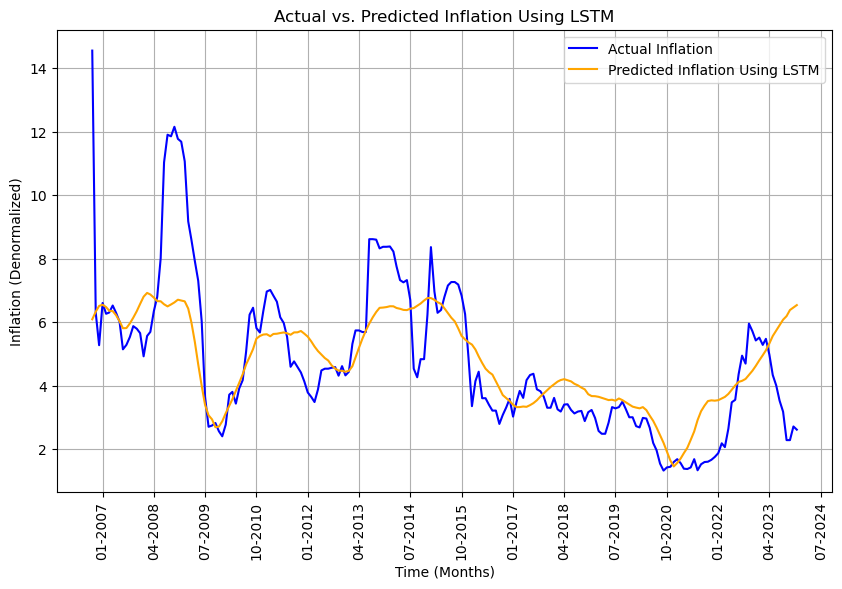

In [146]:
# Plot actual vs. predicted GDP
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['InflationYoY_ID'].values[n_prev_days:], label="Actual Inflation", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_LSTM, label="Predicted Inflation Using LSTM", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("Inflation (Denormalized)")
plt.title("Actual vs. Predicted Inflation Using LSTM")
plt.legend()
plt.grid(True)
plt.show()

In [147]:
def GRU_process_Inflation(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['InflationYoY_ID'].values
    features = data.drop(['InflationYoY_ID'], axis=1)
    #large_features = data[['M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD', 'ID_Import_USD', 'ID_Export_USD', 'ID_CE_USD', 'ID_GFCF_USD']].values

    #log_transformed_features = np.log1p(np.array(large_features, dtype=np.float64))
    #target = np.log1p(np.array(target, dtype=np.float64))
    #numeric_features = np.array(features.drop(['M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD', 'ID_Import_USD', 'ID_Export_USD', 'ID_CE_USD', 'ID_GFCF_USD'], axis=1).values, dtype=np.float64)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    #print(log_transformed_features.shape)
    print(target.shape)
    #scaled_features = np.concatenate((scaled_features, log_transformed_features), axis=1)  # Concatenate along the columns
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 10

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.001, l2=0.002)))
        model.add(MaxPooling1D(pool_size=2))        
        # First Bidirectional GRU Layer
        model.add(GRU(units= 60, recurrent_dropout=0.2,return_sequences = True))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(GRU(units = 48, recurrent_dropout=0.2, return_sequences = True))
        model.add(GRU(units = 16, recurrent_dropout=0.2))

        # Dense Layers for Prediction
        model.add(Dense(4, activation='linear'))
        model.add(Dense(1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('Inflation_GRU_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=10000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['GRU', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)

   
    return model_performance

In [148]:
model_performance_GRU_inflation = GRU_process_Inflation(data_DL, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_IDX', 'Close_USDIDR',
       'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD',
       'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds',
       'InflationYoY_ID'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_IDX            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
InflationYoY_ID      0
dtype: int64
(216, 14)
(216, 1)
(216, 14)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.6042 - mean_absolute_error: 0.4240 - val_loss: 0.5095 - val_mean_absolute_error: 0.3296 - learning_rate: 0.0010
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.4575 - mean_absolute_error: 0.2776 - val_loss: 0.4055 - val_mean_absolute_error: 0.2259 - learning_rate: 0.0010
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.3189 - mean_absolute_error: 0.1393 - val_loss: 0.3472 - val_mean_absolute_error: 0.1679 - learning_rate: 0.0010
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.2927 - mean_absolute_error: 0.1133 - val_loss: 0.3552 - val_mean_absolute_error: 0.1764 - learning_rate: 0.0010
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3404 - mean_absolute_error: 0.1616 - val_loss: 0.3656 - val_mean_absolute_error: 0.1874 - learning_rate: 0.0010
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3467 - mean_absolute_error: 0.1685 - val_loss: 0.3642 - val_mea

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_34 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_35 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.4686 - mean_absolute_error: 0.2904 - val_loss: 0.2841 - val_mean_absolute_error: 0.1063 - learning_rate: 0.0010
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3276 - mean_absolute_error: 0.1498 - val_loss: 0.4913 - val_mean_absolute_error: 0.3143 - learning_rate: 0.0010
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3549 - mean_absolute_error: 0.1780 - val_loss: 0.5158 - val_mean_absolute_error: 0.3400 - learning_rate: 0.0010
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3586 - mean_absolute_error: 0.1829 - val_loss: 0.4539 - val_mean_absolute_error: 0.2793 - learning_rate: 0.0010
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3144 - mean_absolute_error: 0.1399 - val_loss: 0.3741 - val_mean_absolute_error: 0.2007 - learning_rate: 0.0010
Epoch 6/10000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2936 - mean_absolute_error: 0.1202
Epoch 6: ReduceLROnPlateau reducin

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_36 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_38 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - loss: 0.3940 - mean_absolute_error: 0.2166 - val_loss: 0.2837 - val_mean_absolute_error: 0.1074 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3180 - mean_absolute_error: 0.1420 - val_loss: 0.2870 - val_mean_absolute_error: 0.1128 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3192 - mean_absolute_error: 0.1452 - val_loss: 0.2405 - val_mean_absolute_error: 0.0681 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2983 - mean_absolute_error: 0.1262 - val_loss: 0.2638 - val_mean_absolute_error: 0.0934 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3048 - mean_absolute_error: 0.1346 - val_loss: 0.2561 - val_mean_absolute_error: 0.0877 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2882 - mean_absolute_error: 0.1201 - val_loss: 0.2339 - val_mean_a

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_39 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_40 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 750ms/step - loss: 0.4441 - mean_absolute_error: 0.2646 - val_loss: 0.3655 - val_mean_absolute_error: 0.1866 - learning_rate: 0.0010
Epoch 2/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3373 - mean_absolute_error: 0.1588 - val_loss: 0.4108 - val_mean_absolute_error: 0.2335 - learning_rate: 0.0010
Epoch 3/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3285 - mean_absolute_error: 0.1516 - val_loss: 0.2621 - val_mean_absolute_error: 0.0866 - learning_rate: 0.0010
Epoch 4/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2911 - mean_absolute_error: 0.1160 - val_loss: 0.2223 - val_mean_absolute_error: 0.0486 - learning_rate: 0.0010
Epoch 5/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2911 - mean_absolute_error: 0.1178 - val_loss: 0.2428 - val_mean_absolute_error: 0.0710 - learning_rate: 0.0010
Epoch 6/10000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2885 - mean_absolute_error: 0.1170 - val_loss: 0.2143 - val_mean_a

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_42 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_43 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - loss: 0.4275 - mean_absolute_error: 0.2500 - val_loss: 0.2529 - val_mean_absolute_error: 0.0767 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3146 - mean_absolute_error: 0.1389 - val_loss: 0.2524 - val_mean_absolute_error: 0.0787 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2917 - mean_absolute_error: 0.1185 - val_loss: 0.3737 - val_mean_absolute_error: 0.2024 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2801 - mean_absolute_error: 0.1093 - val_loss: 0.3760 - val_mean_absolute_error: 0.2074 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2710 - mean_absolute_error: 0.1029 - val_loss: 0.2973 - val_mean_absolute_error: 0.1311 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2673 - mean_absolute_error: 0.1017 - val_loss: 0.3071 - val_mean_a

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_46 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_47 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - loss: 0.4234 - mean_absolute_error: 0.2446 - val_loss: 0.3118 - val_mean_absolute_error: 0.1340 - learning_rate: 0.0010
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3562 - mean_absolute_error: 0.1788 - val_loss: 0.2446 - val_mean_absolute_error: 0.0685 - learning_rate: 0.0010
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2997 - mean_absolute_error: 0.1240 - val_loss: 0.2825 - val_mean_absolute_error: 0.1081 - learning_rate: 0.0010
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2891 - mean_absolute_error: 0.1152 - val_loss: 0.2605 - val_mean_absolute_error: 0.0879 - learning_rate: 0.0010
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2789 - mean_absolute_error: 0.1068 - val_loss: 0.2284 - val_mean_absolute_error: 0.0578 - learning_rate: 0.0010
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2752 - mean_absolute_error: 0.1050 - val_loss: 0.2250 - val_mean_a

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_50 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - loss: 0.5149 - mean_absolute_error: 0.3377 - val_loss: 0.2976 - val_mean_absolute_error: 0.1219 - learning_rate: 0.0010
Epoch 2/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3143 - mean_absolute_error: 0.1390 - val_loss: 0.3597 - val_mean_absolute_error: 0.1865 - learning_rate: 0.0010
Epoch 3/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2934 - mean_absolute_error: 0.1207 - val_loss: 0.2843 - val_mean_absolute_error: 0.1138 - learning_rate: 0.0010
Epoch 4/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2785 - mean_absolute_error: 0.1086 - val_loss: 0.2928 - val_mean_absolute_error: 0.1249 - learning_rate: 0.0010
Epoch 5/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2668 - mean_absolute_error: 0.0995 - val_loss: 0.3539 - val_mean_absolute_error: 0.1886 - learning_rate: 0.0010
Epoch 6/10000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2710 - mean_absolute_error: 0.1063 - val_loss: 0.3314 - val_mean_a

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_51 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 0.4333 - mean_absolute_error: 0.2557 - val_loss: 0.4171 - val_mean_absolute_error: 0.2404 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.2971 - mean_absolute_error: 0.1208 - val_loss: 0.1991 - val_mean_absolute_error: 0.0241 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2997 - mean_absolute_error: 0.1250 - val_loss: 0.3108 - val_mean_absolute_error: 0.1373 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2959 - mean_absolute_error: 0.1227 - val_loss: 0.3466 - val_mean_absolute_error: 0.1748 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2894 - mean_absolute_error: 0.1179 - val_loss: 0.3007 - val_mean_absolute_error: 0.1305 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2765 - mean_absolute_error: 0.1067 - val_loss: 0.3055 - val_mean_a

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_54 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_55 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - loss: 0.3751 - mean_absolute_error: 0.1967 - val_loss: 0.3944 - val_mean_absolute_error: 0.2172 - learning_rate: 0.0010
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3039 - mean_absolute_error: 0.1272 - val_loss: 0.2177 - val_mean_absolute_error: 0.0424 - learning_rate: 0.0010
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2745 - mean_absolute_error: 0.0997 - val_loss: 0.3439 - val_mean_absolute_error: 0.1707 - learning_rate: 0.0010
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2740 - mean_absolute_error: 0.1013 - val_loss: 0.1932 - val_mean_absolute_error: 0.0222 - learning_rate: 0.0010
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2673 - mean_absolute_error: 0.0968 - val_loss: 0.2374 - val_mean_absolute_error: 0.0687 - learning_rate: 0.0010
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2597 - mean_absolute_error: 0.0916 - val_loss: 0.1922 - val_mean_a

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_29 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_57 (GRU)                    │ (None, 3, 60)          │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_58 (GRU)                    │ (None, 3, 48)          │        15,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_59 (GRU)                    │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,377 (146.00 KB)

 Trainable params: 37,377 (146.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - loss: 0.3373 - mean_absolute_error: 0.1616 - val_loss: 0.1902 - val_mean_absolute_error: 0.0160 - learning_rate: 0.0010
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2827 - mean_absolute_error: 0.1088 - val_loss: 0.1917 - val_mean_absolute_error: 0.0192 - learning_rate: 0.0010
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2622 - mean_absolute_error: 0.0901 - val_loss: 0.2350 - val_mean_absolute_error: 0.0644 - learning_rate: 0.0010
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2574 - mean_absolute_error: 0.0871 - val_loss: 0.1853 - val_mean_absolute_error: 0.0166 - learning_rate: 0.0010
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2543 - mean_absolute_error: 0.0861 - val_loss: 0.2153 - val_mean_absolute_error: 0.0488 - learning_rate: 0.0010
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2499 - mean_absolute_error: 0.0839 - val_loss: 0.1828 - val_mean_a

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2106 - mean_absolute_error: 0.0714 - val_loss: 0.1501 - val_mean_absolute_error: 0.0111 - learning_rate: 1.0000e-04
Epoch 39/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2108 - mean_absolute_error: 0.0719 - val_loss: 0.1497 - val_mean_absolute_error: 0.0109 - learning_rate: 1.0000e-04
Epoch 40/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2076 - mean_absolute_error: 0.0689 - val_loss: 0.1591 - val_mean_absolute_error: 0.0205 - learning_rate: 1.0000e-04
Epoch 41/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2118 - mean_absolute_error: 0.0733 - val_loss: 0.1632 - val_mean_absolute_error: 0.0248 - learning_rate: 1.0000e-04
Epoch 42/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2087 - mean_absolute_error: 0.0704 - val_loss: 0.1549 - val_mean_absolute_error: 0.0167 - learning_rate: 1.0000e-04
Epoch 43/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2105 - mean_absolute_error: 0.0724 - val_loss: 0.1526 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2006 - mean_absolute_error: 0.0691 - val_loss: 0.1436 - val_mean_absolute_error: 0.0123 - learning_rate: 1.0000e-04
Epoch 77/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2018 - mean_absolute_error: 0.0706 - val_loss: 0.1432 - val_mean_absolute_error: 0.0121 - learning_rate: 1.0000e-04
Epoch 78/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2016 - mean_absolute_error: 0.0705 - val_loss: 0.1433 - val_mean_absolute_error: 0.0124 - learning_rate: 1.0000e-04
Epoch 79/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1998 - mean_absolute_error: 0.0689 - val_loss: 0.1427 - val_mean_absolute_error: 0.0119 - learning_rate: 1.0000e-04
Epoch 80/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1997 - mean_absolute_error: 0.0690 - val_loss: 0.1445 - val_mean_absolute_error: 0.0139 - learning_rate: 1.0000e-04
Epoch 81/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1999 - mean_absolute_error: 0.0694 - val_loss: 0.1426 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1888 - mean_absolute_error: 0.0644 - val_loss: 0.1388 - val_mean_absolute_error: 0.0146 - learning_rate: 1.0000e-04
Epoch 115/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1923 - mean_absolute_error: 0.0681 - val_loss: 0.1399 - val_mean_absolute_error: 0.0158 - learning_rate: 1.0000e-04
Epoch 116/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1901 - mean_absolute_error: 0.0661 - val_loss: 0.1413 - val_mean_absolute_error: 0.0174 - learning_rate: 1.0000e-04
Epoch 117/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1915 - mean_absolute_error: 0.0677 - val_loss: 0.1376 - val_mean_absolute_error: 0.0139 - learning_rate: 1.0000e-04
Epoch 118/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1904 - mean_absolute_error: 0.0668 - val_loss: 0.1485 - val_mean_absolute_error: 0.0249 - learning_rate: 1.0000e-04
Epoch 119/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1901 - mean_absolute_error: 0.0667 - val_loss: 0.137

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1831 - mean_absolute_error: 0.0650 - val_loss: 0.1344 - val_mean_absolute_error: 0.0164 - learning_rate: 1.0000e-04
Epoch 153/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1869 - mean_absolute_error: 0.0689 - val_loss: 0.1399 - val_mean_absolute_error: 0.0220 - learning_rate: 1.0000e-04
Epoch 154/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1800 - mean_absolute_error: 0.0621 - val_loss: 0.1487 - val_mean_absolute_error: 0.0310 - learning_rate: 1.0000e-04
Epoch 155/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1833 - mean_absolute_error: 0.0656 - val_loss: 0.1338 - val_mean_absolute_error: 0.0162 - learning_rate: 1.0000e-04
Epoch 156/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1832 - mean_absolute_error: 0.0657 - val_loss: 0.1472 - val_mean_absolute_error: 0.0298 - learning_rate: 1.0000e-04
Epoch 157/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1823 - mean_absolute_error: 0.0648 - val_loss: 0.136

In [150]:
#GRU
top_models_GRU = sorted(model_performance_GRU_inflation, key=lambda x: x[3])[:3]
print("Len Sequences: ", len(input_sequences_DL))
top_model_ids_GRU = [model[1] for model in top_models_GRU]
List_of_Top_Models.append(top_models_GRU)
predicted_values_GRU = []
for id in top_model_ids_GRU:
    model_GRU = load_model('Inflation_GRU_'+str(id)+'.keras')
    predicted_value_GRU = model_GRU.predict(input_sequences_DL)
    predicted_value_GRU = target_scaler.inverse_transform(predicted_value_GRU)
    predicted_values_GRU.append(predicted_value_GRU)

predicted_values_GRU = np.array(predicted_values_GRU)

final_predicted_values_GRU = np.median(predicted_values_GRU, axis=0)
rmse_GRU = np.sqrt(np.mean(((final_predicted_values_GRU[-60:] - data_DL['InflationYoY_ID'][-60:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_GRU)
print("Length Prediction:", len(final_predicted_values_GRU))
print("Length Actual:", len(data_DL['InflationYoY_ID'].values))

Len Sequences:  207
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
RMSE on Last 10 Year Data: 1.6560427008508056
Length Prediction: 207
Length Actual: 216


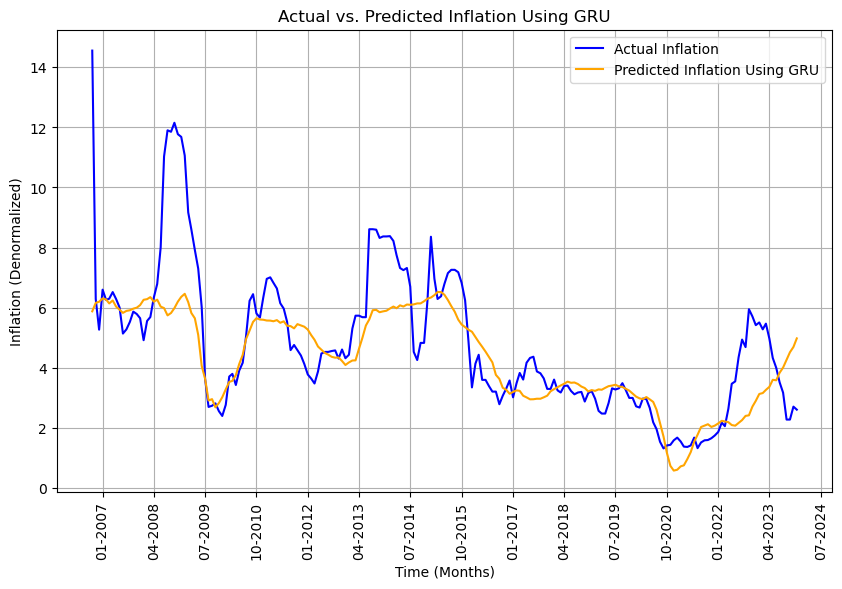

In [151]:
# Plot actual vs. predicted GDP
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['InflationYoY_ID'].values[n_prev_days:], label="Actual Inflation", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_GRU, label="Predicted Inflation Using GRU", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("Inflation (Denormalized)")
plt.title("Actual vs. Predicted Inflation Using GRU")
plt.legend()
plt.grid(True)
plt.show()

In [152]:
def CNNLSTM_process_Inflation(data, PCA_Enable, n_prev_days):
    # Set seeds
    random.seed(7)
    np.random.seed(7)
    tf.random.set_seed(7)
    print("COLUMNS: ", data.columns)
    print("COUNT",data.isnull().sum())
    target = data['InflationYoY_ID'].values
    features = data.drop(['InflationYoY_ID'], axis=1)
    numeric_features = np.array(features.values, dtype=np.float64)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    target = scaler.fit_transform(np.array(target.reshape(-1, 1), dtype=np.float64))
    print(scaled_features.shape)
    #print(log_transformed_features.shape)
    print(target.shape)
    #scaled_features = np.concatenate((scaled_features, log_transformed_features), axis=1)  # Concatenate along the columns
    print(scaled_features.shape)

    if PCA_Enable == True:
        pca = PCA(n_components=0.90)  # retains 95% of the variance
        print("NaN in each column:\n", np.isnan(scaled_features).sum(axis=0))
        scaled_features = pca.fit_transform(scaled_features)
        print("PCA ENABLED")


    # Define the split index for training/validation and holdout
    split_idx = int(0.8 * len(scaled_features))

    # Create training/validation and holdout datasets
    train_val_features = scaled_features[:split_idx]
    train_val_target = target[:split_idx]
    holdout_features = scaled_features[split_idx:]
    holdout_target = target[split_idx:]
    # Prepare input sequences for training/validation
    input_sequences = [train_val_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(train_val_features))]
    input_sequences = np.array(input_sequences)

    train_val_target = train_val_target[n_prev_days:]


    holdout_input_sequences = [holdout_features[i-n_prev_days:i, :] for i in range(n_prev_days, len(holdout_features))]
    holdout_input_sequences = np.array(holdout_input_sequences)
    holdout_target = holdout_target[n_prev_days:]

    # Define the number of folds for cross-validation
    n_splits = 10

    # Initialize the cross-validation
    kfold = TimeSeriesSplit(n_splits=n_splits)
    k = 0
    model_performance = []

    # Iterate over the folds
    for train_index, test_index in kfold.split(input_sequences):
        # Split the data into training and test sets for the current fold
        X_train, X_test = input_sequences[train_index], input_sequences[test_index]
        y_train, y_test = train_val_target[train_index], train_val_target[test_index]

        # Convert the input arrays to TensorFlow tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        #print("Debug LSTM: ", X_train, X_test, y_test, y_train)
        # Define the learning rate
        learning_rate = 0.001
        # Initialising the RNN
        model = Sequential()

        # Adding the 1D Convolutional layer
        model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_prev_days, scaled_features.shape[1]), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
        model.add(MaxPooling1D(pool_size=2))

       # Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units= 64, recurrent_dropout=0.2, return_sequences = True))
        
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 32, return_sequences = True, recurrent_dropout=0.2))
        model.add(LSTM(units = 16, recurrent_dropout=0.2))
        model.add(Dense(units=4, activation='linear'))
        model.add(Dense(units=1))

        # Print the model summary
        model.summary()
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
        model_checkpoint = ModelCheckpoint('Inflation_CNN_'+str(k)+'.keras', monitor='val_loss', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

        # Train the model with early stopping
        model.fit(X_train, y_train, epochs=1000, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])
        
        # Convert holdout data to tensors
        X_holdout = tf.convert_to_tensor(holdout_input_sequences, dtype=tf.float32)
        y_holdout = tf.convert_to_tensor(holdout_target, dtype=tf.float32)

        # Evaluate the model on the holdout set
        test_loss, test_mse = model.evaluate(X_holdout, y_holdout)

        model_performance.append(['CNNLSTM', k, test_loss, test_mse])
        
        k+=1
        print(k)
        time.sleep(1)

    print("Model Performance: ", model_performance)
    return model_performance

In [155]:
model_performance_CNNLSTM_inflation = CNNLSTM_process_Inflation(data_DL, PCA_Enable_DL, n_prev_days)

COLUMNS:  Index(['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_IDX', 'Close_USDIDR',
       'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD', 'M2_JP_USD', 'M2_UK_USD',
       'Rate_ID', 'ID_CE_USD', 'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds',
       'InflationYoY_ID'],
      dtype='object')
COUNT Close_XAU            0
Spread_Bond_10Y2Y    0
Close_IDX            0
Close_USDIDR         0
M2_ID_USD            0
M2_US_USD            0
M2_EU_USD            0
M2_JP_USD            0
M2_UK_USD            0
Rate_ID              0
ID_CE_USD            0
ID_GFCF_USD          0
ID_GDP_USD           0
Total_Bonds          0
InflationYoY_ID      0
dtype: int64
(216, 14)
(216, 1)
(216, 14)


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_102 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_103 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.4944 - mean_absolute_error: 0.3337 - val_loss: 0.5303 - val_mean_absolute_error: 0.3706 - learning_rate: 0.0010
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.4740 - mean_absolute_error: 0.3144 - val_loss: 0.5072 - val_mean_absolute_error: 0.3486 - learning_rate: 0.0010
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.4535 - mean_absolute_error: 0.2949 - val_loss: 0.4834 - val_mean_absolute_error: 0.3258 - learning_rate: 0.0010
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.4320 - mean_absolute_error: 0.2744 - val_loss: 0.4595 - val_mean_absolute_error: 0.3030 - learning_rate: 0.0010
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.4099 - mean_absolute_error: 0.2533 - val_loss: 0.4433 - val_mean_absolute_error: 0.2877 - learning_rate: 0.0010
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3864 - mean_absolute_error: 0.2308 - val_loss: 0.4265 - val_mean_abso

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_105 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.4775 - mean_absolute_error: 0.3187 - val_loss: 0.2634 - val_mean_absolute_error: 0.1062 - learning_rate: 0.0010
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.4293 - mean_absolute_error: 0.2723 - val_loss: 0.2331 - val_mean_absolute_error: 0.0775 - learning_rate: 0.0010
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3845 - mean_absolute_error: 0.2291 - val_loss: 0.2409 - val_mean_absolute_error: 0.0869 - learning_rate: 0.0010
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3389 - mean_absolute_error: 0.1850 - val_loss: 0.2722 - val_mean_absolute_error: 0.1194 - learning_rate: 0.0010
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2916 - mean_absolute_error: 0.1390 - val_loss: 0.3680 - val_mean_absolute_error: 0.2165 - learning_rate: 0.0010
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2784 - mean_absolute_error: 0.1271 - val_loss: 0.4559 - val_mean_absolute_

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_108 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step - loss: 0.4641 - mean_absolute_error: 0.3063 - val_loss: 0.3453 - val_mean_absolute_error: 0.1902 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4142 - mean_absolute_error: 0.2596 - val_loss: 0.2846 - val_mean_absolute_error: 0.1326 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3639 - mean_absolute_error: 0.2122 - val_loss: 0.2271 - val_mean_absolute_error: 0.0780 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3195 - mean_absolute_error: 0.1707 - val_loss: 0.2258 - val_mean_absolute_error: 0.0795 - learning_rate: 0.0010
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2798 - mean_absolute_error: 0.1338 - val_loss: 0.2868 - val_mean_absolute_error: 0.1433 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2865 - mean_absolute_error: 0.1434 - val_loss: 0.3172 - val_mean_absolut

Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 28.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1669 - mean_absolute_error: 0.0794
3


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_111 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 621ms/step - loss: 0.4260 - mean_absolute_error: 0.2666 - val_loss: 0.2421 - val_mean_absolute_error: 0.0843 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3599 - mean_absolute_error: 0.2025 - val_loss: 0.1873 - val_mean_absolute_error: 0.0315 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3180 - mean_absolute_error: 0.1627 - val_loss: 0.2645 - val_mean_absolute_error: 0.1111 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2884 - mean_absolute_error: 0.1354 - val_loss: 0.3413 - val_mean_absolute_error: 0.1905 - learning_rate: 0.0010
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2836 - mean_absolute_error: 0.1334 - val_loss: 0.3294 - val_mean_absolute_error: 0.1814 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2755 - mean_absolute_error: 0.1281 - val_loss: 0.2726 - val_mean_absolut

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_114 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_115 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - loss: 0.3920 - mean_absolute_error: 0.2342 - val_loss: 0.4041 - val_mean_absolute_error: 0.2485 - learning_rate: 0.0010
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.3105 - mean_absolute_error: 0.1553 - val_loss: 0.2665 - val_mean_absolute_error: 0.1135 - learning_rate: 0.0010
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2848 - mean_absolute_error: 0.1325 - val_loss: 0.2111 - val_mean_absolute_error: 0.0619 - learning_rate: 0.0010
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2819 - mean_absolute_error: 0.1334 - val_loss: 0.2473 - val_mean_absolute_error: 0.1017 - learning_rate: 0.0010
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2607 - mean_absolute_error: 0.1158 - val_loss: 0.3025 - val_mean_absolute_error: 0.1604 - learning_rate: 0.0010
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2552 - mean_absolute_error: 0.1138 - val_loss: 0.3264 - val_mean_absolut

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_37 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_117 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - loss: 0.4362 - mean_absolute_error: 0.2771 - val_loss: 0.3665 - val_mean_absolute_error: 0.2094 - learning_rate: 0.0010
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3440 - mean_absolute_error: 0.1873 - val_loss: 0.2482 - val_mean_absolute_error: 0.0933 - learning_rate: 0.0010
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2781 - mean_absolute_error: 0.1237 - val_loss: 0.2267 - val_mean_absolute_error: 0.0745 - learning_rate: 0.0010
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2743 - mean_absolute_error: 0.1228 - val_loss: 0.2296 - val_mean_absolute_error: 0.0809 - learning_rate: 0.0010
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2698 - mean_absolute_error: 0.1218 - val_loss: 0.2035 - val_mean_absolute_error: 0.0583 - learning_rate: 0.0010
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2504 - mean_absolute_error: 0.1061 - val_loss: 0.2080 - val_mean_absolut

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_120 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_121 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - loss: 0.4239 - mean_absolute_error: 0.2663 - val_loss: 0.2227 - val_mean_absolute_error: 0.0677 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3249 - mean_absolute_error: 0.1705 - val_loss: 0.2748 - val_mean_absolute_error: 0.1227 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2739 - mean_absolute_error: 0.1226 - val_loss: 0.3561 - val_mean_absolute_error: 0.2079 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2719 - mean_absolute_error: 0.1246 - val_loss: 0.2799 - val_mean_absolute_error: 0.1356 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2513 - mean_absolute_error: 0.1080 - val_loss: 0.2587 - val_mean_absolute_error: 0.1185 - learning_rate: 0.0010
Epoch 6/1000
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2612 - mean_absolute_error: 0.1210
Epoch 6: ReduceLROnPlateau reducing l

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_39 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_123 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_124 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - loss: 0.4175 - mean_absolute_error: 0.2597 - val_loss: 0.1905 - val_mean_absolute_error: 0.0347 - learning_rate: 0.0010
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2903 - mean_absolute_error: 0.1351 - val_loss: 0.3901 - val_mean_absolute_error: 0.2374 - learning_rate: 0.0010
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2815 - mean_absolute_error: 0.1296 - val_loss: 0.4079 - val_mean_absolute_error: 0.2590 - learning_rate: 0.0010
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2772 - mean_absolute_error: 0.1291 - val_loss: 0.3417 - val_mean_absolute_error: 0.1963 - learning_rate: 0.0010
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2527 - mean_absolute_error: 0.1081 - val_loss: 0.3056 - val_mean_absolute_error: 0.1637 - learning_rate: 0.0010
Epoch 6/1000
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2400 - mean_absolute_error: 0.0982
Epoch 6: ReduceLROnPlateau reducing l

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_126 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_127 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 0.3780 - mean_absolute_error: 0.2199 - val_loss: 0.2400 - val_mean_absolute_error: 0.0853 - learning_rate: 0.0010
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2753 - mean_absolute_error: 0.1216 - val_loss: 0.4153 - val_mean_absolute_error: 0.2657 - learning_rate: 0.0010
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2701 - mean_absolute_error: 0.1218 - val_loss: 0.3333 - val_mean_absolute_error: 0.1895 - learning_rate: 0.0010
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2534 - mean_absolute_error: 0.1109 - val_loss: 0.2471 - val_mean_absolute_error: 0.1088 - learning_rate: 0.0010
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2458 - mean_absolute_error: 0.1088 - val_loss: 0.2149 - val_mean_absolute_error: 0.0821 - learning_rate: 0.0010
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2375 - mean_absolute_error: 0.1060 - val_loss: 0.2164 - val_mean_absolut

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_41 (Conv1D)              │ (None, 7, 32)          │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,833 (163.41 KB)

 Trainable params: 41,833 (163.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: 0.3676 - mean_absolute_error: 0.2111 - val_loss: 0.3998 - val_mean_absolute_error: 0.2456 - learning_rate: 0.0010
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2884 - mean_absolute_error: 0.1353 - val_loss: 0.3494 - val_mean_absolute_error: 0.1995 - learning_rate: 0.0010
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2590 - mean_absolute_error: 0.1101 - val_loss: 0.2311 - val_mean_absolute_error: 0.0853 - learning_rate: 0.0010
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2422 - mean_absolute_error: 0.0974 - val_loss: 0.2072 - val_mean_absolute_error: 0.0656 - learning_rate: 0.0010
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2300 - mean_absolute_error: 0.0893 - val_loss: 0.1907 - val_mean_absolute_error: 0.0532 - learning_rate: 0.0010
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2211 - mean_absolute_error: 0.0846 - val_loss: 0.1536 - val_mean_absolut

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1357 - mean_absolute_error: 0.0686 - val_loss: 0.0787 - val_mean_absolute_error: 0.0117 - learning_rate: 1.0000e-04
Epoch 40/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1355 - mean_absolute_error: 0.0686 - val_loss: 0.0783 - val_mean_absolute_error: 0.0115 - learning_rate: 1.0000e-04
Epoch 41/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1473 - mean_absolute_error: 0.0805
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1351 - mean_absolute_error: 0.0683 - val_loss: 0.0836 - val_mean_absolute_error: 0.0169 - learning_rate: 1.0000e-04
Epoch 42/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1358 - mean_absolute_error: 0.0692 - val_loss: 0.0794 - val_mean_absolute_error: 0.0129 - learning_rate: 1.0000e-04
Epoch 43/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1357 - mean_absolute_error: 0.0693 - val_loss: 0.0768 - val_mean_absolute_error: 0.0105 - learn

Epoch 77/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1274 - mean_absolute_error: 0.0664 - val_loss: 0.0717 - val_mean_absolute_error: 0.0108 - learning_rate: 1.0000e-04
Epoch 78/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1288 - mean_absolute_error: 0.0680 - val_loss: 0.0716 - val_mean_absolute_error: 0.0109 - learning_rate: 1.0000e-04
Epoch 79/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1291 - mean_absolute_error: 0.0684 - val_loss: 0.0748 - val_mean_absolute_error: 0.0142 - learning_rate: 1.0000e-04
Epoch 80/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1284 - mean_absolute_error: 0.0678 - val_loss: 0.0713 - val_mean_absolute_error: 0.0108 - learning_rate: 1.0000e-04
Epoch 81/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1291 - mean_absolute_error: 0.0687 - val_loss: 0.0712 - val_mean_absolute_error: 0.0108 - learning_rate: 1.0000e-04
Epoch 82/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1296 - mean_absolute_error: 0.0693 - val_loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1224 - mean_absolute_error: 0.0666 - val_loss: 0.0672 - val_mean_absolute_error: 0.0115 - learning_rate: 1.0000e-04
Epoch 116/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1235 - mean_absolute_error: 0.0678 - val_loss: 0.0693 - val_mean_absolute_error: 0.0137 - learning_rate: 1.0000e-04
Epoch 117/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1228 - mean_absolute_error: 0.0673 - val_loss: 0.0689 - val_mean_absolute_error: 0.0134 - learning_rate: 1.0000e-04
Epoch 118/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1220 - mean_absolute_error: 0.0666 - val_loss: 0.0691 - val_mean_absolute_error: 0.0138 - learning_rate: 1.0000e-04
Epoch 119/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1223 - mean_absolute_error: 0.0670 - val_loss: 0.0694 - val_mean_absolute_error: 0.0142 - learning_rate: 1.0000e-04
Epoch 120/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1217 - mean_absolute_error: 0.0665 - val_loss: 0.0676 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1178 - mean_absolute_error: 0.0662 - val_loss: 0.0717 - val_mean_absolute_error: 0.0201 - learning_rate: 1.0000e-04
Epoch 154/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1170 - mean_absolute_error: 0.0655 - val_loss: 0.0687 - val_mean_absolute_error: 0.0173 - learning_rate: 1.0000e-04
Epoch 155/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1168 - mean_absolute_error: 0.0654 - val_loss: 0.0722 - val_mean_absolute_error: 0.0208 - learning_rate: 1.0000e-04
Epoch 156/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1170 - mean_absolute_error: 0.0657 - val_loss: 0.0666 - val_mean_absolute_error: 0.0153 - learning_rate: 1.0000e-04
Epoch 157/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1174 - mean_absolute_error: 0.0662 - val_loss: 0.0752 - val_mean_absolute_error: 0.0240 - learning_rate: 1.0000e-04
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 147.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

In [156]:
#CNNLSTM
top_models_CNNLSTM = sorted(model_performance_CNNLSTM_inflation, key=lambda x: x[3])[:3]
print("Len Sequences: ", (input_sequences_DL.shape))
top_model_ids_CNN = [model[1] for model in top_models_CNNLSTM]
List_of_Top_Models.append(top_models_CNNLSTM)
predicted_values_CNN = []
for id in top_model_ids_CNN:
    model_CNN = load_model('Inflation_CNN_'+str(id)+'.keras')
    predicted_value_CNN = model_CNN.predict(input_sequences_DL)
    predicted_value_CNN = target_scaler.inverse_transform(predicted_value_CNN)
    predicted_values_CNN.append(predicted_value_CNN)

predicted_values_CNN = np.array(predicted_values_CNN)

final_predicted_values_CNN = np.median(predicted_values_CNN, axis=0)
rmse_CNN = np.sqrt(np.mean(((final_predicted_values_CNN[-60:] - data_DL['InflationYoY_ID'][-60:].values) ** 2)))  # Apply inverse transformation to y_test if necessary
print("RMSE on Last 10 Year Data:", rmse_CNN)
print("Length Prediction:", len(final_predicted_values_CNN))
print("Length Actual:", len(data_DL['InflationYoY_ID'].values))

Len Sequences:  (207, 9, 14)
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
RMSE on Last 10 Year Data: 1.5542181800723955
Length Prediction: 207
Length Actual: 216


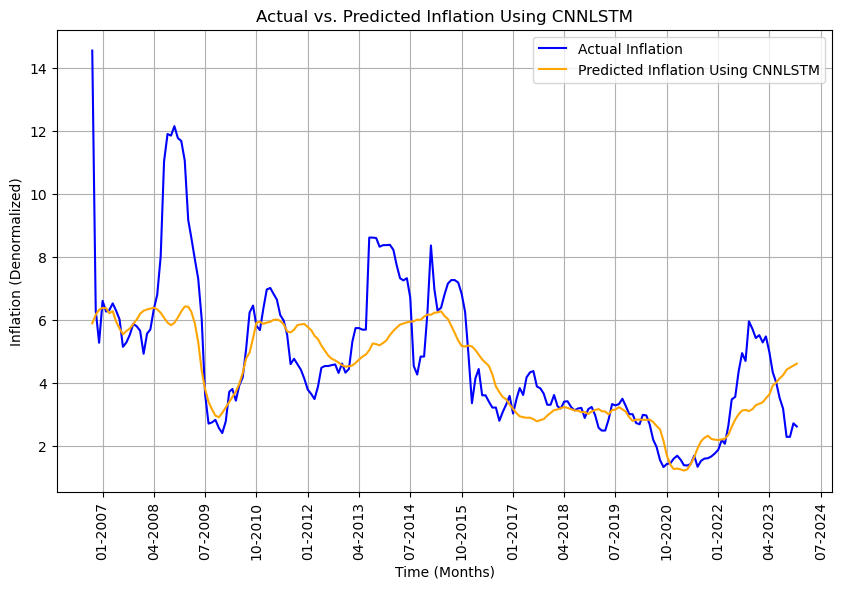

In [158]:
# Plot actual vs. predicted GDP
dates = [datetime.strptime(date, '%m-%Y') for date in data_DL.index]
plt.figure(figsize=(10, 6))
plt.plot(dates[n_prev_days:], data_DL['InflationYoY_ID'].values[n_prev_days:], label="Actual Inflation", color="blue")
plt.plot(dates[n_prev_days:], final_predicted_values_CNN, label="Predicted Inflation Using CNNLSTM", color="orange")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("Inflation (Denormalized)")
plt.title("Actual vs. Predicted Inflation Using CNNLSTM")
plt.legend()
plt.grid(True)
plt.show()

In [159]:
columns_names_model = ['Model', 'Id', 'Loss', 'MSE']
List_of_Top_Model = [item for sublist in List_of_Top_Models for item in sublist]
top_models_df = pd.DataFrame(List_of_Top_Model, columns=columns_names_model)
top_models_df.to_csv('Model_Performance_Inflation.csv', index=True)
top_models_df

Model  Id      Loss       MSE
0      LSTM  13  0.148032  0.096608
1      LSTM  14  0.149518  0.121283
2      LSTM  11  0.173380  0.140538
3      LSTM   9  0.116387  0.092004
4      LSTM   8  0.158621  0.076322
5      LSTM   7  0.181438  0.129908
6       GRU   8  0.207605  0.067532
7       GRU   3  0.247629  0.089403
8       GRU   9  0.212236  0.094624
9       GRU   8  0.207605  0.067532
10      GRU   3  0.247629  0.089403
11      GRU   9  0.212236  0.094624
12  CNNLSTM   9  0.123731  0.071568
13  CNNLSTM   8  0.136747  0.076065
14  CNNLSTM   2  0.168159  0.080672

In [160]:
top_models_df = pd.read_csv('Model_Performance_Inflation.csv')

top_models_df

Unnamed: 0    Model  Id      Loss       MSE
0            0     LSTM  13  0.148032  0.096608
1            1     LSTM  14  0.149518  0.121283
2            2     LSTM  11  0.173380  0.140538
3            3     LSTM   9  0.116387  0.092004
4            4     LSTM   8  0.158621  0.076322
5            5     LSTM   7  0.181438  0.129908
6            6      GRU   8  0.207605  0.067532
7            7      GRU   3  0.247629  0.089403
8            8      GRU   9  0.212236  0.094624
9            9      GRU   8  0.207605  0.067532
10          10      GRU   3  0.247629  0.089403
11          11      GRU   9  0.212236  0.094624
12          12  CNNLSTM   9  0.123731  0.071568
13          13  CNNLSTM   8  0.136747  0.076065
14          14  CNNLSTM   2  0.168159  0.080672

In [162]:
inflation_features = ['Close_XAU', 'Spread_Bond_10Y2Y', 'Close_IDX',
                      'Close_USDIDR', 'M2_ID_USD', 'M2_US_USD', 'M2_EU_USD',
                      'M2_JP_USD', 'M2_UK_USD', 'Rate_ID', 'ID_CE_USD', 
                      'ID_GFCF_USD', 'ID_GDP_USD', 'Total_Bonds', 'InflationYoY_ID']

data_ML = data_with_bond[inflation_features]
PCA_Enable_ML = False
target_ML = data_ML['InflationYoY_ID'].values
features_ML = data_ML.drop(['InflationYoY_ID'], axis=1)
numeric_features_ML = np.array(features_ML.values, dtype=np.float64)
scaler = MinMaxScaler()
scaled_features_ML = scaler.fit_transform(numeric_features_ML)
target_ML = scaler.fit_transform(np.array(target_ML.reshape(-1, 1), dtype=np.float64))
print(scaled_features_ML.shape)
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]


if PCA_Enable_ML == True:
    pca = PCA(n_components=0.90)  # retains 95% of the variance
    print("NaN in each column:\n", np.isnan(scaled_features_ML).sum(axis=0))
    scaled_features_ML = pca.fit_transform(scaled_features_ML)
    print("PCA ENABLED")

n_splits = 10

split_idx = int(0.8 * len(scaled_features_ML))

# Create training/validation and holdout datasets
train_val_features = scaled_features_ML[:split_idx]
train_val_target = target_ML[:split_idx]
holdout_features = scaled_features_ML[split_idx:]
holdout_target = target_ML[split_idx:]

# Initialize the cross-validation
kfold = TimeSeriesSplit(n_splits=n_splits)
k = 0

(216, 14)


In [163]:
model_performance_SVR = []

# Iterate over the folds
for train_index, test_index in kfold.split(train_val_features):
    X_train, X_test = train_val_features[train_index], train_val_features[test_index]
    y_train, y_test = train_val_target[train_index], train_val_target[test_index]

    model_SVR = SVR(kernel='rbf', C=1e2, gamma=0.008, epsilon=0.002)
    model_SVR.fit(X_train, y_train)
    predictions_SVR = model_SVR.predict(holdout_features)
    mse_SVR = mean_squared_error(holdout_target, predictions_SVR)
    
    model_performance_SVR.append((model_SVR, mse_SVR))
    
    print(f'Train indices: {train_index[0]}-{train_index[-1]}, Test indices: {test_index[0]}-{test_index[-1]}')
    print(f'MSE: {mse_SVR}')

Train indices: 0-21, Test indices: 22-36
MSE: 0.1159110961731681
Train indices: 0-36, Test indices: 37-51
MSE: 0.1784402695231804
Train indices: 0-51, Test indices: 52-66
MSE: 0.026542375707833746
Train indices: 0-66, Test indices: 67-81
MSE: 0.10260292856743415
Train indices: 0-81, Test indices: 82-96
MSE: 0.03153402075135631
Train indices: 0-96, Test indices: 97-111
MSE: 0.03892529531046138
Train indices: 0-111, Test indices: 112-126
MSE: 0.29621900585599764
Train indices: 0-126, Test indices: 127-141
MSE: 0.8886926227646718
Train indices: 0-141, Test indices: 142-156
MSE: 0.17232723433640162
Train indices: 0-156, Test indices: 157-171
MSE: 0.32197448946296725


C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ITSEC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [164]:
# Sorting models based on MSE
top_models_SVR = sorted(model_performance_SVR, key=lambda x: x[1])[:3]

# Print top model performance
print("Top 3 Model Performances:")
for model, mse in top_models_SVR:
    print(f'MSE: {mse}')
    
    
predictions_SVR = []

for model, _ in top_models_SVR:  # assuming top_models stores (model, mse) tuples
    pred = model.predict(scaled_features_ML)
    pred = scaler.inverse_transform(pred.reshape(-1, 1))
    predictions_SVR.append(pred)

# Convert list of prediction arrays into a NumPy array for easier manipulation
final_predictions_SVR = np.array(predictions_SVR)

# Calculate median along the axis that represents different model predictions
final_predictions_SVR = np.median(final_predictions_SVR, axis=0)

print("Final Prediction by taking the median of predictions from the top 3 models:", final_predictions_SVR[-7:])

rmse_SVR = np.sqrt(mean_squared_error(data_ML['InflationYoY_ID'][-60:].values, final_predictions_SVR[-60:]))

print("RMSE:", rmse_SVR)

Top 3 Model Performances:
MSE: 0.026542375707833746
MSE: 0.03153402075135631
MSE: 0.03892529531046138
Final Prediction by taking the median of predictions from the top 3 models: [[5.38095892]
 [5.81495538]
 [5.97614421]
 [5.98960244]
 [6.74251234]
 [6.62810873]
 [6.09540027]]
RMSE: 3.093758283334781


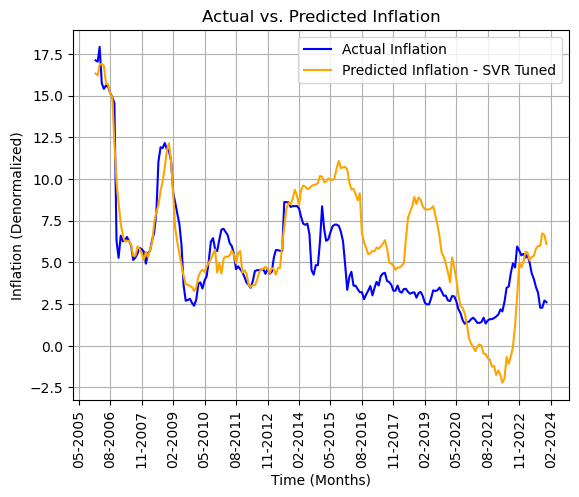

In [165]:
plt.plot(dates, data_ML['InflationYoY_ID'].values, label='Actual Inflation', color='blue', linestyle='-')
plt.plot(dates, final_predictions_SVR, label='Predicted Inflation - SVR Tuned', color='orange', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("Inflation (Denormalized)")
plt.title("Actual vs. Predicted Inflation")
plt.legend()
plt.grid(True)
plt.show()

In [166]:
#Ridge
model_performance_LRR = []

# Iterate over the folds
for train_index, test_index in kfold.split(train_val_features):
    X_train, X_test = train_val_features[train_index], train_val_features[test_index]
    y_train, y_test = train_val_target[train_index], train_val_target[test_index]

    model_LRR = Ridge(alpha=0.037)  # You can adjust the alpha parameter if needed
    model_LRR.fit(X_train, y_train)
    predictions_LRR = model_LRR.predict(holdout_features)
    mse_LRR = mean_squared_error(holdout_target, predictions_LRR)
    
    model_performance_LRR.append((model_LRR, mse_LRR))
    
    print(f'Train indices: {train_index[0]}-{train_index[-1]}, Test indices: {test_index[0]}-{test_index[-1]}')
    print(f'MSE: {mse_LRR}')

Train indices: 0-21, Test indices: 22-36
MSE: 0.2743306210836979
Train indices: 0-36, Test indices: 37-51
MSE: 0.3114791488764233
Train indices: 0-51, Test indices: 52-66
MSE: 0.1252851224875227
Train indices: 0-66, Test indices: 67-81
MSE: 0.3069415753541913
Train indices: 0-81, Test indices: 82-96
MSE: 0.09250163551535392
Train indices: 0-96, Test indices: 97-111
MSE: 0.03438202501848047
Train indices: 0-111, Test indices: 112-126
MSE: 0.3689453216673229
Train indices: 0-126, Test indices: 127-141
MSE: 0.758177321686372
Train indices: 0-141, Test indices: 142-156
MSE: 0.30810213286993
Train indices: 0-156, Test indices: 157-171
MSE: 0.34473153967722986


In [167]:
# Sorting models based on MSE
top_models_LRR = sorted(model_performance_LRR, key=lambda x: x[1])[:3]

# Print top model performance
print("Top 3 Model Performances:")
for model, mse in top_models_LRR:
    print(f'MSE: {mse}')

# Prediction using top models
predictions_LRR = []
for model, _ in top_models_LRR:
    pred = model.predict(scaled_features_ML)
    pred = scaler.inverse_transform(pred.reshape(-1, 1))  # Scale back the prediction
    predictions_LRR.append(pred)

# Calculate the median of predictions from the top 3 models
final_predictions_LRR = np.median(np.array(predictions_LRR), axis=0)
# Compute RMSE for the last 65 entries
rmse_LRR = np.sqrt(mean_squared_error(data_ML['InflationYoY_ID'][-60:].values, final_predictions_LRR[-60:]))
print("RMSE:", rmse_LRR)

Top 3 Model Performances:
MSE: 0.03438202501848047
MSE: 0.09250163551535392
MSE: 0.1252851224875227
RMSE: 5.37141672992976


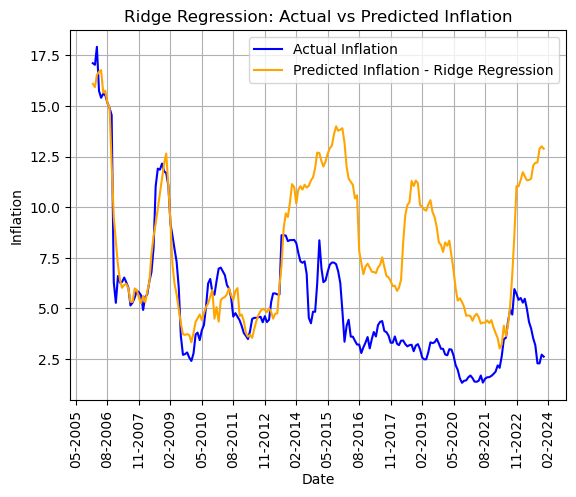

In [168]:
plt.plot(dates, data_ML['InflationYoY_ID'].values, label='Actual Inflation', color='blue', linestyle='-')
plt.plot(dates, final_predictions_LRR, label='Predicted Inflation - Ridge Regression', color='orange', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))
plt.xticks(rotation=90)
plt.title('Ridge Regression: Actual vs Predicted Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.show()

In [169]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_1 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_1 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_1,
    final_predictions_LRR_1,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])

# Calculate the median across predictions for each instance (axis=1)
predictions_ensemble_median = np.median(predictions_stack, axis=1)

# Assuming 'data['ID_GDP_USD'].values[-65:]' is a 1D array (65,)
true_values = data_DL['InflationYoY_ID'].values[-120:]
rmse = np.sqrt(mean_squared_error(true_values, predictions_ensemble_median))

print("RMSE:", rmse)

RMSE: 1.819355467340063


In [170]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_2 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_2 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_2,
    final_predictions_LRR_2,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])

# Calculate the mean across predictions for each instance (axis=1)
predictions_ensemble_mean = np.mean(predictions_stack, axis=1)

rmse = np.sqrt(mean_squared_error(true_values, predictions_ensemble_mean))

print("RMSE:", rmse)

RMSE: 2.234959316175034


In [171]:
# Ensure all predictions are reshaped to (65, 1) before stacking
final_predictions_SVR_3 = np.array(final_predictions_SVR[-120:]).reshape(-1, 1)  # Reshape SVR predictions
final_predictions_LRR_3 = np.array(final_predictions_LRR[-120:]).reshape(-1, 1)  # Reshape Ridge predictions

# Stack predictions horizontally (ensure all are (65, 1) before stacking)
predictions_stack = np.hstack([
    final_predictions_SVR_3,
    final_predictions_LRR_3,
    np.array(final_predicted_values_CNN[-120:]),  # No need to reshape, already (65, 1)
    np.array(final_predicted_values_GRU[-120:])  # No need to reshape, already (65, 1)
])


weights = [0.2, 0.2, 0.3, 0.3]  # Ensure these sum to 1

# Calculate weighted average
predictions_ensemble_weighted = np.average(predictions_stack, axis=1, weights=weights)

# Compute RMSE for the weighted average
rmse_weighted = np.sqrt(mean_squared_error(true_values, predictions_ensemble_weighted))
print("Weighted RMSE:", rmse_weighted)

Weighted RMSE: 1.8789493470745693


In [172]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)

true_values_train = data_DL['InflationYoY_ID'].values[n_prev_days:-120]


print("SVR Predictions Train Size:", final_predictions_SVR[n_prev_days:-120].shape)
print("LRR Predictions Train Size:", final_predictions_LRR[n_prev_days:-120].shape)
print("CNN Predicted Values Train Size:", final_predicted_values_CNN[:-120].shape)
print("GRU Predicted Values Train Size:", final_predicted_values_GRU[:-120].shape)
print("Size of true_values_train:", true_values_train.shape)

# Stack the predictions for the training set
predictions_stack_train = np.hstack([
    final_predictions_SVR[n_prev_days:-120].reshape(-1, 1),  # Reshape is technically not needed here since they are already (192, 1)
    final_predictions_LRR[n_prev_days:-120].reshape(-1, 1),
    final_predicted_values_CNN[:-120],
    final_predicted_values_GRU[:-120]
])

# Stack the predictions for the test set
predictions_stack_test = np.hstack([
    final_predictions_SVR[-120:].reshape(-1, 1),
    final_predictions_LRR[-120:].reshape(-1, 1),
    final_predicted_values_CNN[-120:],
    final_predicted_values_GRU[-120:]
])

meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(predictions_stack_train.shape[1],)),  # Input layer
    Dropout(0,2),
    Dense(16, activation='linear'),  # Hidden layer
    Dense(1)  # Output layer
])

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
meta_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, mode="min", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4, mode="min", verbose=1)

meta_model.fit(predictions_stack_train, true_values_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

# Use the trained model to make predictions
predictions_ensemble_stacked = meta_model.predict(predictions_stack_test)

# Compute RMSE for the neural network model
rmse_stacked = np.sqrt(mean_squared_error(true_values, predictions_ensemble_stacked.flatten()))  # Flatten to make sure the shapes align
print("Neural Network Stacked RMSE:", rmse_stacked)

SVR Predictions Train Size: (87, 1)
LRR Predictions Train Size: (87, 1)
CNN Predicted Values Train Size: (87, 1)
GRU Predicted Values Train Size: (87, 1)
Size of true_values_train: (87,)
Epoch 1/100


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 66.0708 - mean_squared_error: 66.0708 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.5079 - mean_squared_error: 57.5079 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.7190 - mean_squared_error: 49.7190 - learning_rate: 0.0010
Epoch 4/100


C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)
C:\Users\ITSEC\anaconda3\lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error,learning_rate.
  callback.on_epoch_end(epoch, logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 42.6537 - mean_squared_error: 42.6537 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.2718 - mean_squared_error: 36.2718 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.5364 - mean_squared_error: 30.5364 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.4069 - mean_squared_error: 25.4069 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.8595 - mean_squared_error: 20.8595 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 16.8549 - mean_squared_error: 16.8549 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3846 - mean_squared_error: 13.3846 - learning_rate: 0.0010
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 10.4356 - mean_squared_error: 10.4356 - learning_rate: 0.0010
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 7.

Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2822 - mean_squared_error: 1.2822 - learning_rate: 0.0010
Epoch 59/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2806 - mean_squared_error: 1.2806 - learning_rate: 0.0010
Epoch 60/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2790 - mean_squared_error: 1.2790 - learning_rate: 0.0010
Epoch 61/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2775 - mean_squared_error: 1.2775 - learning_rate: 0.0010
Epoch 62/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2761 - mean_squared_error: 1.2761 - learning_rate: 0.0010
Epoch 63/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2748 - mean_squared_error: 1.2748 - learning_rate: 0.0010
Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2735 - mean_squared_error: 1.2735 - learning_rate: 0.0010
Epoch 65/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2722 - mean_squared_error: 1.2722 - learning_rate: 0.0010
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

In [173]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

model = ExponentialSmoothing(predictions_ensemble_stacked, seasonal='add', seasonal_periods=12).fit()
predictions_ensemble_stacked_smoothing = model.fittedvalues
rmse_stacked_smoothing = np.sqrt(mean_squared_error(true_values, predictions_ensemble_stacked_smoothing))
print("Stacked RMSE:", rmse_stacked_smoothing)

Stacked RMSE: 4.647549126140635


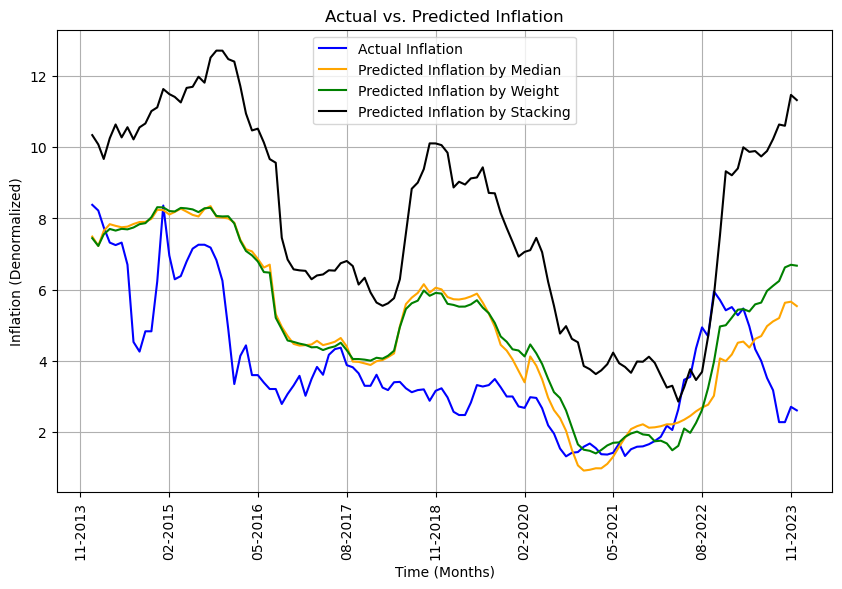

In [175]:
# Plot actual vs. predicted GDP
dates = [datetime.strptime(date, '%m-%Y') for date in data_with_bond.index]
plt.figure(figsize=(10, 6))
plt.plot(dates[-120:], data_ML['InflationYoY_ID'].values[-120:], label="Actual Inflation", color="blue")
plt.plot(dates[-120:], predictions_ensemble_median.flatten(), label="Predicted Inflation by Median", color="orange")
#plt.plot(dates[-120:], predictions_ensemble_mean.flatten(), label="Predicted GDP by Mean", color="red")
plt.plot(dates[-120:], predictions_ensemble_weighted.flatten(), label="Predicted Inflation by Weight", color="green")
plt.plot(dates[-120:], predictions_ensemble_stacked_smoothing.flatten(), label="Predicted Inflation by Stacking", color="black")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Set the format for the dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=15))  # Set to show one tick every three months
plt.xticks(rotation=90) 
plt.xlabel("Time (Months)")
plt.ylabel("Inflation (Denormalized)")
plt.title("Actual vs. Predicted Inflation")
plt.legend()
plt.grid(True)
plt.show()